## EUR/USD 0.1
This bot will utilize the strategies used in Bitcoin 0.2, with many methods pasted over that were made by Frank, tested on EUR/USD through OANDA. 
This includes:

 - MACD
 - Heiken Ashi
 - MACD Convergence/Divergence
 - Hull Moving Average 
 
 


### Personal Notes:
- Turn a lot the code into methods to make it easier to reuse later on and easier scrolling. Will try it out on various timeframes later on
- A lot of these methods are underperforming or not executing at all for Eur/USD, most likely because markets are more sideways than volatile like bitcoin
- I want to implement more scalping like tactic, so working with smaller time frames like 1 min, 5 min, 15 min. I will implement this cleanly in my next nb. The longer timeframes performs poorly in sideway markets.
- A lot of trouble with the 4.3 and the sharpe ratio in 4.4. Look into that later
- Working on custom made methods not copy pasted directly from bitcoin, once i finish my own prototypes, i want to start on the next version.

## [1. Importing Packages and Methods](#1_importing_packages_and_methods)
## [2. Importing Data](#2)
## [3. Connecting to OANDA](#3)
## [4. Trading Strategies](#4)
- ### [4.1 MACD](#4_1)
    - #### [4.1.1 MACD Over Signal](#4_1_1)
    - #### [4.1.2 MACD Differnce Over Signal](#4_1_2)
    - #### [4.1.3 MACD Conditioned Bollinger Momentum](#4_1_3)
- ### [4.2 Heikin Ashi](#4_2)
    - #### [4.2.1 Heikin Ashi Consecutive Candles](#4_2_1)
    - #### [4.2.2 Heikin Ashi No Last Wick](#4_2_2)
        - #### [Strategy Map](#strategy_map)
    - #### [4.2.3 Heikin Ashi and Stochastic](#4_2_3)
        - #### [Strategy Map](#strategy_map_)
- ### [4.3 Divergence](#4_3)    (Work in progress)
    - #### [4.3.1 MACD Convergence and Divergence](#4_3_1_macd_convergence_and_divergence)
- ### [4.4 Hull Moving Average](#4_4)
    - #### [4.4.1 HMA Simple Momentum](#4_4_1)
    - #### [4.4.2 HMA and EMA Momentum](#4_4_2)
    - #### [4.4.3 HMA and EMA Between](#4_4_3)     (Work in progress)
    - #### [4.4.4 HMA and RSI](#4_4_4)             (Work in progress)

In [45]:
## Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import statsmodels.api as sm
import gc

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

# To graph heikin ashi
import mplfinance as mpf  
from mpl_finance import candlestick_ohlc  #note, this is an outdated version of mplfinance (note the "_")
import matplotlib

from tqdm import tqdm
import itertools
import gc
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

C:\Users\Andre\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


## 1. Methods <a id='1_importing_packages_and_methods'></a>

In [50]:
#Exponential Moving Average 
def add_ema(df, ema_s, ema_l):
    #needed to change df
    df = df.copy()
    
    # Calculate the short EMA
    ema_s_name = f"{ema_s}_EMA"
    df[ema_s_name] = df['Close'].ewm(span=ema_s, adjust=False).mean()

    # Calculate the long EMA
    ema_l_name = f"{ema_l}_EMA"
    df[ema_l_name] = df['Close'].ewm(span=ema_l, adjust=False).mean()
    
    # Create a column for trading signals
    df['Signal'] = 0.0
    # Generate trading signals based on EMA cross-overs
    df['Signal'][df[ema_s_name] > df[ema_l_name]] = 0.5
    df['Signal'][df[ema_s_name] < df[ema_l_name]] = -0.5
    # Create a column 'Position' which is the cumulative sum of the 'Signal' column
    df['Position'] = df['Signal'].cumsum()
    
    return df

#MACD
def add_macd(df):
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    # Calculate the 26-day EMA
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    # Calculate the MACD line
    macd_line = ema_12 - ema_26
    # Calculate the 9-day EMA of the MACD line
    signal_line = macd_line.ewm(span=9, adjust=False).mean()

    # Add the MACD and signal lines as new columns to the dataframe
    df['MACD'] = macd_line
    df['Signal Line'] = signal_line
    return df

#Heikin
def add_heiking_ashi(df):
    """ Assuming the column names are as below"""
    ## We are adding heikin ashi candle prices with a new dataframe
    temp = df.copy()
    # Heiking ashi candle prices
    temp['ha_close'] = (temp['open'] + temp['high'] + temp['low'] + temp['close'])/4
    temp['ha_open'] = (temp['open'].shift(1) + temp['close'].shift(1))/2
    temp['ha_high'] = temp[['high', 'ha_open', 'ha_close']].max(axis=1)
    temp['ha_low'] = temp[['low', 'ha_open', 'ha_close']].min(axis=1)
    
    return temp

# Method to add bollinger bands, default parameter for n_std = 2.1
# Bollinger band function.

def add_bollinger_bands(df: pd.DataFrame, column, sma=150, n_std=2.1):
    """
    sma is the simple moving average, the int specifies a number
    """
    # Using dtype with float 32 will save more space
    dtype = np.float32
    
    # Making a copy of the dataframe so we don't modify the original data
    data = df.copy()
    if isinstance(column, list):
        # Might add bollinger bands for more than one column
        for i in column:
            
            sma_col = f"bollinger_{i}_sma_{sma}"
            data[sma_col] = data[i].rolling(sma).mean().astype(dtype)
            data[f"bollinger_{i}_lower_{n_std}"] = data[sma_col] - data[i].rolling(sma).std().astype(dtype) * n_std
            data[f"bollinger_{i}_upper_{n_std}"] = data[sma_col] + data[i].rolling(sma).std().astype(dtype) * n_std

    elif isinstance(column, str):
        sma_col = f"bollinger_{column}_sma_{sma}"
        data[sma_col] = data[column].rolling(sma).mean().astype(dtype)
        data[f"bollinger_{column}_lower_{n_std}"] = data[sma_col] - data[column].rolling(sma).std().astype(dtype) * n_std
        data[f"bollinger_{column}_upper_{n_std}"] = data[sma_col] + data[column].rolling(sma).std().astype(dtype) * n_std

    return data

# Modified version for sma that will modify the original dataframe
def add_exponential_moving_average(df, column, period=3):
    dtype = np.float32
    
    if isinstance(column, list):
        for i in column:
            col_name = f"{i}_ema_{period}"
            df[col_name] = df[i].ewm(span=period).mean().astype(dtype)
    elif isinstance(column, str):
        col_name = f"{column}_ema_{period}"
        df[col_name] = df[column].ewm(span=period).mean().astype(dtype)
    
    return df


def add_simple_moving_average(df, column, period=3):
    # Use np.float32 dtype for the rolling mean calculation to save memory
    dtype = np.float32
    if isinstance(column, list):
        for i in column:
            col_name = f"{i}_sma_{period}"
            df[col_name] = df[i].rolling(period).mean().astype(dtype)
    elif isinstance(column, str):
        col_name = f"{column}_sma_{period}"
        df[col_name] = df[column].rolling(period).mean().astype(dtype)
        
    return df

def weighted_moving_average(data, period):
    weights = np.arange(1, period + 1)
    return data.rolling(period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

#hma
def add_hull_moving_average(df, column, period=14):
    half_period = int(period / 2)
    sqrt_period = int(np.sqrt(period))
    dtype = np.float32
    
    
    if isinstance(column, list):
        for i in column:
            wma_half = weighted_moving_average(df[i], half_period)
            wma_full = weighted_moving_average(df[i], period)

            col_name = f"{i}_hma_{period}"
            diff = 2 * wma_half - wma_full
            df[col_name] = weighted_moving_average(diff, sqrt_period)
            
            
    elif isinstance(column, str):
        wma_half = weighted_moving_average(df[column], half_period)
        wma_full = weighted_moving_average(df[column], period)

        col_name = f"{column}_hma_{period}"
        diff = 2 * wma_half - wma_full
        df[col_name] = weighted_moving_average(diff, sqrt_period)
        
    return df


"""
  Other Methods for analysis and df manipulation
"""

def resample(df, time_interval):
    """
    Assuming the column names are "open", "close", "low", "high", and "Volume BTC"
    """
    
    ## Need to change the column variable for volumn
    
    ti = time_interval
    df_ti = df.resample(ti).mean()
    
    ti_open = df['open'].resample(ti).first()
    ti_close = df['close'].resample(ti).last()
    ti_high = df['high'].resample(ti).max()
    ti_low = df['low'].resample(ti).min()
   # ti_volume = df['Volume'].resample(ti).sum()     #voiding volume for this strategy

    df_ti['open'] = ti_open
    df_ti['close'] = ti_close
    df_ti['high'] = ti_high
    df_ti['low'] = ti_low
  #  df_ti['Volume'] = ti_volume
    df_ti = add_heiking_ashi(df_ti)
    df_ti = add_macd(df_ti)
    return df_ti


def add_return(df):
    temp = (df['close']).div(df['open'])
    temp_df = df.copy()
    temp_df['log_return'] = np.log(temp)
    temp_df['log_return'] = np.where(temp == -np.inf, 0, temp_df['log_return'])
    temp_df['pct_return'] = (temp_df['close'] - temp_df['open'])/temp_df['open']
    return temp_df


## 2. Importing Data <a id='2'></a>

In [63]:
#We will be reading the csv file in directory, containing last 7 years of EurUSD data

In [1]:
EurUSD_df = pd.read_csv('/Users/Andre/Desktop/pull from github/trading_bots 1/trading_army_test/forex_ants/EUR_USD.csv',
           parse_dates=['time'],
           index_col=['time'],
           header=0)                      #personal note: don't forget .csv!!

#rename columns
EurUSD_df = EurUSD_df.rename(columns={'o': 'open','c':'close','h':'high','l':'low'})

EurUSD_df

NameError: name 'pd' is not defined

## Resample
The csv file i created has the smallest time frame of 1h, but for future reference, if you want to play around with smaller time frames, you can do it here:

In [48]:
EurUSD_1h = add_return(resample(EurUSD_df, '1h'))
EurUSD_4h = add_return(resample(EurUSD_df, '4h'))
EurUSD_1d = add_return(resample(EurUSD_df, '1d'))
EurUSD_3d = add_return(resample(EurUSD_df, '3d'))

## 3. Connecting to Oanda <a id='3'></a>

In [49]:
#OANDA API key
import oandapyV20
from oandapyV20 import API
import oandapyV20.endpoints.accounts as accounts

account_id = "101-001-24707384-001"
access_token = "d73830c1583fe426fca2511befb6769a-615ede835387a10c268479b15a480186"

api = API(access_token=access_token)

# request account details
r = accounts.AccountDetails(account_id)
api.request(r)

# print response
print(r.response)

{'account': {'guaranteedStopLossOrderMode': 'DISABLED', 'hedgingEnabled': False, 'id': '101-001-24707384-001', 'createdTime': '2023-02-02T00:58:15.948148248Z', 'currency': 'USD', 'createdByUserID': 24707384, 'alias': 'Primary', 'marginRate': '0.02', 'lastTransactionID': '56', 'balance': '99887.8245', 'openTradeCount': 0, 'openPositionCount': 0, 'pendingOrderCount': 0, 'pl': '-111.2822', 'resettablePL': '-111.2822', 'resettablePLTime': '0', 'financing': '-0.8933', 'commission': '0.0000', 'dividendAdjustment': '0', 'guaranteedExecutionFees': '0.0000', 'orders': [], 'positions': [{'instrument': 'EUR_USD', 'long': {'units': '0', 'pl': '-30.3000', 'resettablePL': '-30.3000', 'financing': '-0.8933', 'dividendAdjustment': '0.0000', 'guaranteedExecutionFees': '0.0000', 'unrealizedPL': '0.0000'}, 'short': {'units': '0', 'pl': '0.0000', 'resettablePL': '0.0000', 'financing': '0.0000', 'dividendAdjustment': '0.0000', 'guaranteedExecutionFees': '0.0000', 'unrealizedPL': '0.0000'}, 'pl': '-30.3000'

## 4. Testing Strategies <a id='4'></a>

### 4.1 MACD <a id='4_1'></a>
### 4.1.1 MACD Over Signal <a id='4_1_1'></a>
This method will buy whenever MACD line (difference between 12 EMA and 26 EMA) is above the signal line (9 EMA).

In [98]:
def trade_macd_411(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    # Get a new column that marks whether MACD is above signal
    df['above'] = np.where(df['MACD'] > df['Signal Line'], 1, 0)
    df['position'] = df['above'].shift(1)
    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)    

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.plot(df['EurUSD_return'], label="EurUSD Return is " + str(df['EurUSD_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    investment_return = df['investment_return']
    peak = investment_return.cummax()
    drawdown = (investment_return - peak) / peak
    max_drawdown = drawdown.min()

    print("Maximum Drawdown:", max_drawdown)

    return df[['EurUSD_return', 'investment_return']].describe()


### 1h

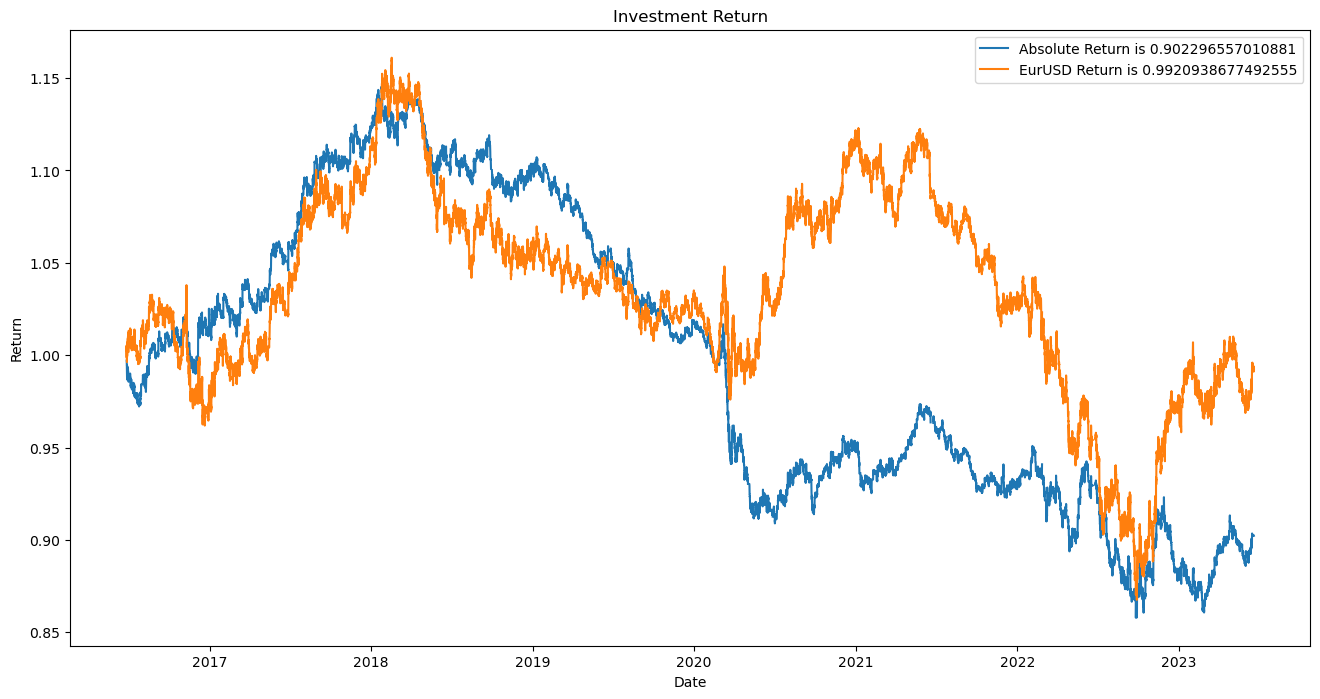

Maximum Drawdown: -0.2511524671010966


EurUSD_return  investment_return
count   42930.000000       42928.000000
mean        1.035284           0.996619
std         0.053783           0.079383
min         0.867599           0.857907
25%         1.000082           0.930757
50%         1.034960           0.998057
75%         1.075276           1.075165
max         1.161048           1.145636

In [99]:
trade_macd_411('1h')

In [100]:
# Plot returns
# What are these underscores?

#_ = plt.figure(figsize=(16,8))
#_ = plt.plot(EurUSD_1h_411['EurUSD_return'], label="EurUSD Return is " + str(EurUSD_1h_411['EurUSD_return'][-1]))
#_ = plt.plot(EurUSD_1h_411['investment_return'], label="Absolute Return is " + str(EurUSD_1h_411['investment_return'][-1]))
#_ = plt.ylabel("Return")
#_ = plt.xlabel('Date')
#_ = plt.title("Investment Return")
#_ = plt.legend()
#_ = plt.show()


### 4h

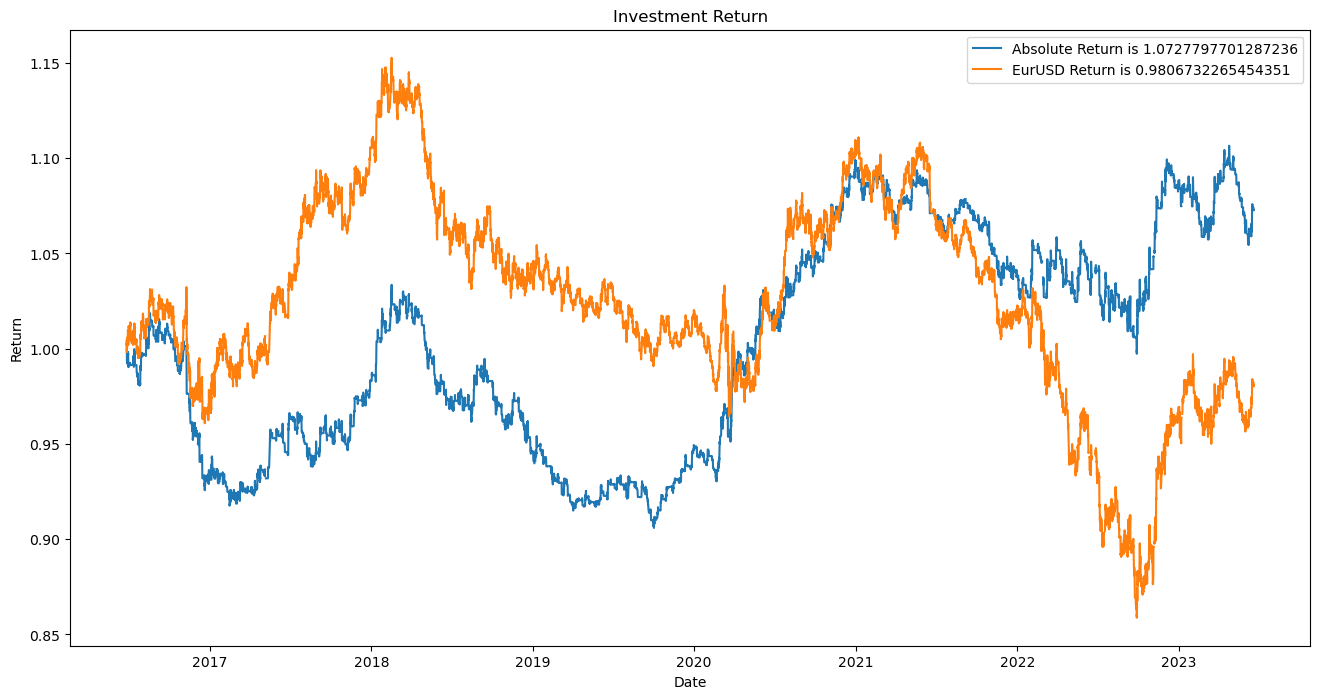

Maximum Drawdown: -0.12347224166250713


EurUSD_return  investment_return
count   11102.000000       11100.000000
mean        1.024757           1.002459
std         0.053628           0.056239
min         0.858780           0.905927
25%         0.992366           0.950606
50%         1.022894           1.005333
75%         1.064307           1.051386
max         1.152738           1.106546

In [101]:
trade_macd_411('4h')

### 1d

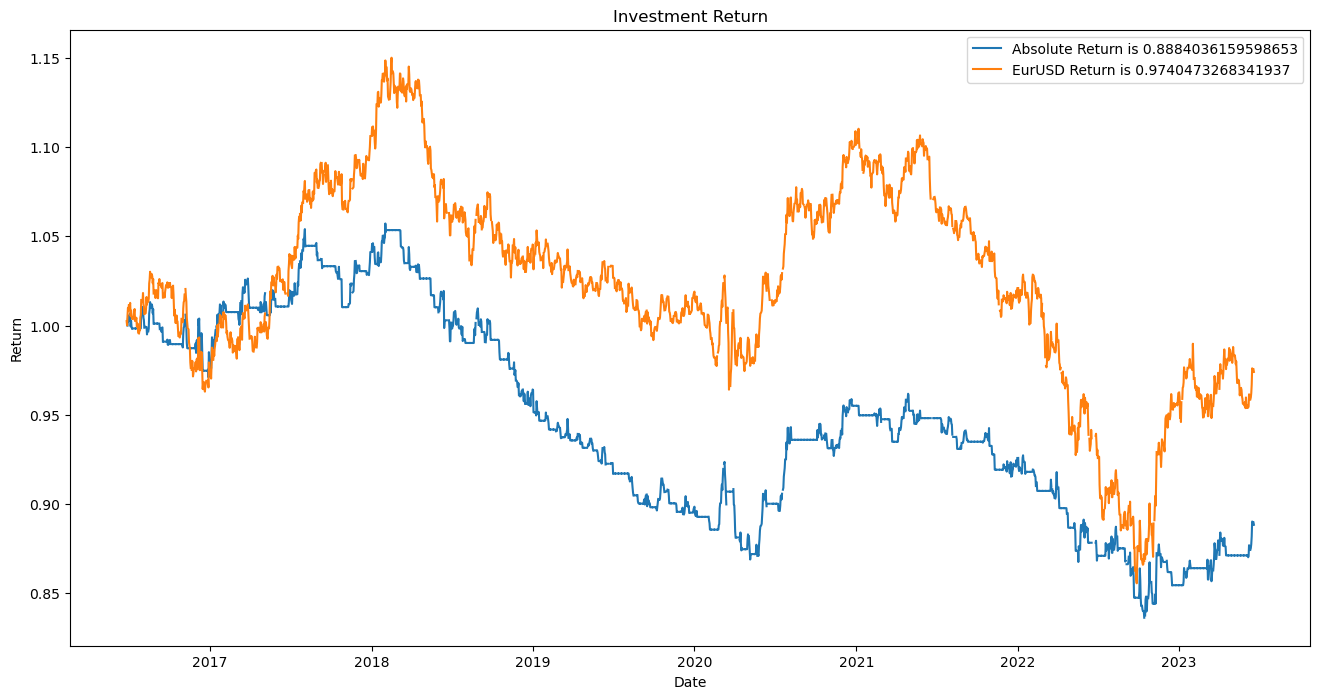

Maximum Drawdown: -0.20890491403552636


EurUSD_return  investment_return
count    2157.000000        2155.000000
mean        1.023700           0.945458
std         0.055259           0.056161
min         0.855628           0.836340
25%         0.992214           0.900194
50%         1.023119           0.937437
75%         1.064254           0.998400
max         1.150059           1.057193

In [114]:
trade_macd_411('1d')

### 3d

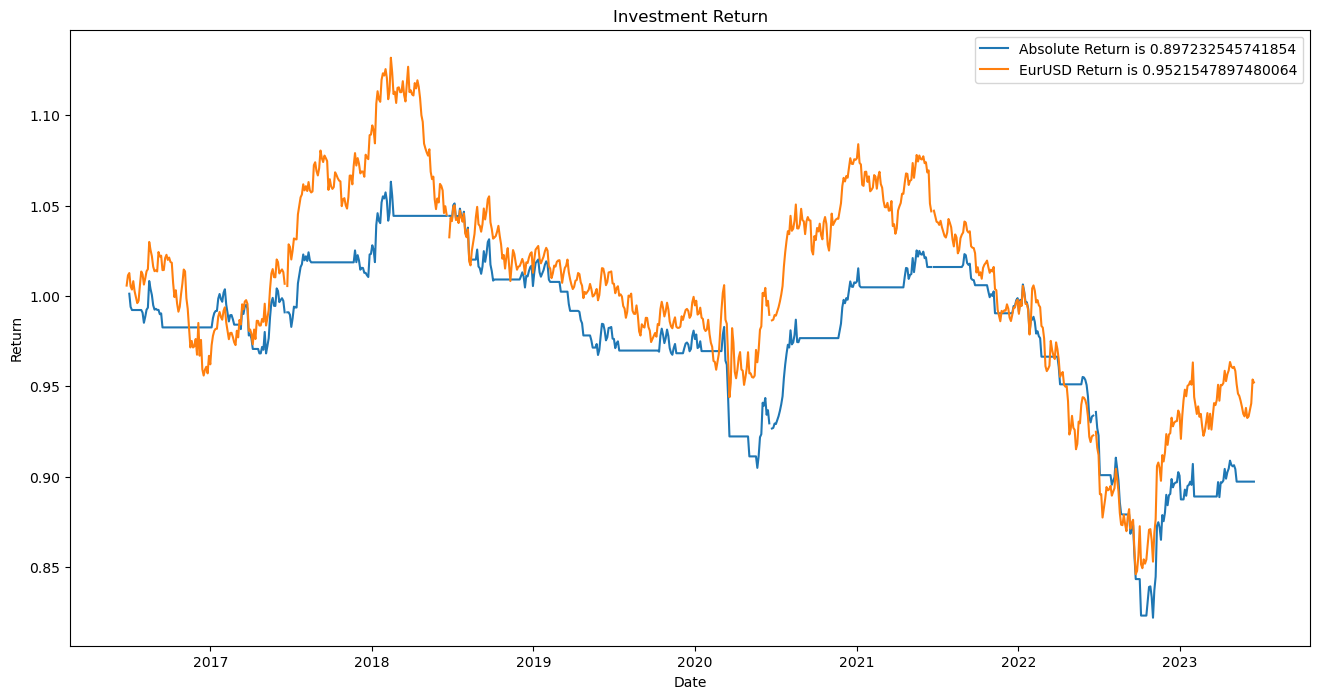

Maximum Drawdown: -0.22696991876194123


EurUSD_return  investment_return
count     845.000000         843.000000
mean        1.004901           0.978068
std         0.054634           0.047556
min         0.846010           0.821911
25%         0.977094           0.968258
50%         1.006944           0.985555
75%         1.041412           1.010586
max         1.131860           1.063233

In [113]:
trade_macd_411('3d')

### 4.1.2 MACD Difference Over Signal <a id='4_1_2'></a>
- "The intuition is from the fact that when there is too much difference between MACD and signal, the asset is considered overbought. We want to create a method that will buy only when the difference is relatively small and negative." - Frank

In [115]:
def trade_macd_412(timeframe):
    df_name = f'EurUSD_{timeframe}' 
    df = globals()[df_name].copy()
    df['macd_signal_diff'] = (df['MACD'] - df['Signal Line']) / df['Signal Line']

    df['pre_position'] = np.where(df['macd_signal_diff'] > 0.3, 1, 0)

    df['position'] = df['pre_position'].shift(1)
    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp) 

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.plot(df['EurUSD_return'], label="EurUSD Return is " + str(df['EurUSD_return'][-1]))
    
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]

### 1h

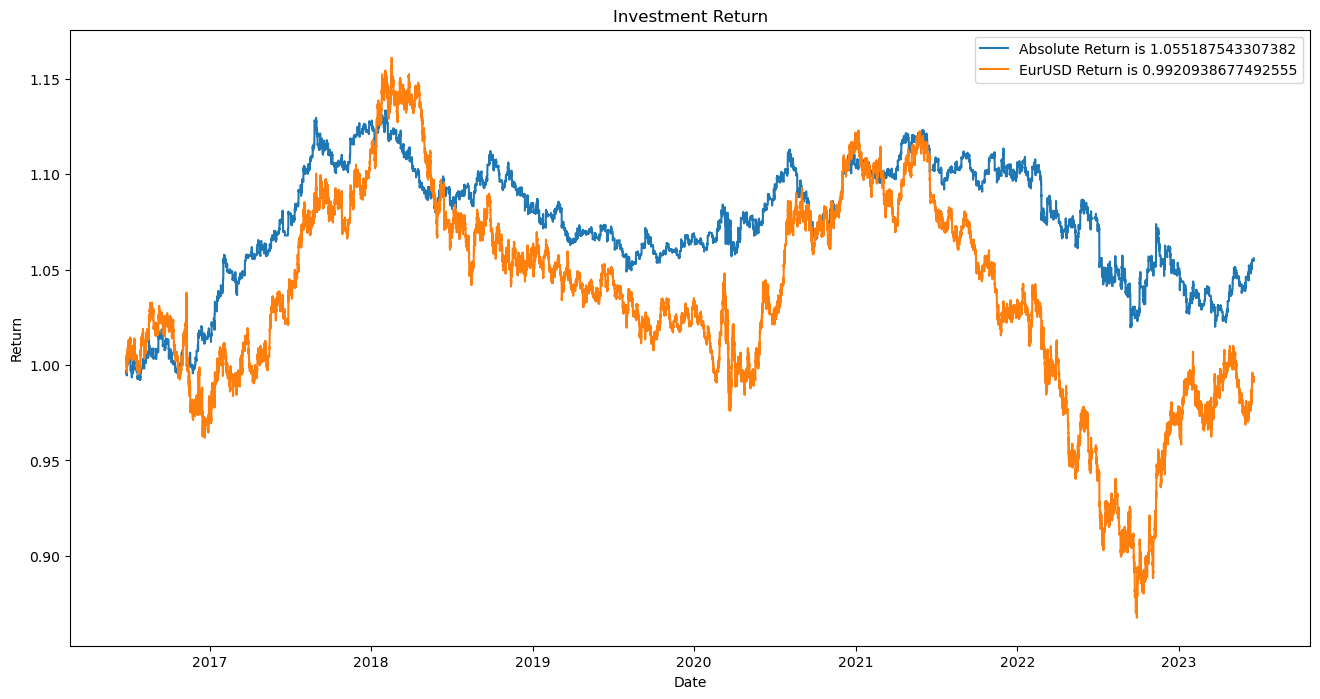

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361           0.997067
2016-06-27 00:00:00+00:00       0.999846           0.994566
2016-06-27 01:00:00+00:00       0.998702           0.994566
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           1.055188
2023-06-19 20:00:00+00:00       0.992003           1.055188
2023-06-19 21:00:00+00:00       0.992030           1.055188
2023-06-19 22:00:00+00:00       0.992030           1.055188
2023-06-19 23:00:00+00:00       0.992094           1.055188

[61179 rows x 2 columns]

In [116]:
trade_macd_412('1h')

### 4h

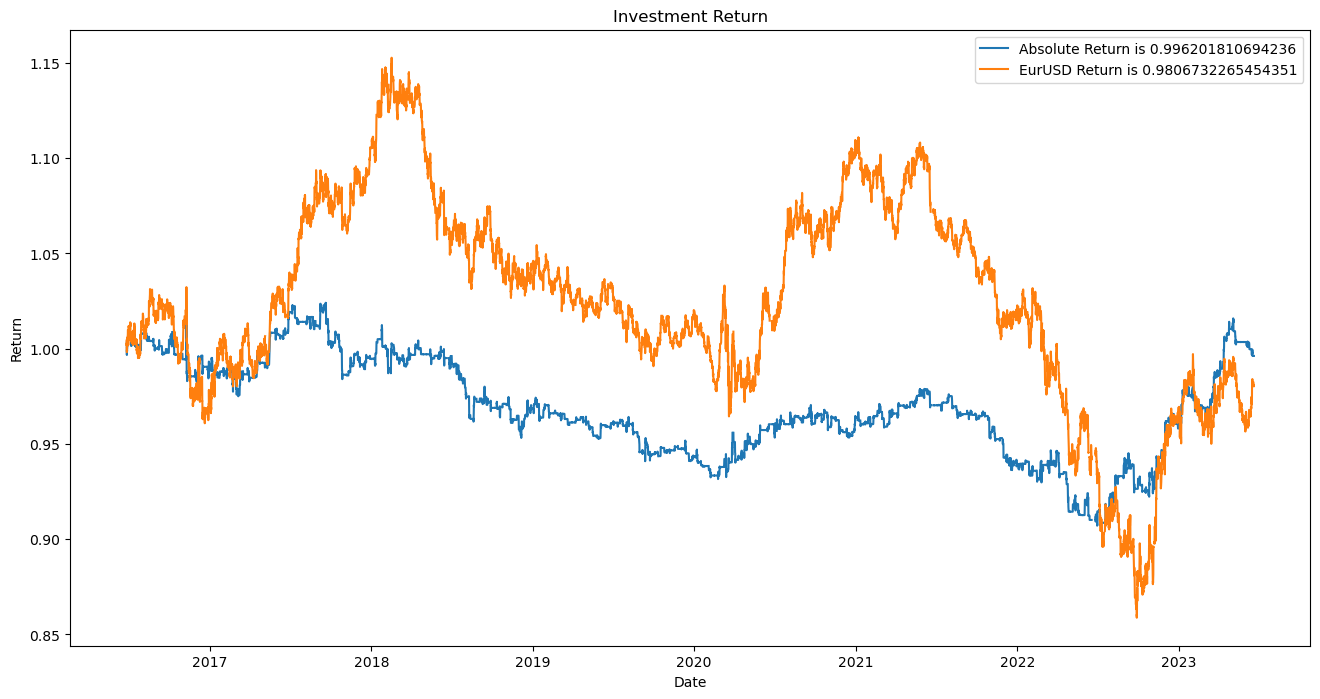

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713           1.003195
2016-06-27 08:00:00+00:00       0.998211           0.996704
2016-06-27 12:00:00+00:00       1.000845           0.999333
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.996202
2023-06-19 08:00:00+00:00       0.980494           0.996202
2023-06-19 12:00:00+00:00       0.980530           0.996202
2023-06-19 16:00:00+00:00       0.980206           0.996202
2023-06-19 20:00:00+00:00       0.980673           0.996202

[15295 rows x 2 columns]

In [117]:
trade_macd_412('4h')

### 1d

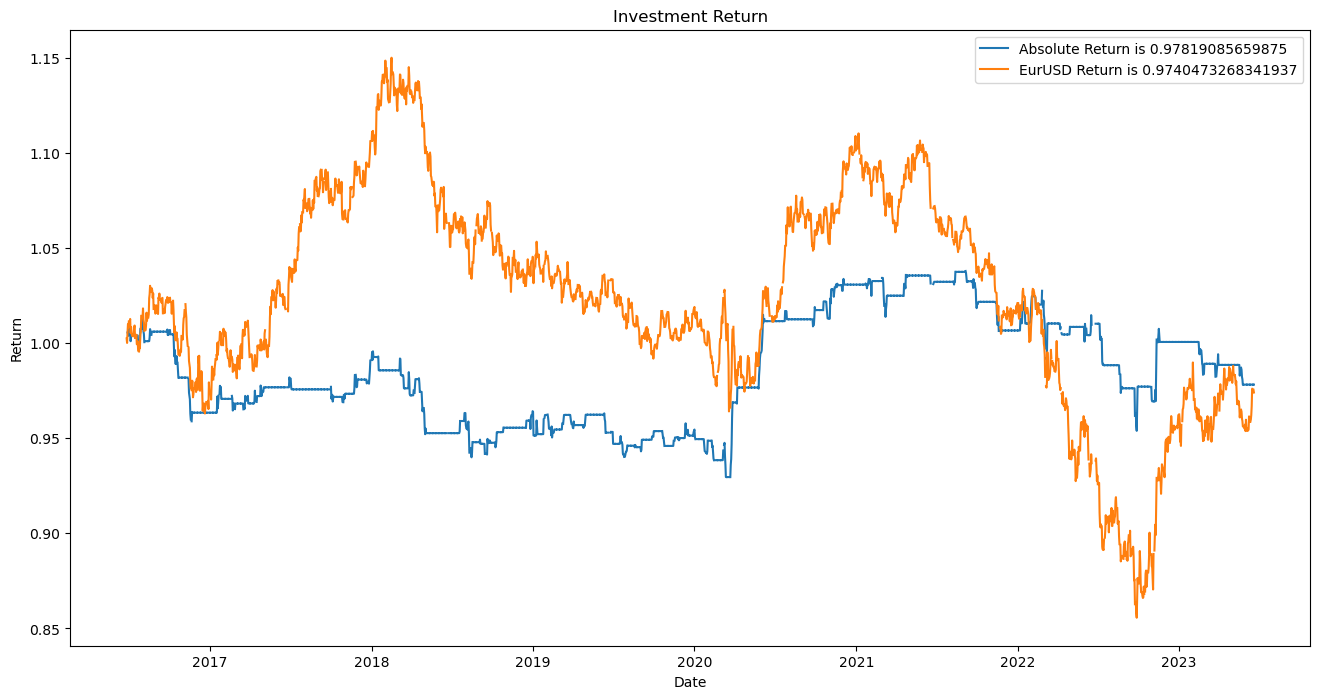

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748           1.005582
2016-06-29 00:00:00+00:00       1.009943           1.005582
2016-06-30 00:00:00+00:00       1.008173           1.003837
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           0.978191
2023-06-16 00:00:00+00:00       0.975706           0.978191
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           0.978191
2023-06-19 00:00:00+00:00       0.974047           0.978191

[2550 rows x 2 columns]

In [118]:
trade_macd_412('1d')

### 3d

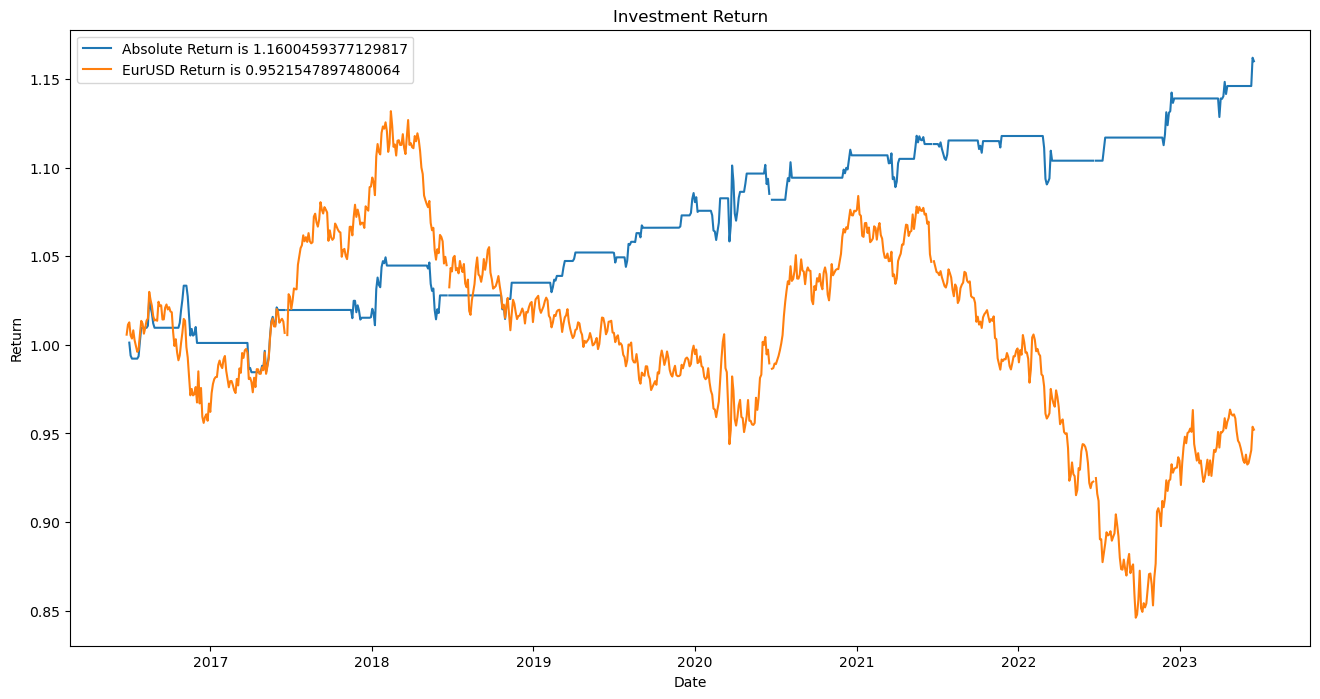

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677           1.001245
2016-07-05 00:00:00+00:00       1.005290           0.993941
2016-07-08 00:00:00+00:00       1.003545           0.992216
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           1.146060
2023-06-08 00:00:00+00:00       0.937022           1.146060
2023-06-11 00:00:00+00:00       0.940544           1.146060
2023-06-14 00:00:00+00:00       0.953776           1.162021
2023-06-17 00:00:00+00:00       0.952155           1.160046

[850 rows x 2 columns]

In [119]:
trade_macd_412('3d')

### 4.1.3 MACD Conditioned Bollinger Momentum <a id='4_1_3'></a>
- Enter when MACD price is higher than bollinger position. Bollinger Position set to 1.7 as default

In [122]:
def trade_macd_413(timeframe, n_std=1.7):
    df_name = f'EurUSD_{timeframe}' 
    df = globals()[df_name].copy()
    df['macd_signal'] = np.where(df['MACD'] > df['Signal Line'], 1, 0)
    df['macd_position'] = df['macd_signal'].shift(1)

    df = add_bollinger_bands(df, 'close', n_std=n_std)

    df['higher_than_bollinger'] = np.where(df['close'] > df[f'bollinger_close_upper_{n_std}'], 1, 0)
    df['bollinger_position'] = df['higher_than_bollinger'].shift(1)

    df['position'] = df['macd_position'] * df['bollinger_position']
    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp) 

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]

### 1h

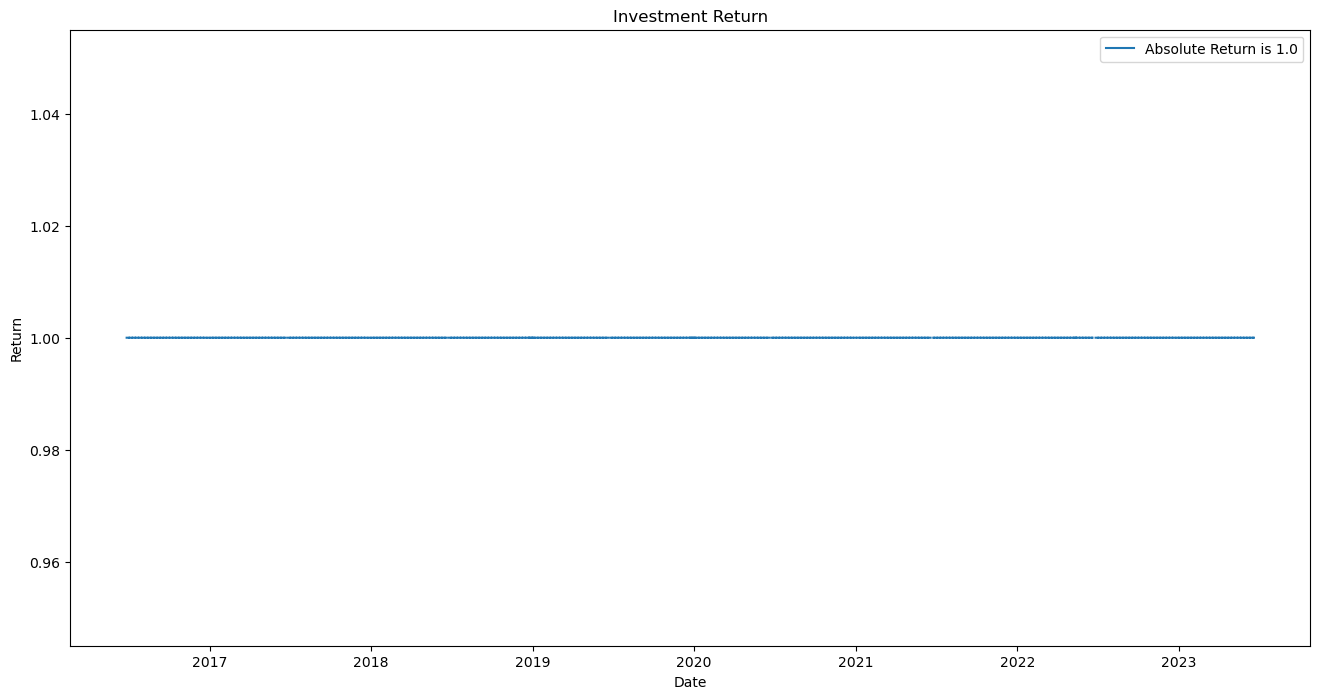

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361                1.0
2016-06-27 00:00:00+00:00       0.999846                1.0
2016-06-27 01:00:00+00:00       0.998702                1.0
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767                1.0
2023-06-19 20:00:00+00:00       0.992003                1.0
2023-06-19 21:00:00+00:00       0.992030                1.0
2023-06-19 22:00:00+00:00       0.992030                1.0
2023-06-19 23:00:00+00:00       0.992094                1.0

[61179 rows x 2 columns]

In [123]:
trade_macd_413('1h', 1.7)

### 4h

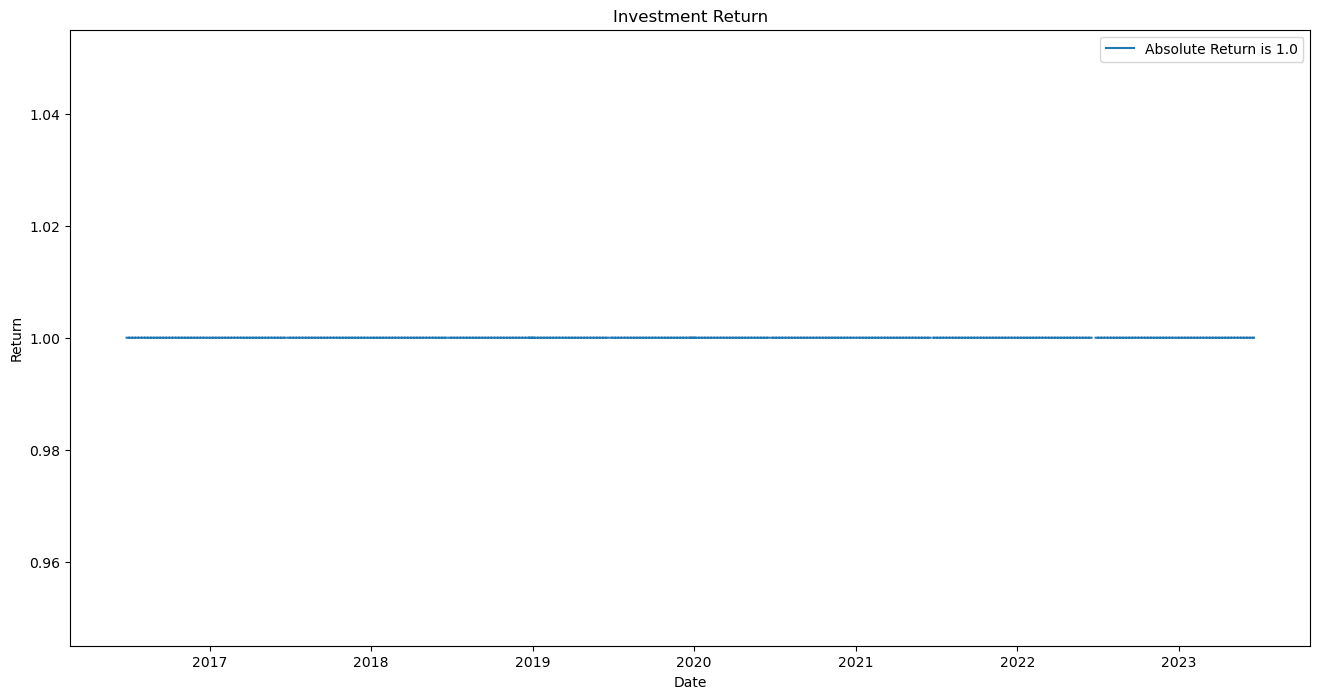

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713                1.0
2016-06-27 08:00:00+00:00       0.998211                1.0
2016-06-27 12:00:00+00:00       1.000845                1.0
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212                1.0
2023-06-19 08:00:00+00:00       0.980494                1.0
2023-06-19 12:00:00+00:00       0.980530                1.0
2023-06-19 16:00:00+00:00       0.980206                1.0
2023-06-19 20:00:00+00:00       0.980673                1.0

[15295 rows x 2 columns]

In [124]:
trade_macd_413('4h', 1.7)

### 1d

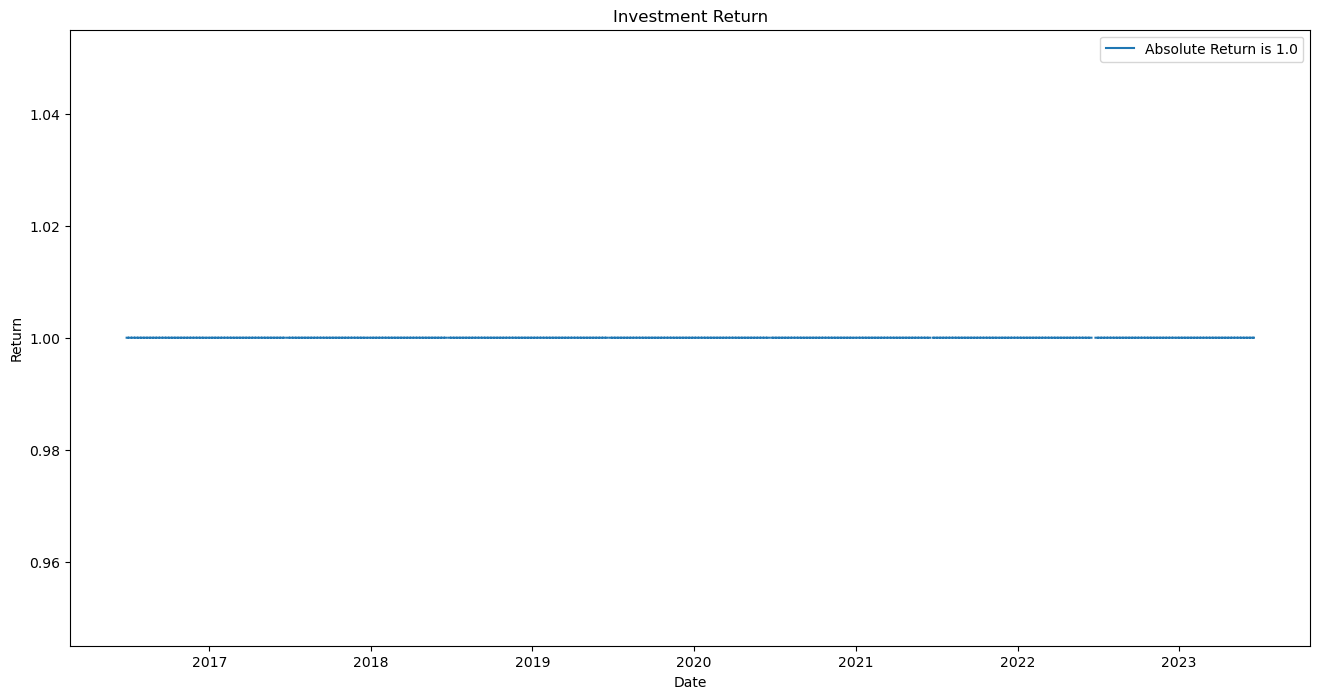

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748                1.0
2016-06-29 00:00:00+00:00       1.009943                1.0
2016-06-30 00:00:00+00:00       1.008173                1.0
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063                1.0
2023-06-16 00:00:00+00:00       0.975706                1.0
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492                1.0
2023-06-19 00:00:00+00:00       0.974047                1.0

[2550 rows x 2 columns]

In [125]:
trade_macd_413('1d', 2)

### 3d

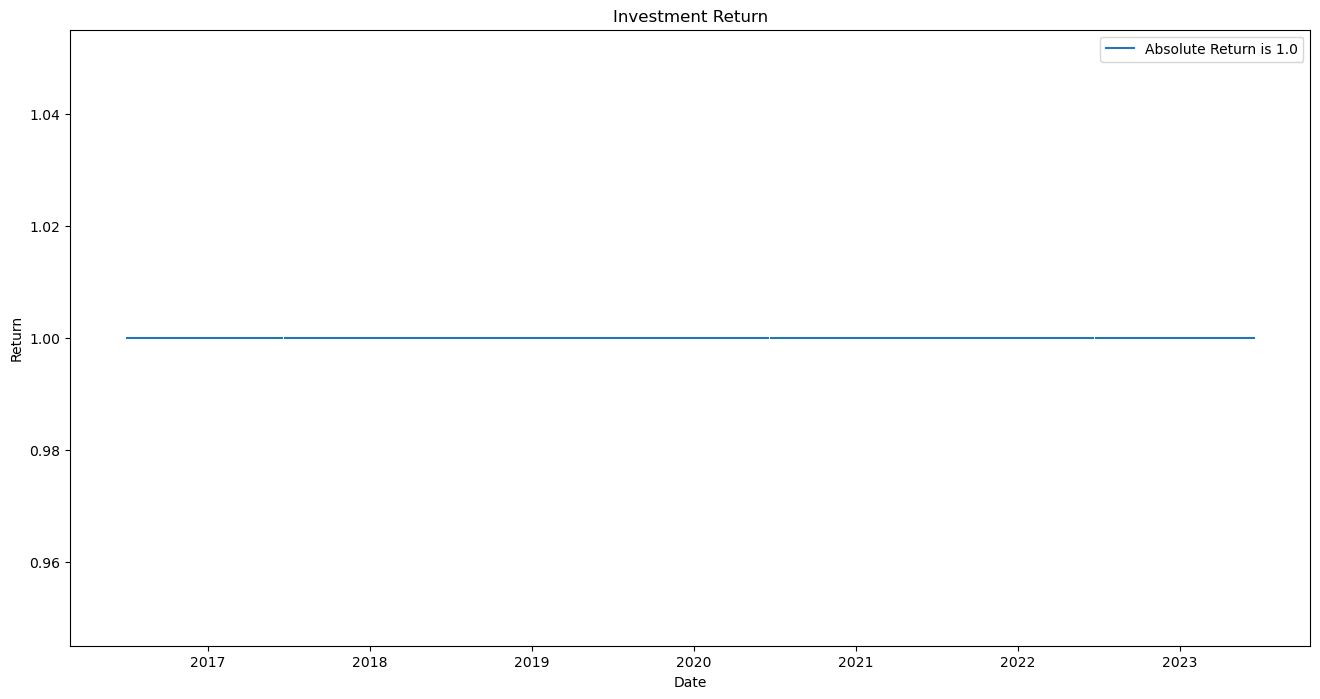

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677                1.0
2016-07-05 00:00:00+00:00       1.005290                1.0
2016-07-08 00:00:00+00:00       1.003545                1.0
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326                1.0
2023-06-08 00:00:00+00:00       0.937022                1.0
2023-06-11 00:00:00+00:00       0.940544                1.0
2023-06-14 00:00:00+00:00       0.953776                1.0
2023-06-17 00:00:00+00:00       0.952155                1.0

[850 rows x 2 columns]

In [126]:
trade_macd_413('3d', 2)

## 4.2 Heiken Ashi <a id='4_2'></a>
- Candle based trading
- Strategies all tested on bitcoin through Frank's nb, now transferred to Test Eur/USD

### 4.2.1 Heiken Ashi Consecutive Candles <a id='4_2_1'></a>
- We enter when the bar is different from the previous bar, and we have no wick for this bar.
- We exist if the close is smaller than the previous close

--Note from Andrew: I'm assuming theres 3 candles, and .66 means 2/3 are green and 1 means 3/3 are green


In [222]:
def trade_candle_421(timeframe, thresh_val):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df['ha_candle'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df = add_simple_moving_average(df, 'ha_candle', 3)

    if thresh_val == 0.66:
        df['pre_position_bigger'] = np.where(df['ha_candle_sma_3'] >= thresh_val, 1, 0)
        df['pre_position_smaller'] = np.where(df['ha_candle_sma_3'] <= 0.67, 1, 0)
        df['pre_position'] = df['pre_position_bigger'] * df['pre_position_smaller']
    else:
        df['pre_position'] = np.where(df['ha_candle_sma_3'] == thresh_val, 1, 0)

    df['position'] = df['pre_position'].shift()
    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)
    
    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]

#### 1h

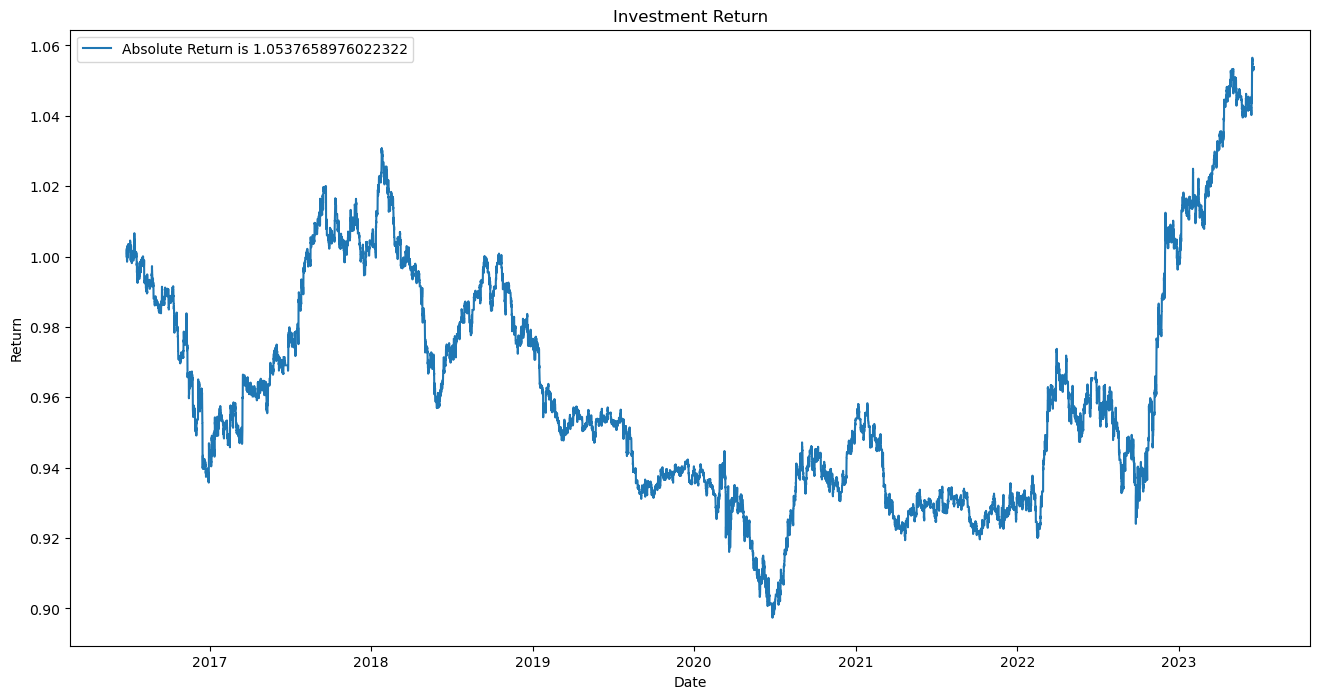

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361           1.000000
2016-06-27 00:00:00+00:00       0.999846           1.000000
2016-06-27 01:00:00+00:00       0.998702           1.000000
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           1.053518
2023-06-19 20:00:00+00:00       0.992003           1.053766
2023-06-19 21:00:00+00:00       0.992030           1.053766
2023-06-19 22:00:00+00:00       0.992030           1.053766
2023-06-19 23:00:00+00:00       0.992094           1.053766

[61179 rows x 2 columns]

In [223]:
trade_candle_421('1h', 0.66)

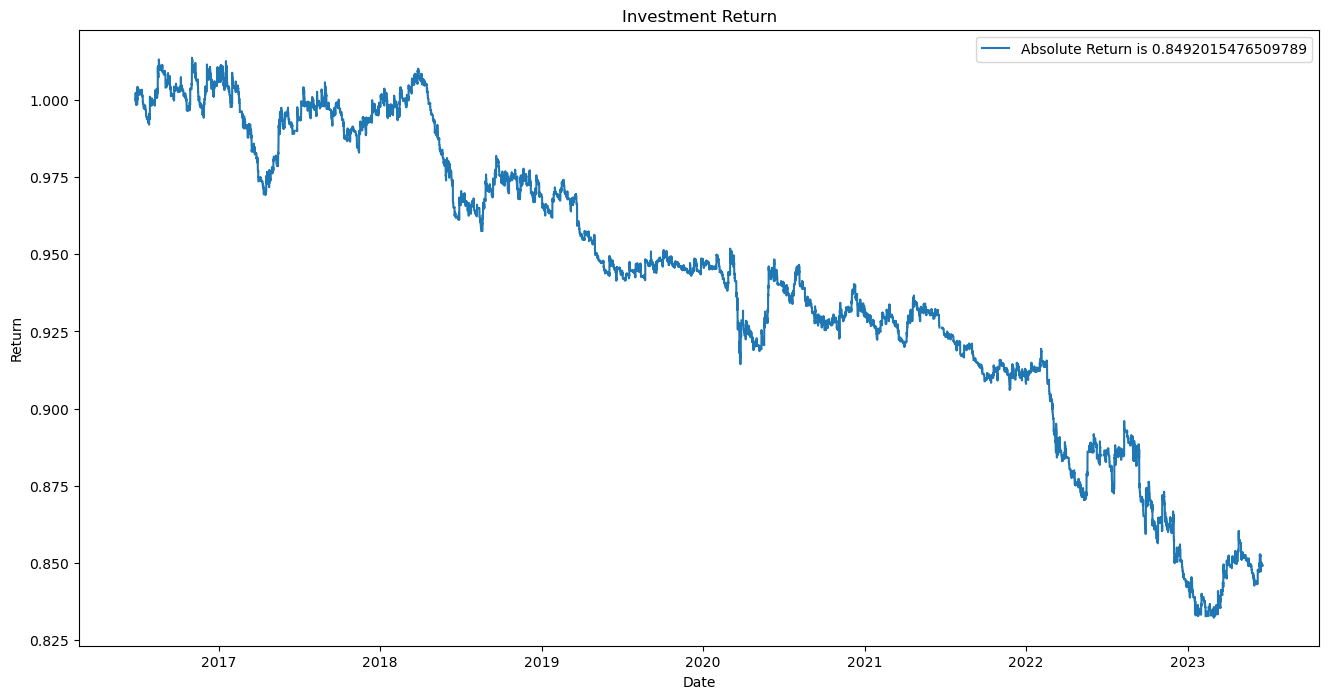

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361           1.000000
2016-06-27 00:00:00+00:00       0.999846           1.000000
2016-06-27 01:00:00+00:00       0.998702           1.000000
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           0.849124
2023-06-19 20:00:00+00:00       0.992003           0.849124
2023-06-19 21:00:00+00:00       0.992030           0.849147
2023-06-19 22:00:00+00:00       0.992030           0.849147
2023-06-19 23:00:00+00:00       0.992094           0.849202

[61179 rows x 2 columns]

In [224]:
trade_candle_421('1h', 1)

#### 4h

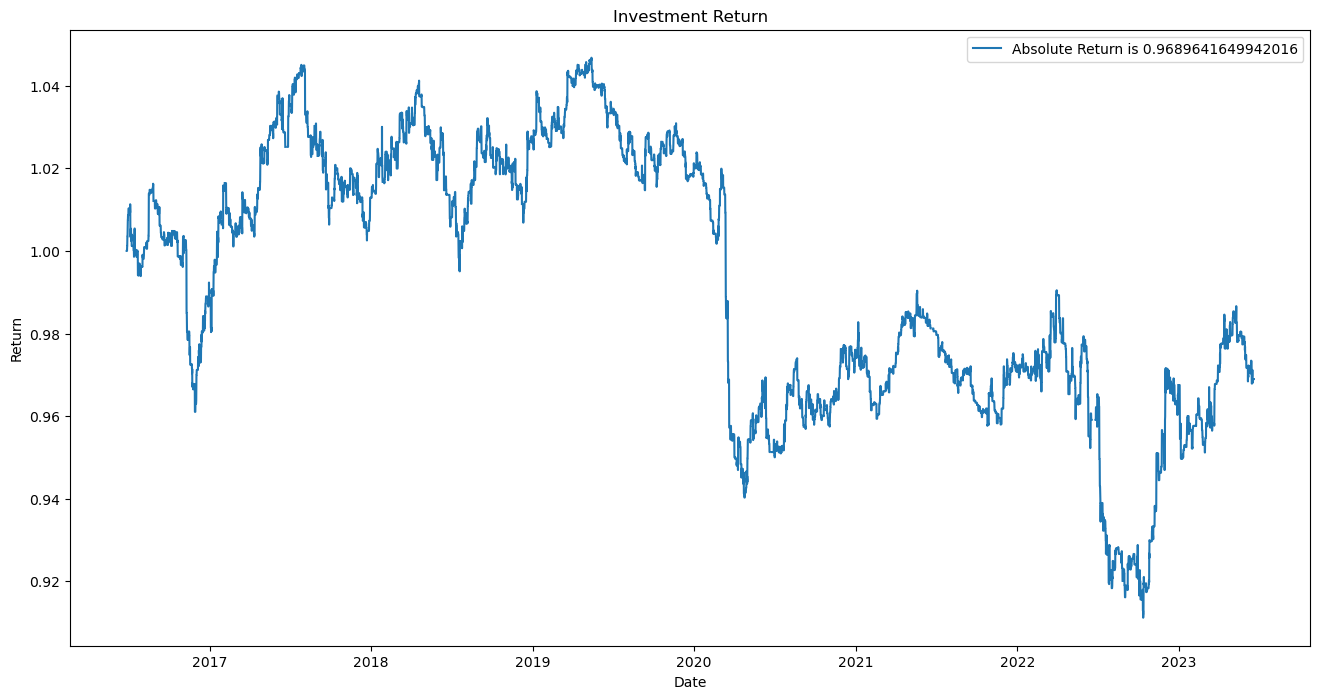

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713           1.000000
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.968964
2023-06-19 08:00:00+00:00       0.980494           0.968964
2023-06-19 12:00:00+00:00       0.980530           0.968964
2023-06-19 16:00:00+00:00       0.980206           0.968964
2023-06-19 20:00:00+00:00       0.980673           0.968964

[15295 rows x 2 columns]

In [225]:
trade_candle_421('4h', 0.66)

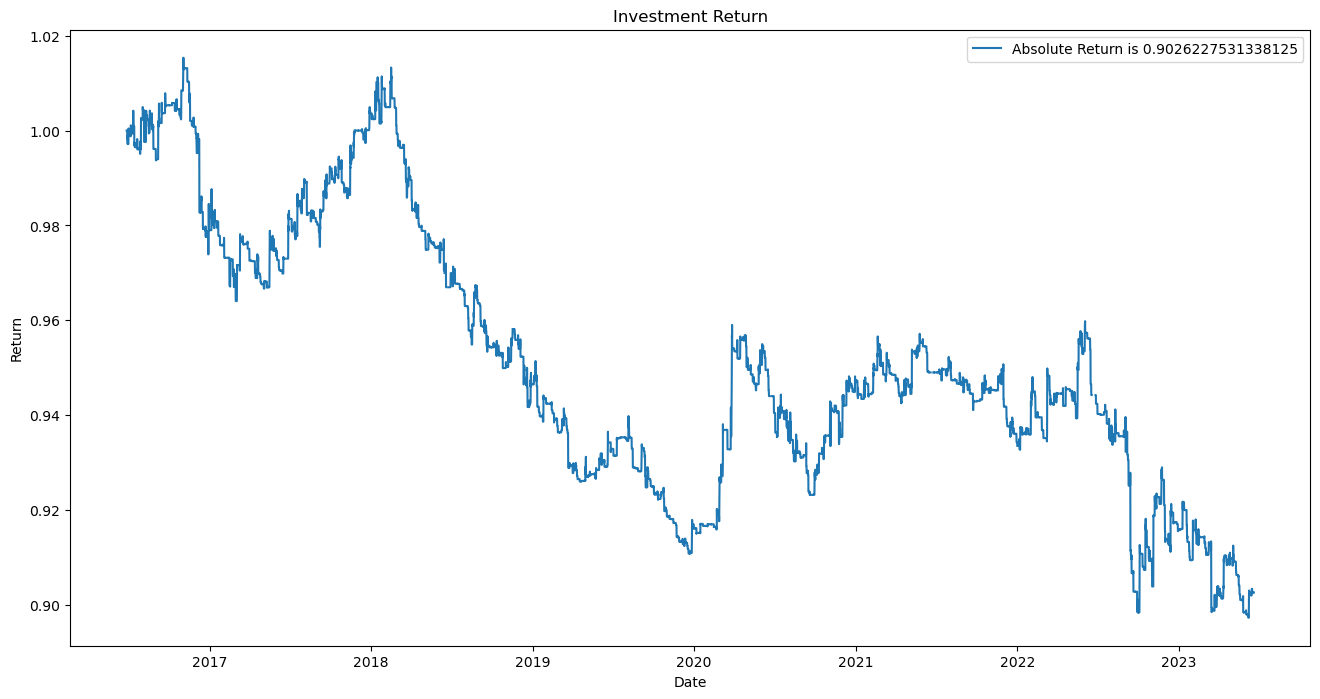

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713           1.000000
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.902623
2023-06-19 08:00:00+00:00       0.980494           0.902623
2023-06-19 12:00:00+00:00       0.980530           0.902623
2023-06-19 16:00:00+00:00       0.980206           0.902623
2023-06-19 20:00:00+00:00       0.980673           0.902623

[15295 rows x 2 columns]

In [226]:
trade_candle_421('4h', 1)

#### 1d

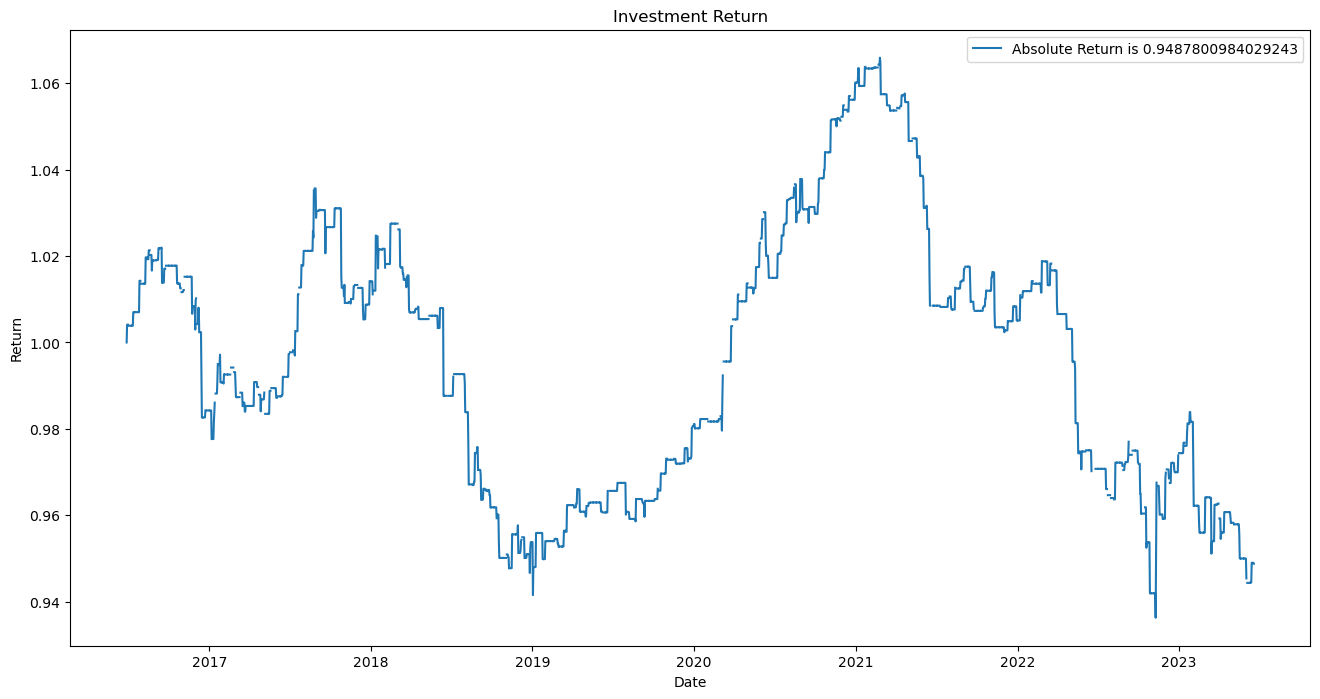

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748           1.000000
2016-06-29 00:00:00+00:00       1.009943           1.004129
2016-06-30 00:00:00+00:00       1.008173           1.004129
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           0.948986
2023-06-16 00:00:00+00:00       0.975706           0.948986
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           0.948780
2023-06-19 00:00:00+00:00       0.974047           0.948780

[2550 rows x 2 columns]

In [227]:
trade_candle_421('1d', 0.66)

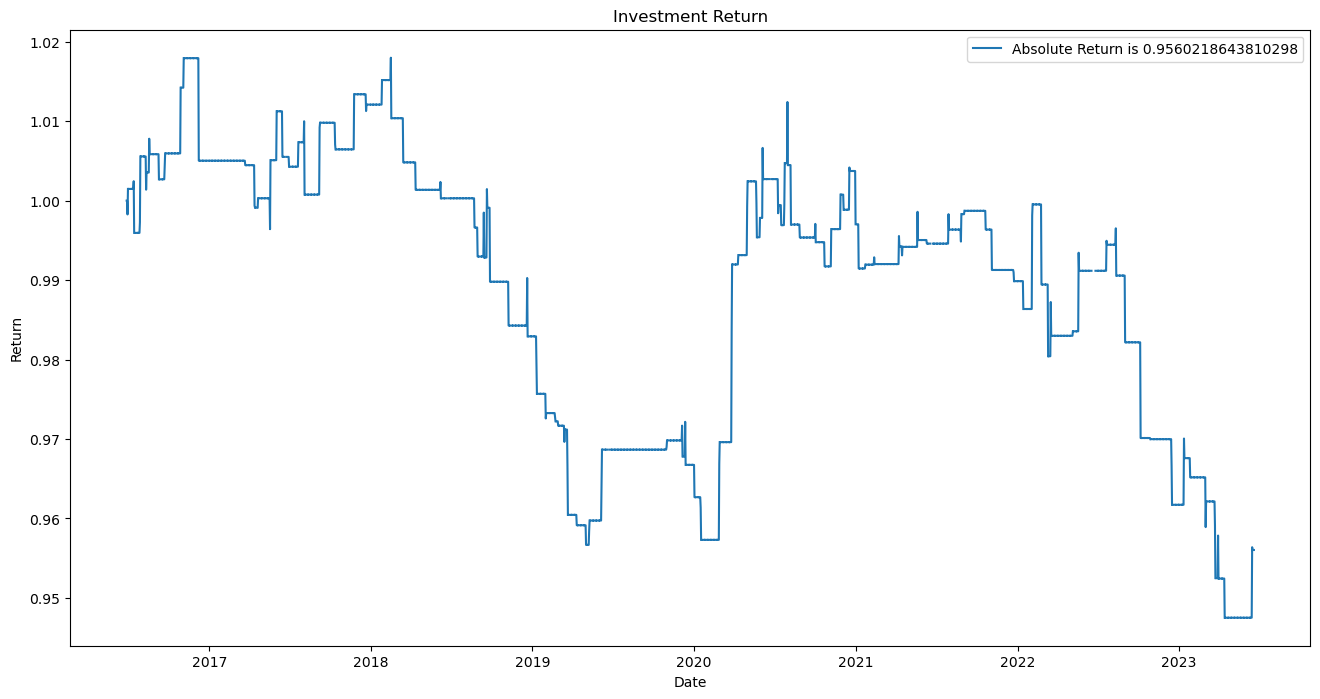

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748           1.000000
2016-06-29 00:00:00+00:00       1.009943           1.000000
2016-06-30 00:00:00+00:00       1.008173           0.998264
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           0.956371
2023-06-16 00:00:00+00:00       0.975706           0.956022
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           0.956022
2023-06-19 00:00:00+00:00       0.974047           0.956022

[2550 rows x 2 columns]

In [228]:
trade_candle_421('1d', 1)

#### 3d

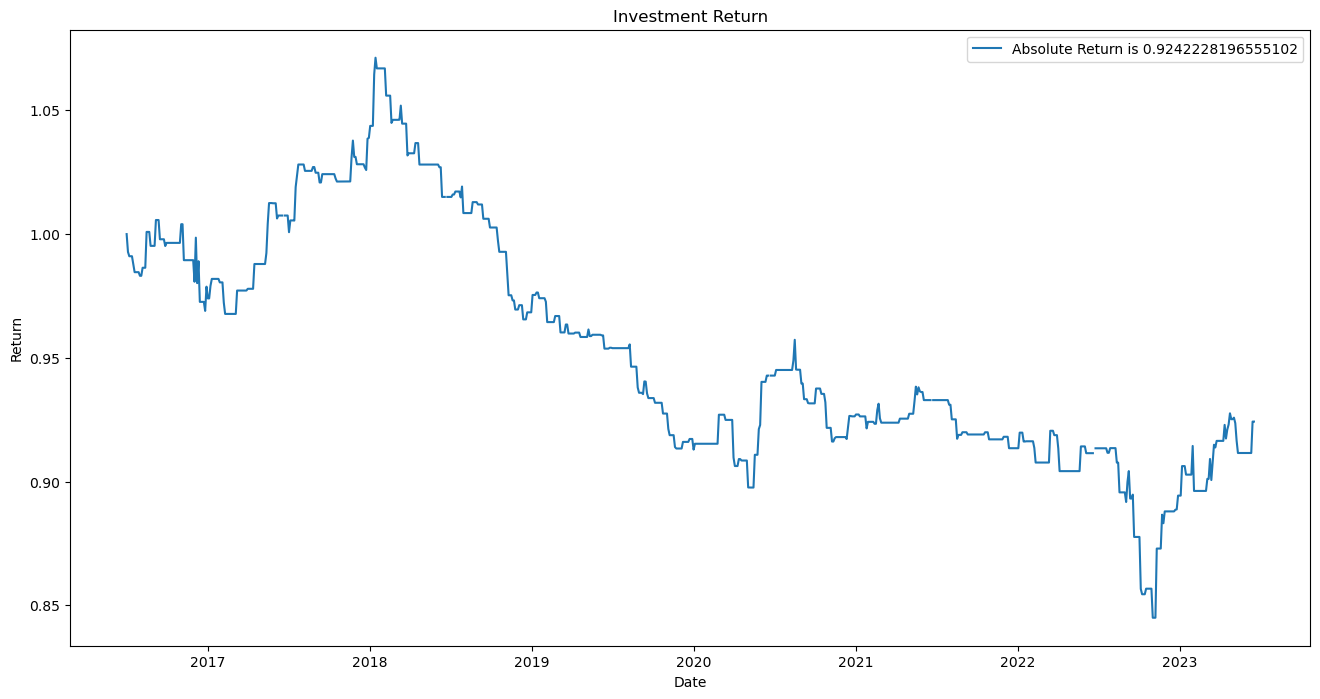

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677           1.000000
2016-07-05 00:00:00+00:00       1.005290           0.992778
2016-07-08 00:00:00+00:00       1.003545           0.991055
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           0.911528
2023-06-08 00:00:00+00:00       0.937022           0.911528
2023-06-11 00:00:00+00:00       0.940544           0.911528
2023-06-14 00:00:00+00:00       0.953776           0.924223
2023-06-17 00:00:00+00:00       0.952155           0.924223

[850 rows x 2 columns]

In [229]:
trade_candle_421('3d', 0.66)

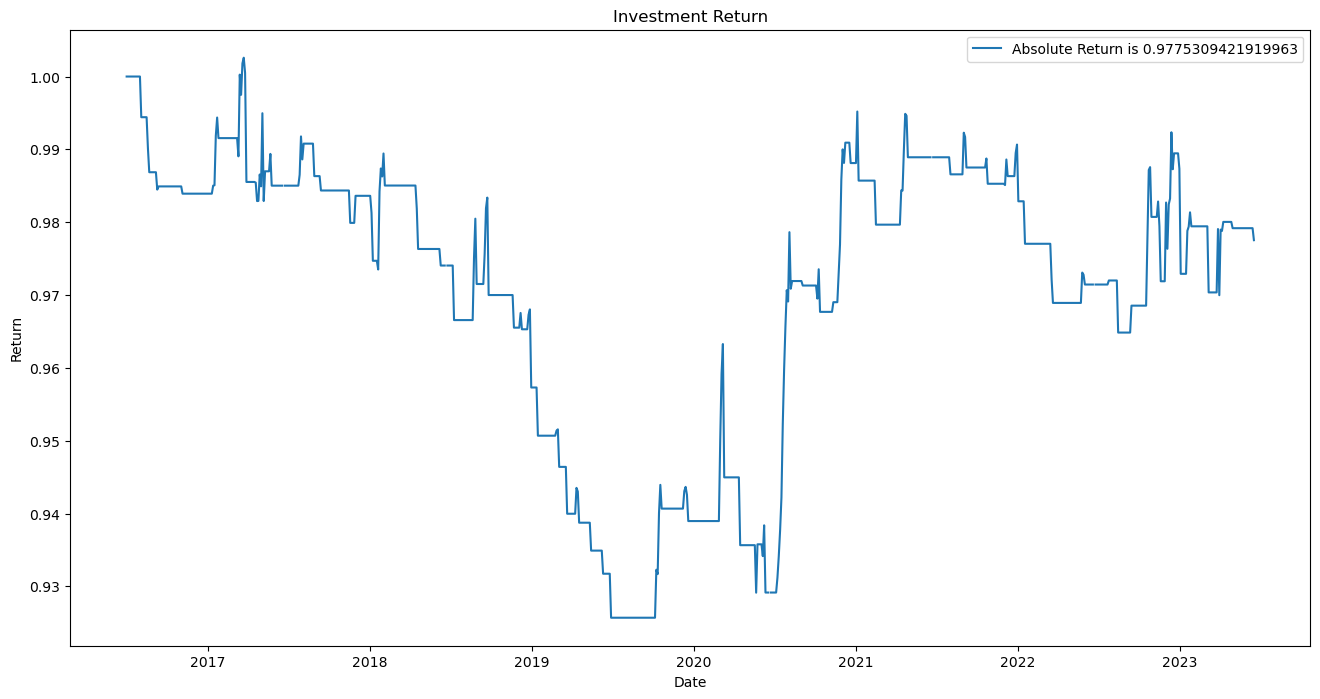

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677           1.000000
2016-07-05 00:00:00+00:00       1.005290           1.000000
2016-07-08 00:00:00+00:00       1.003545           1.000000
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           0.979179
2023-06-08 00:00:00+00:00       0.937022           0.979179
2023-06-11 00:00:00+00:00       0.940544           0.979179
2023-06-14 00:00:00+00:00       0.953776           0.979179
2023-06-17 00:00:00+00:00       0.952155           0.977531

[850 rows x 2 columns]

In [230]:
trade_candle_421('3d', 1)

### 4.2.2 Heiken Ashi No Last Wick <a id='4_2_2'></a>
- The intuition of this trading strategy is from video (https://youtu.be/2G78zkuQSc0)
- We buy when the heikin ashi candle is different from the previous candle and there is no last wick (aka the the low price is the same as the opening price)

--Frank

Note from Andrew: I will develop these for shorter time interval like 5 mins, more for day trading?


In [ ]:
def heikin_ashi_test(df):    #what are these for?
    data = df.copy()
    
    actual_position = []
    above_count = 0
    below_count = 0
    previous_position = 0 
    for i, (t, row) in enumerate(data.iterrows()):
        if previous_position == 0:
            count = 0
            # Buy if indicator to higher low and price to lower low
            if row['close_ema_3_lows'] == -1 and row['RSI_lows'] == 1:
                if row['RSI'] < 25:
                    actual_position.append(1)
                    previous_position = 1
                    continue
                else:
                    actual_position.append(0)
                    previous_position = 0
                    continue
            else:
                actual_position.append(0)
                previous_position = 0
        # If current position is long
        elif previous_position == 1:

            if row['RSI'] > 80:
                above_count = above_count + 1
                if above_count >= 15:
                    actual_position.append(0)
                    previous_position = 0
                    continue
                actual_position.append(1)
                previous_position = 1
                continue
            elif row['RSI'] <= 50:  
                if below_count >= 10:
                    actual_position.append(0)
                    previous_position = 0
                    continue
                actual_position.append(1)
                previous_position = 1
            else:
                actual_position.append(1)
                previous_position = 1
                below_count = 0
                above_count = 0


    
    print(len(actual_position))
    data['position'] = actual_position
    return data

In [ ]:
def calcRSI(df, P=14):    
    data = df.copy()

    data['gain'] = np.where(data['pct_return'] > 0, data['pct_return'], 0)
    data['loss'] = np.where(data['pct_return'] < 0, np.abs(data['pct_return']), 0)
    
    data[['init_avg_gain', 'init_avg_loss']] = data[['gain', 'loss']].rolling(P).mean()
    avg_gain = np.zeros(len(data))
    avg_loss = np.zeros(len(data))
    
    for i, _row in enumerate(data.iterrows()):
        row = _row[1]
        if i < P - 1:
            last_row = row.copy()
            continue
        elif i == P-1:
            avg_gain[i] += row['init_avg_gain']
            avg_loss[i] += row['init_avg_loss']
        else:
            avg_gain[i] += ((P - 1) * avg_gain[i-1] + row['gain']) / P
            avg_loss[i] += ((P - 1) * avg_loss[i-1] + row['loss']) / P

        last_row = row.copy()

    data['avg_gain'] = avg_gain
    data['avg_loss'] = avg_loss
    data['RS'] = data['avg_gain'] / data['avg_loss']
    df['RSI'] = 100 - 100 / (1 + data['RS'])
    return df

### 4.2.2.1 - Strategy 1 
- We enter when the bar is different from the previous bar, and we have no wick for this bar.
- We exit if the close is smaller than the previous close

In [141]:
def trade_candle_4221(timeframe):
    df_name = f'EurUSD_{timeframe}'  
    df = globals()[df_name].copy()

    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)
    df['ha_candle_green_difference'] = np.abs(df['ha_candle_green'] - df['ha_candle_green'].shift(1))

    df['entry'] = (df['ha_candle_green_difference'] * df['ha_candle_green_no_wick']).shift(1)

    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_close_smaller_than_previous'].shift(1) == 1, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp) 

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]


#### 1h

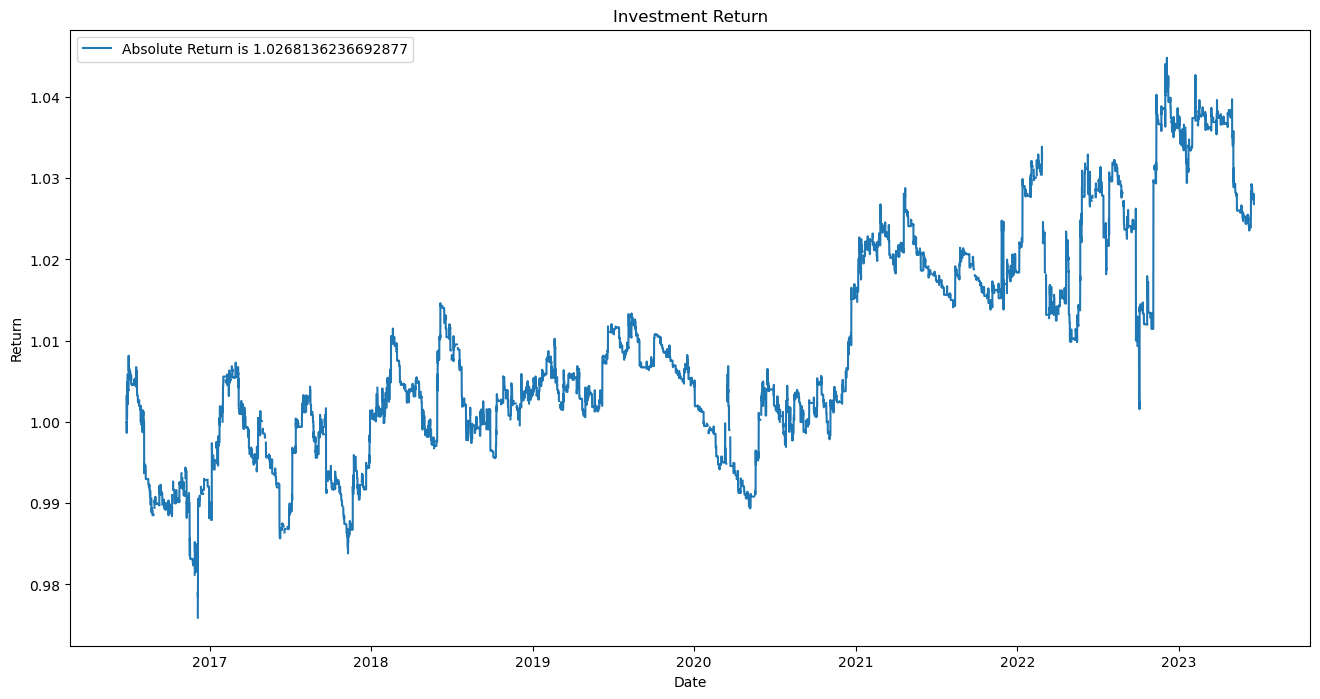

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361                NaN
2016-06-27 00:00:00+00:00       0.999846           1.000000
2016-06-27 01:00:00+00:00       0.998702           1.000000
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           1.026814
2023-06-19 20:00:00+00:00       0.992003           1.026814
2023-06-19 21:00:00+00:00       0.992030           1.026814
2023-06-19 22:00:00+00:00       0.992030           1.026814
2023-06-19 23:00:00+00:00       0.992094           1.026814

[61179 rows x 2 columns]

In [142]:
trade_candle_4221('1h')

#### 4h

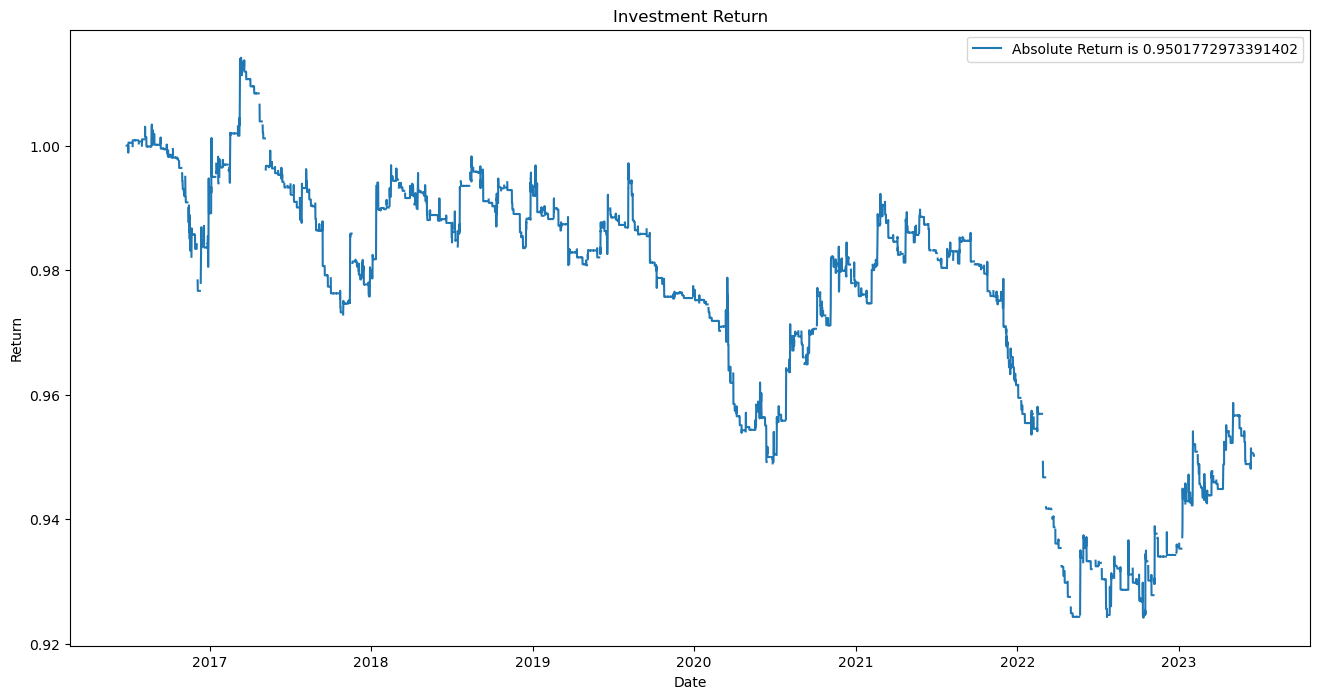

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713                NaN
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.950177
2023-06-19 08:00:00+00:00       0.980494           0.950177
2023-06-19 12:00:00+00:00       0.980530           0.950177
2023-06-19 16:00:00+00:00       0.980206           0.950177
2023-06-19 20:00:00+00:00       0.980673           0.950177

[15295 rows x 2 columns]

In [143]:
trade_candle_4221('4h')

#### 1d

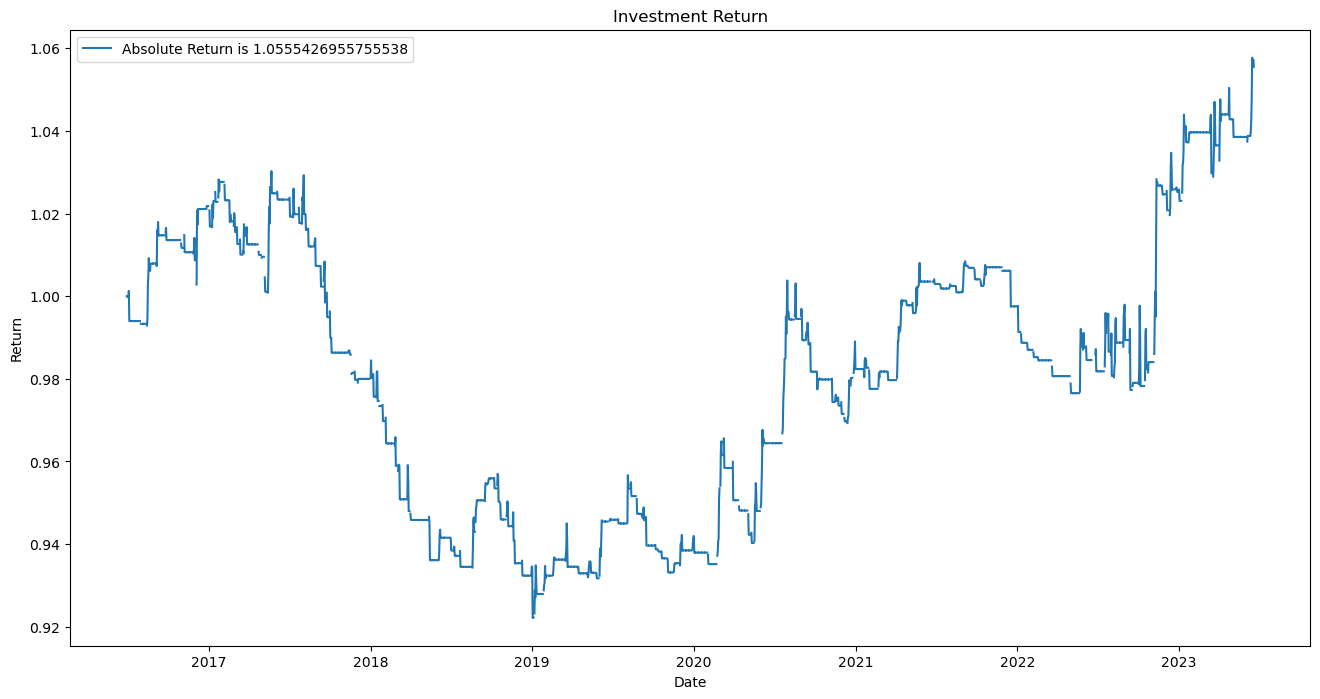

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748                NaN
2016-06-29 00:00:00+00:00       1.009943           1.000000
2016-06-30 00:00:00+00:00       1.008173           1.000000
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           1.057727
2023-06-16 00:00:00+00:00       0.975706           1.057340
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           1.057108
2023-06-19 00:00:00+00:00       0.974047           1.055543

[2550 rows x 2 columns]

In [144]:
trade_candle_4221('1d')

#### 3d

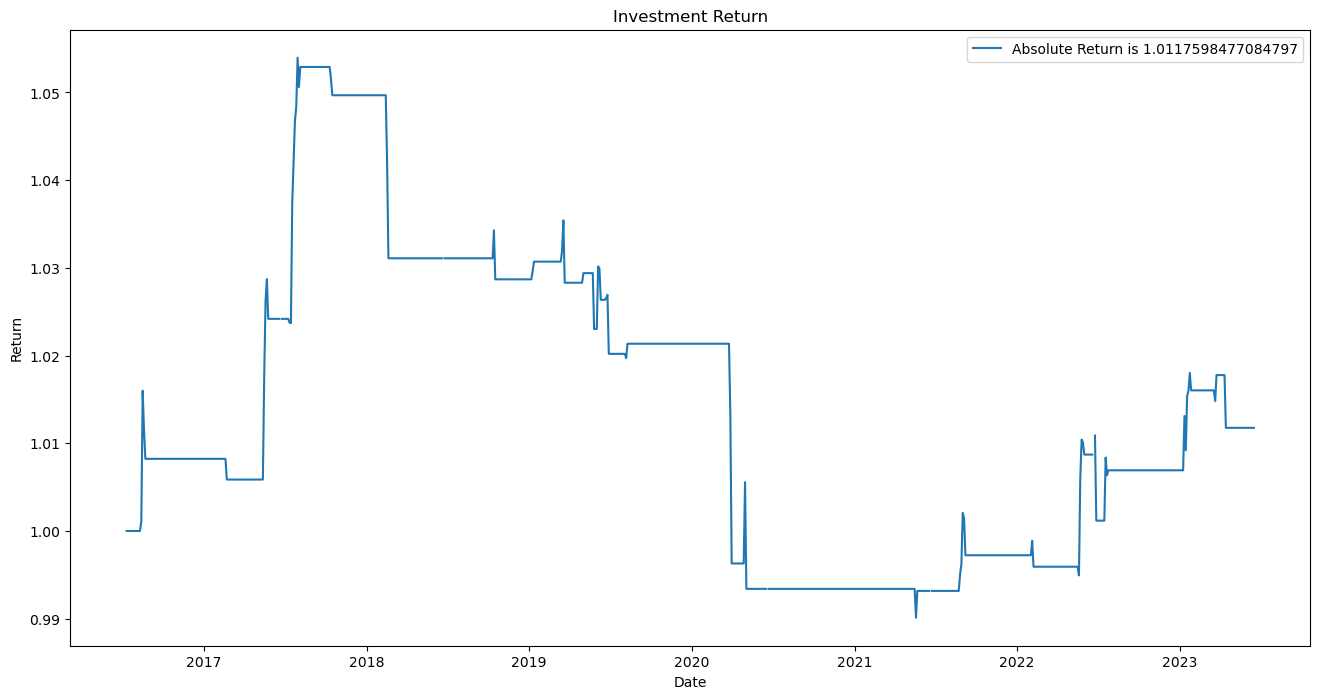

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677                NaN
2016-07-05 00:00:00+00:00       1.005290                NaN
2016-07-08 00:00:00+00:00       1.003545                NaN
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326            1.01176
2023-06-08 00:00:00+00:00       0.937022            1.01176
2023-06-11 00:00:00+00:00       0.940544            1.01176
2023-06-14 00:00:00+00:00       0.953776            1.01176
2023-06-17 00:00:00+00:00       0.952155            1.01176

[850 rows x 2 columns]

In [145]:
trade_candle_4221('3d')

### 4.2.2.2 - Strategy 2
- We enter if there is no wick for the previous bar (And it's green).
- We exist if the close is smaller than the previous close

In [147]:
def trade_candle_4222(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)
    df['ha_candle_green_difference'] = np.abs(df['ha_candle_green'] - df['ha_candle_green'].shift(1))

    df['entry'] = df['ha_candle_green_no_wick'].shift(1)

    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_close_smaller_than_previous'].shift(1) == 1, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp) 

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]


#### 1h

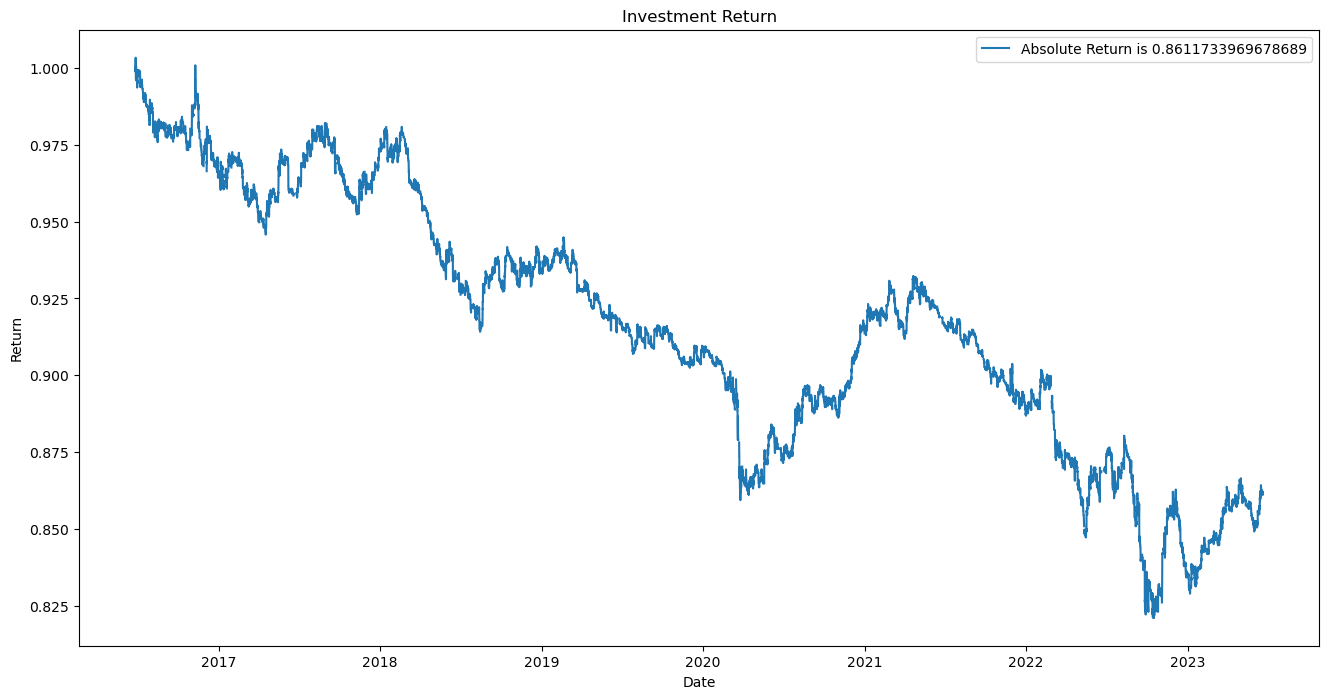

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361                NaN
2016-06-27 00:00:00+00:00       0.999846           1.000000
2016-06-27 01:00:00+00:00       0.998702           1.000000
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           0.861118
2023-06-19 20:00:00+00:00       0.992003           0.861118
2023-06-19 21:00:00+00:00       0.992030           0.861118
2023-06-19 22:00:00+00:00       0.992030           0.861118
2023-06-19 23:00:00+00:00       0.992094           0.861173

[61179 rows x 2 columns]

In [148]:
trade_candle_4222('1h')

#### 4h

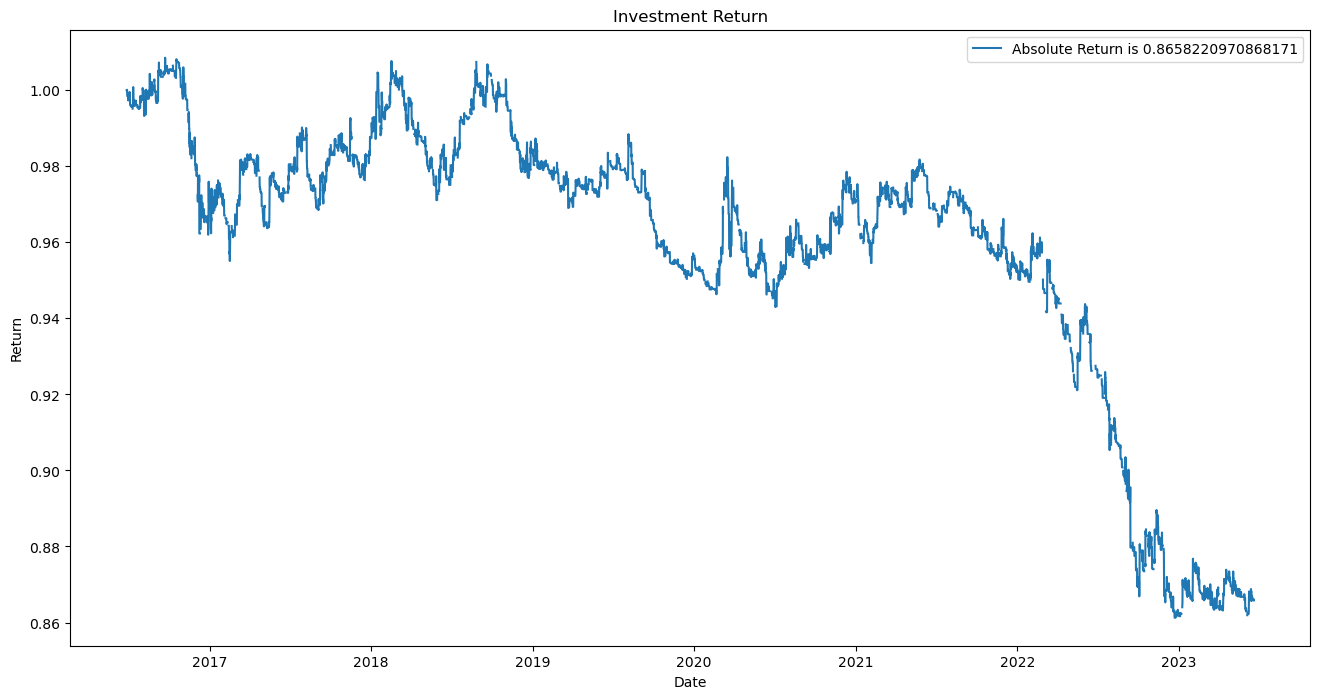

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713                NaN
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.865822
2023-06-19 08:00:00+00:00       0.980494           0.865822
2023-06-19 12:00:00+00:00       0.980530           0.865822
2023-06-19 16:00:00+00:00       0.980206           0.865822
2023-06-19 20:00:00+00:00       0.980673           0.865822

[15295 rows x 2 columns]

In [149]:
trade_candle_4222('4h')

#### 1d

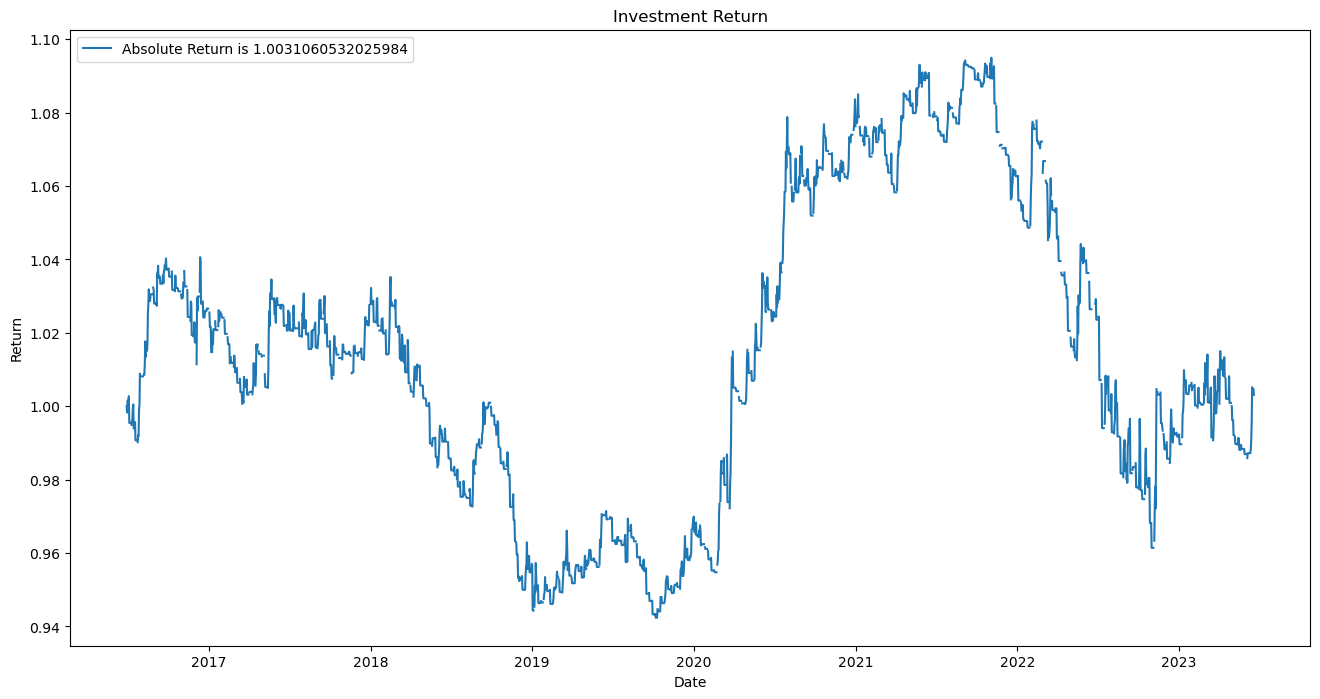

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748                NaN
2016-06-29 00:00:00+00:00       1.009943           1.000000
2016-06-30 00:00:00+00:00       1.008173           0.998264
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           1.005181
2023-06-16 00:00:00+00:00       0.975706           1.004814
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           1.004594
2023-06-19 00:00:00+00:00       0.974047           1.003106

[2550 rows x 2 columns]

In [150]:
trade_candle_4222('1d')

#### 3d

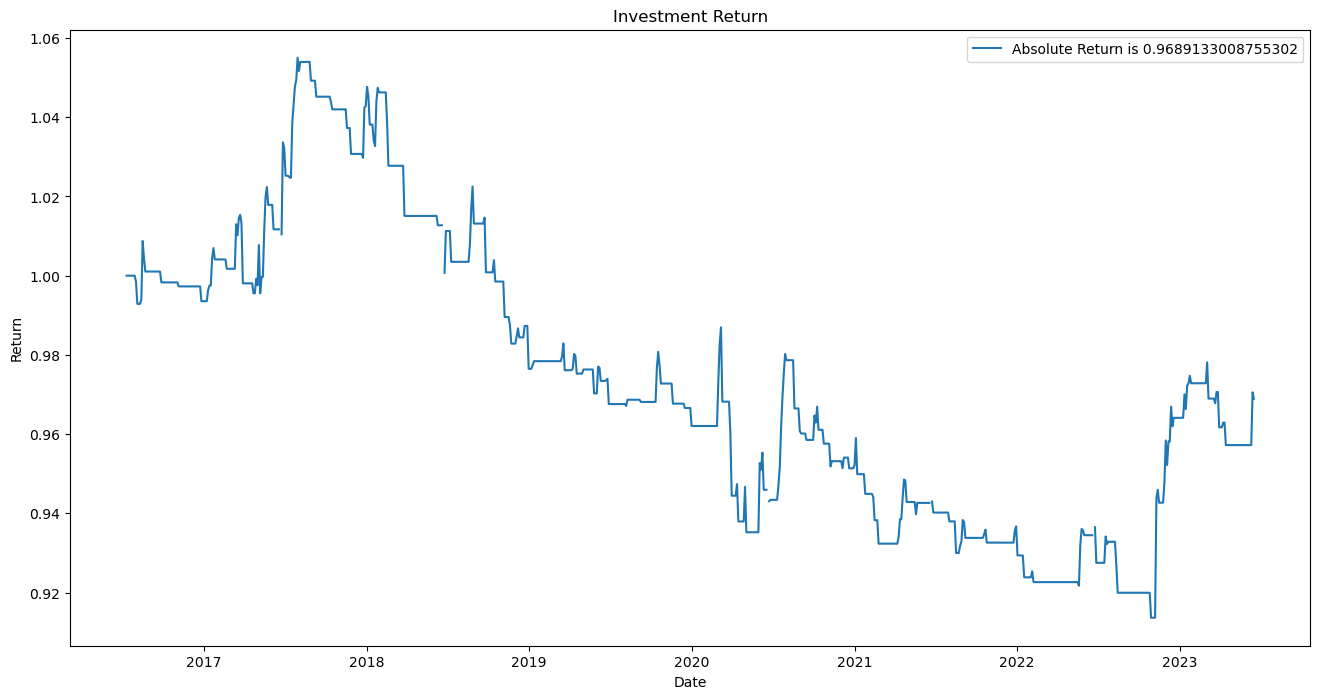

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677                NaN
2016-07-05 00:00:00+00:00       1.005290                NaN
2016-07-08 00:00:00+00:00       1.003545                NaN
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           0.957232
2023-06-08 00:00:00+00:00       0.937022           0.957232
2023-06-11 00:00:00+00:00       0.940544           0.957232
2023-06-14 00:00:00+00:00       0.953776           0.970563
2023-06-17 00:00:00+00:00       0.952155           0.968913

[850 rows x 2 columns]

In [151]:
trade_candle_4222('3d')

### 4.2.2.3 - Strategy 3
- We enter when the bar is different from the previous bar, and we have no wick for this bar.
- We exist if the close is red

In [153]:
def trade_candle_4223(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)
    df['ha_candle_green_difference'] = np.abs(df['ha_candle_green'] - df['ha_candle_green'].shift(1))

    df['entry'] = (df['ha_candle_green_difference'] * df['ha_candle_green_no_wick']).shift(1)

    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_candle_green'].shift(1) == 0, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]


#### 1h

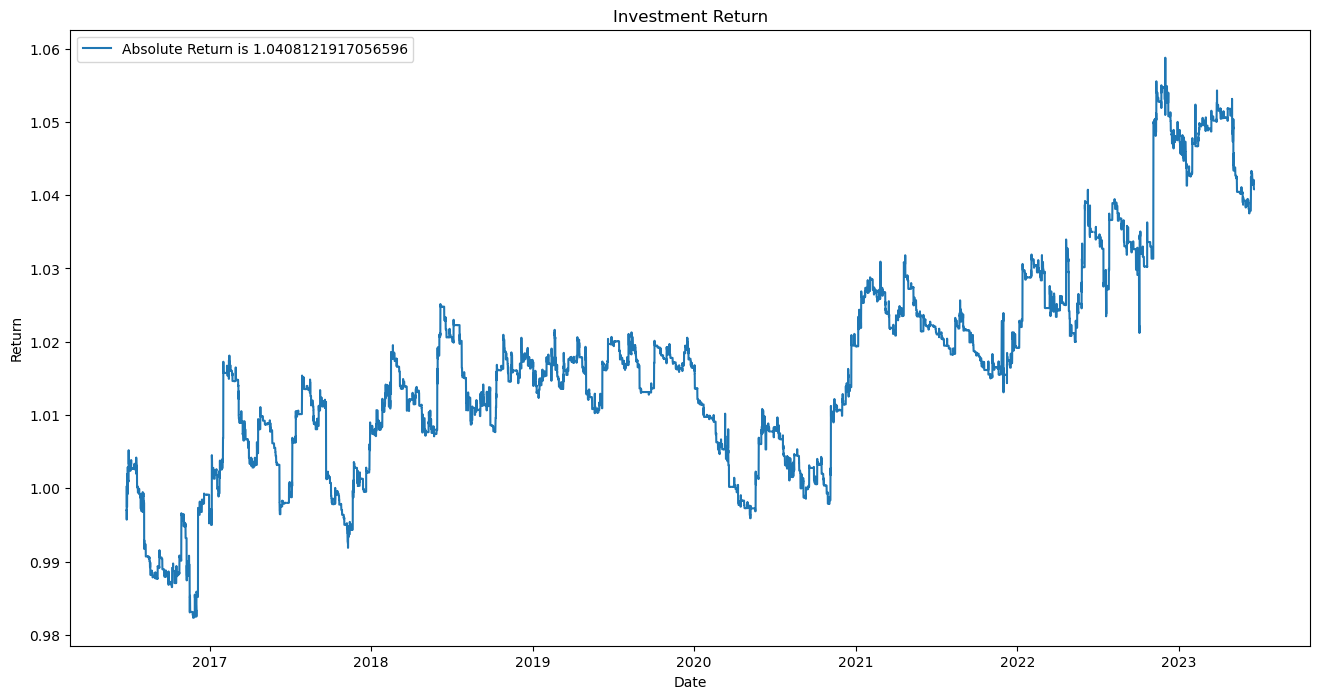

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361           0.997067
2016-06-27 00:00:00+00:00       0.999846           0.997067
2016-06-27 01:00:00+00:00       0.998702           0.997067
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           1.040812
2023-06-19 20:00:00+00:00       0.992003           1.040812
2023-06-19 21:00:00+00:00       0.992030           1.040812
2023-06-19 22:00:00+00:00       0.992030           1.040812
2023-06-19 23:00:00+00:00       0.992094           1.040812

[61179 rows x 2 columns]

In [154]:
trade_candle_4223('1h')

#### 4h

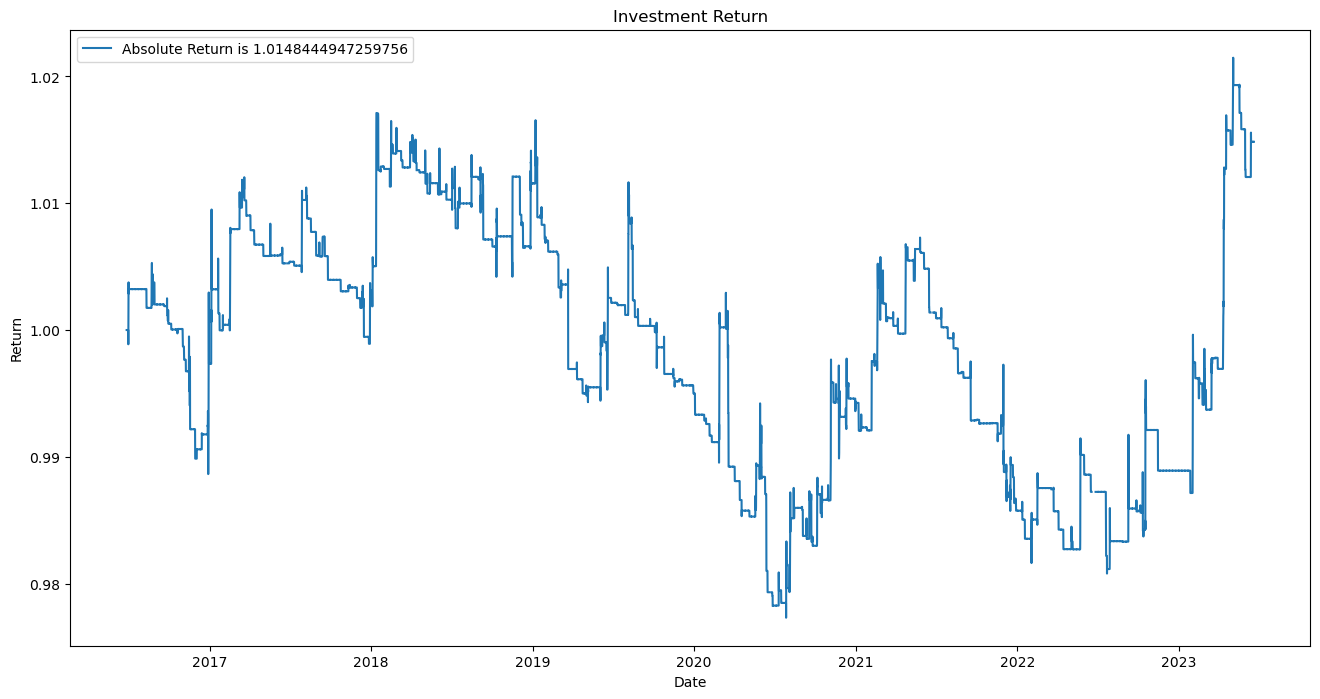

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713           1.000000
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           1.014844
2023-06-19 08:00:00+00:00       0.980494           1.014844
2023-06-19 12:00:00+00:00       0.980530           1.014844
2023-06-19 16:00:00+00:00       0.980206           1.014844
2023-06-19 20:00:00+00:00       0.980673           1.014844

[15295 rows x 2 columns]

In [155]:
trade_candle_4223('4h')

#### 1d

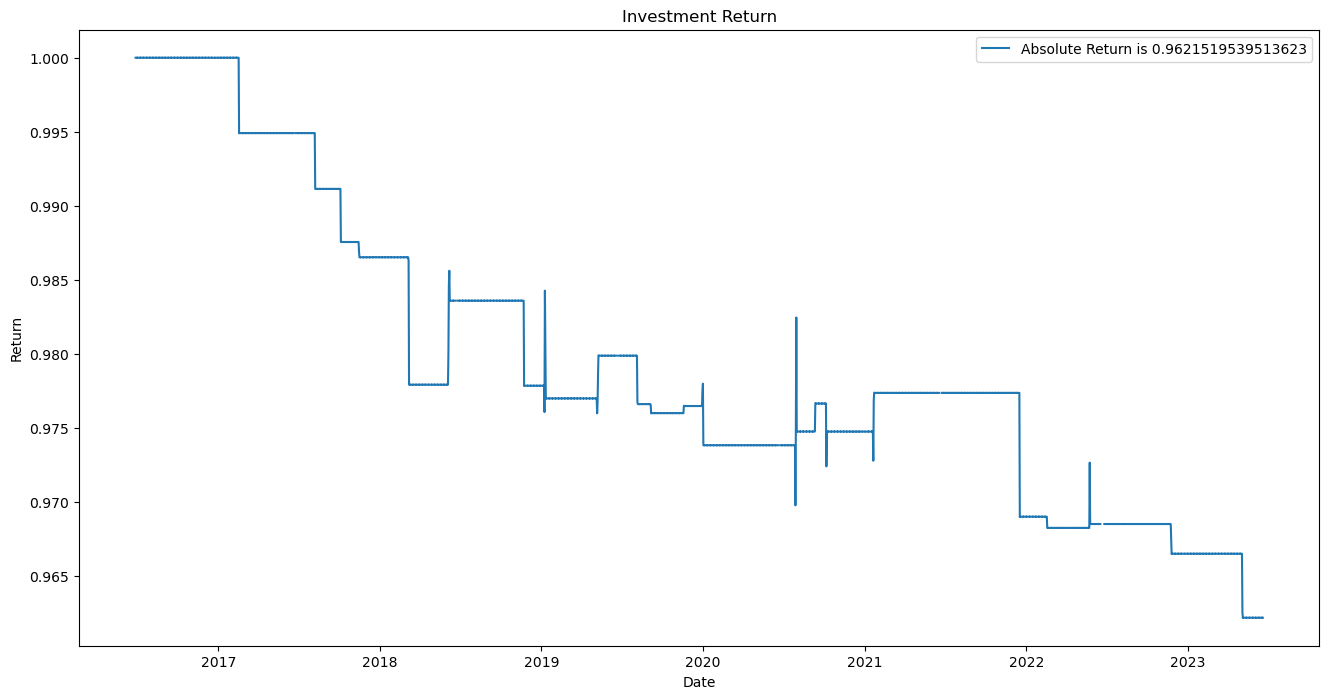

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748           1.000000
2016-06-29 00:00:00+00:00       1.009943           1.000000
2016-06-30 00:00:00+00:00       1.008173           1.000000
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           0.962152
2023-06-16 00:00:00+00:00       0.975706           0.962152
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           0.962152
2023-06-19 00:00:00+00:00       0.974047           0.962152

[2550 rows x 2 columns]

In [156]:
trade_candle_4223('1d')

#### 3d

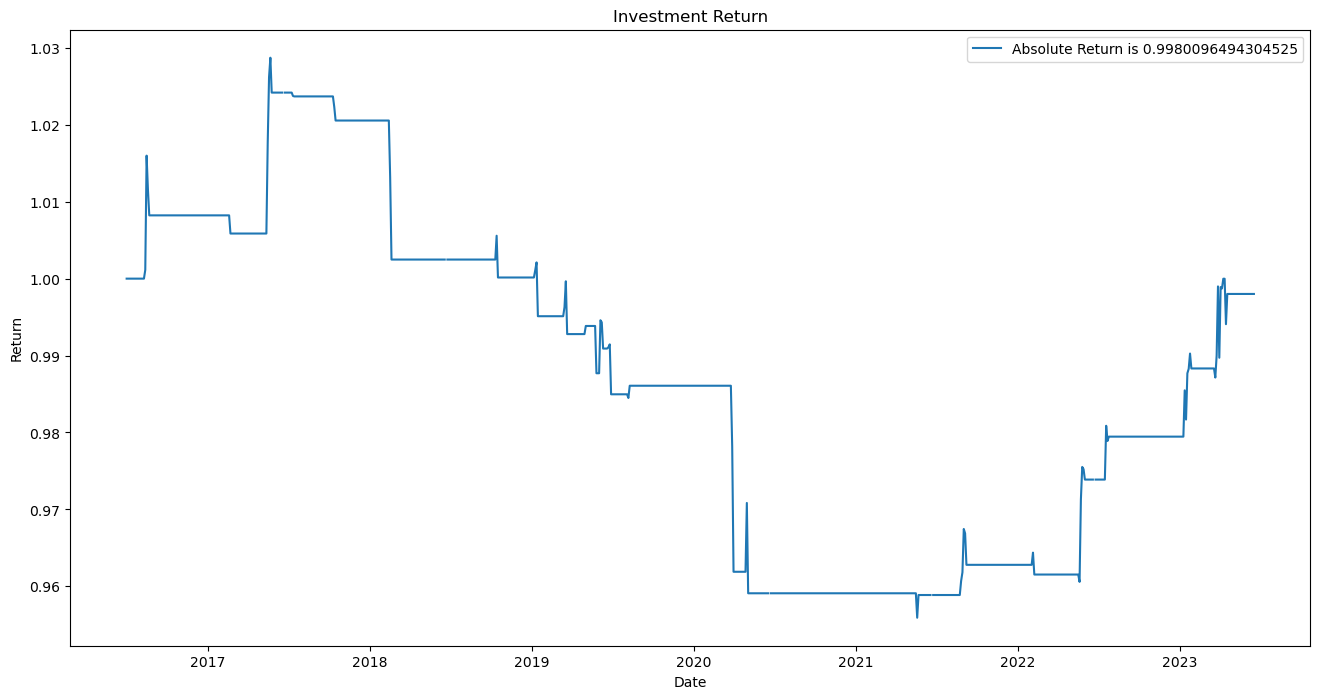

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677            1.00000
2016-07-05 00:00:00+00:00       1.005290            1.00000
2016-07-08 00:00:00+00:00       1.003545            1.00000
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326            0.99801
2023-06-08 00:00:00+00:00       0.937022            0.99801
2023-06-11 00:00:00+00:00       0.940544            0.99801
2023-06-14 00:00:00+00:00       0.953776            0.99801
2023-06-17 00:00:00+00:00       0.952155            0.99801

[850 rows x 2 columns]

In [157]:
trade_candle_4223('3d')

### 4.2.2.4 - Strategy 4
- We enter when we have no wick for this bar.
- We exist if the close is red.

In [165]:
def trade_candle_4224(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)
    df['ha_candle_green_difference'] = np.abs(df['ha_candle_green'] - df['ha_candle_green'].shift(1))

    df['entry'] = (df['ha_candle_green_no_wick']).shift(1)

    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_candle_green'].shift(1) == 0, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]


#### 1h

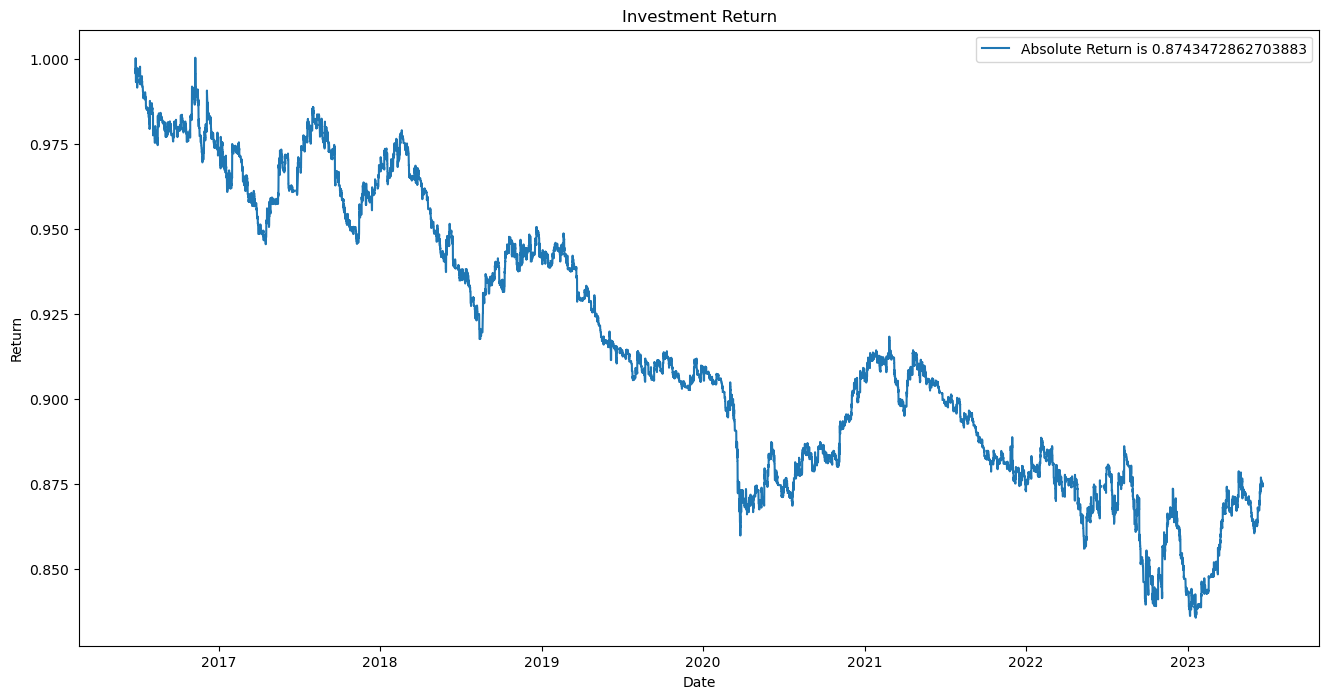

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361           0.997067
2016-06-27 00:00:00+00:00       0.999846           0.997067
2016-06-27 01:00:00+00:00       0.998702           0.997067
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           0.874291
2023-06-19 20:00:00+00:00       0.992003           0.874291
2023-06-19 21:00:00+00:00       0.992030           0.874291
2023-06-19 22:00:00+00:00       0.992030           0.874291
2023-06-19 23:00:00+00:00       0.992094           0.874347

[61179 rows x 2 columns]

In [166]:
trade_candle_4224('1h')

##### 4h

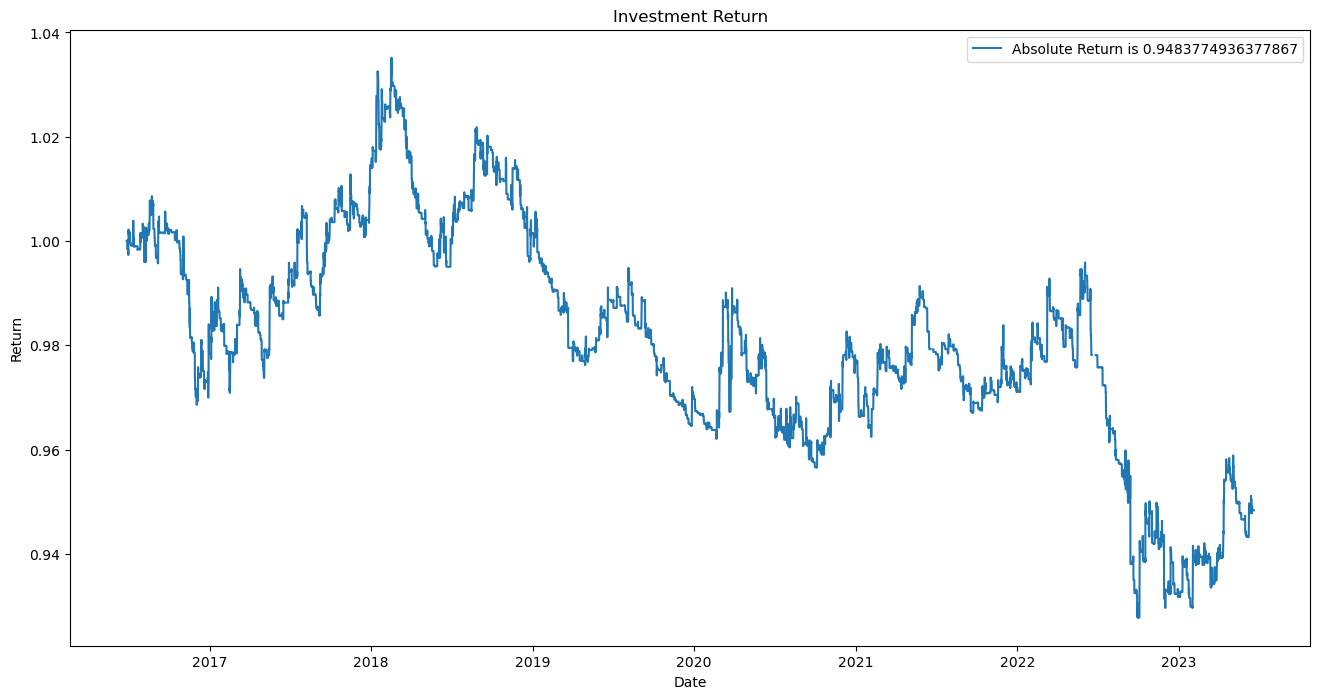

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713           1.000000
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.948377
2023-06-19 08:00:00+00:00       0.980494           0.948377
2023-06-19 12:00:00+00:00       0.980530           0.948377
2023-06-19 16:00:00+00:00       0.980206           0.948377
2023-06-19 20:00:00+00:00       0.980673           0.948377

[15295 rows x 2 columns]

In [167]:
trade_candle_4224('4h')

#### 1d

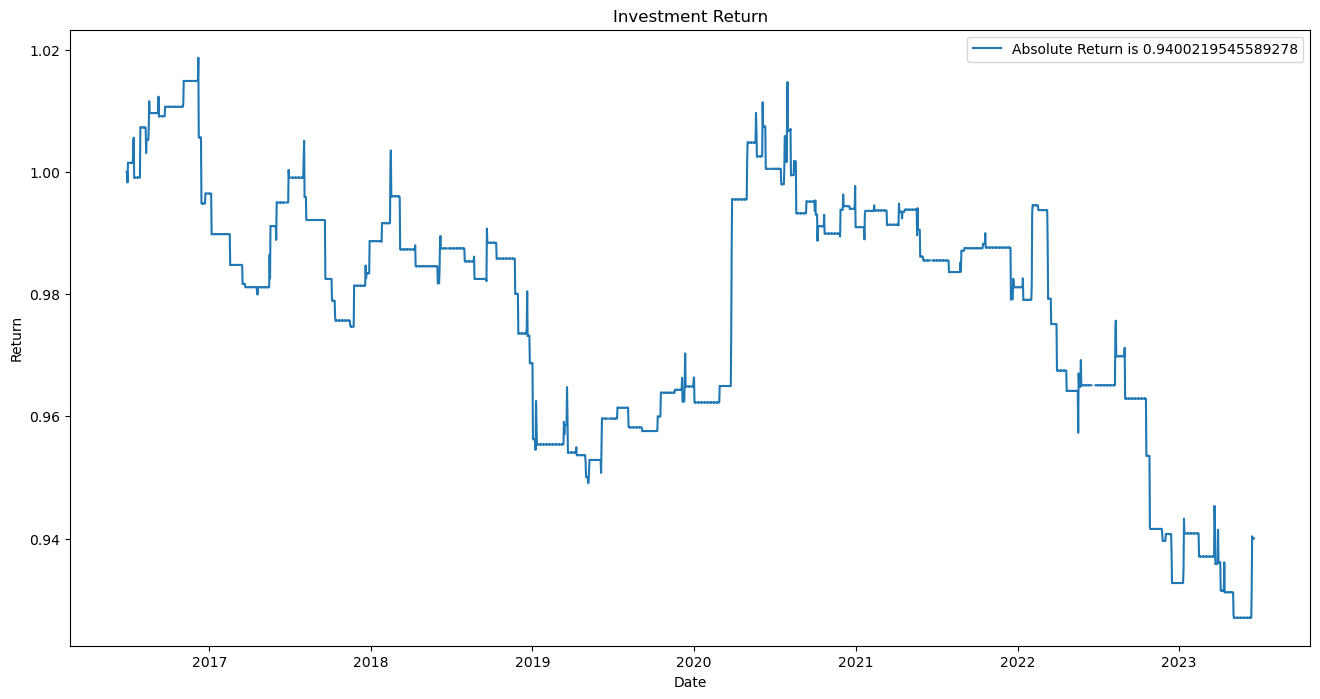

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748           1.000000
2016-06-29 00:00:00+00:00       1.009943           1.000000
2016-06-30 00:00:00+00:00       1.008173           0.998264
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           0.940366
2023-06-16 00:00:00+00:00       0.975706           0.940022
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           0.940022
2023-06-19 00:00:00+00:00       0.974047           0.940022

[2550 rows x 2 columns]

In [168]:
trade_candle_4224('1d')

#### 3d

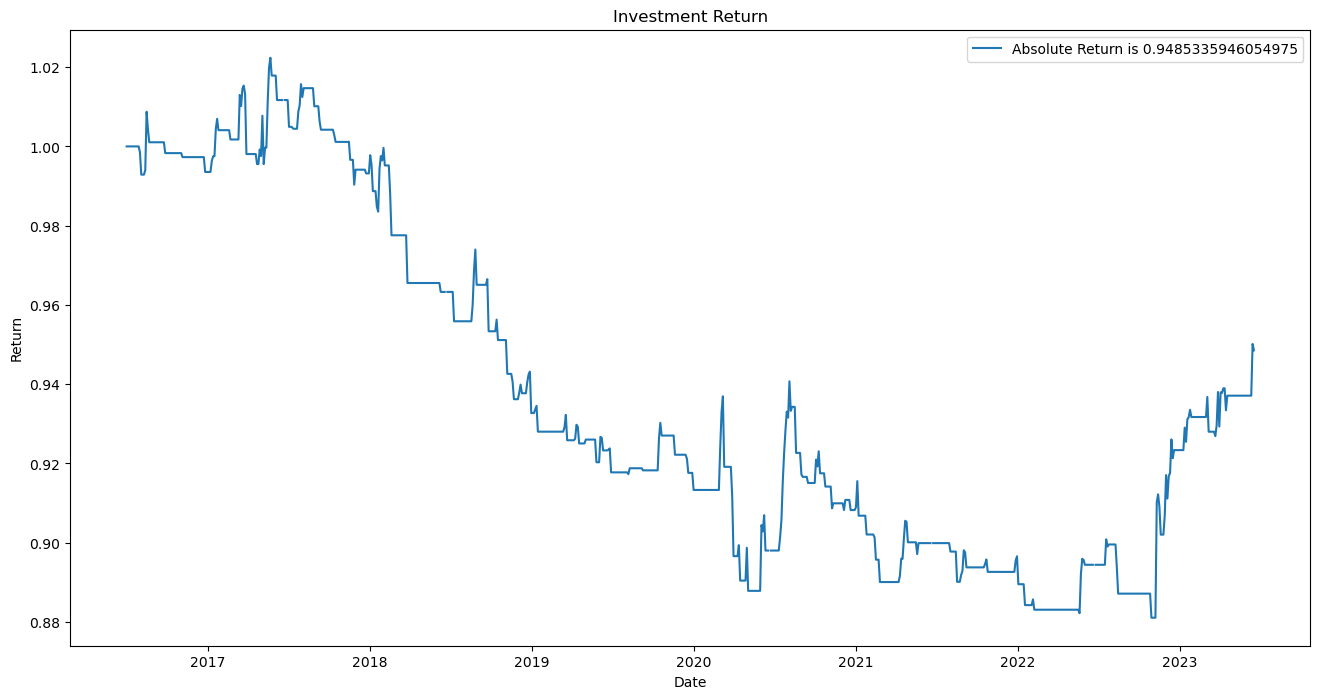

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677           1.000000
2016-07-05 00:00:00+00:00       1.005290           1.000000
2016-07-08 00:00:00+00:00       1.003545           1.000000
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           0.937098
2023-06-08 00:00:00+00:00       0.937022           0.937098
2023-06-11 00:00:00+00:00       0.940544           0.937098
2023-06-14 00:00:00+00:00       0.953776           0.950149
2023-06-17 00:00:00+00:00       0.952155           0.948534

[850 rows x 2 columns]

In [169]:
trade_candle_4224('3d')

### 4.2.2.5 - Strategy 5
 - We enter when there is two no wick
 - We exist if the close is red

In [176]:
def trade_candle_4225(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_candle_green_no_wick_before'] = df['ha_candle_green_no_wick'].shift(1)

    df['entry'] = (df['ha_candle_green_no_wick_before'] * df['ha_candle_green_no_wick']).shift(1)

    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_candle_green'].shift(1) == 0, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]


#### 1h

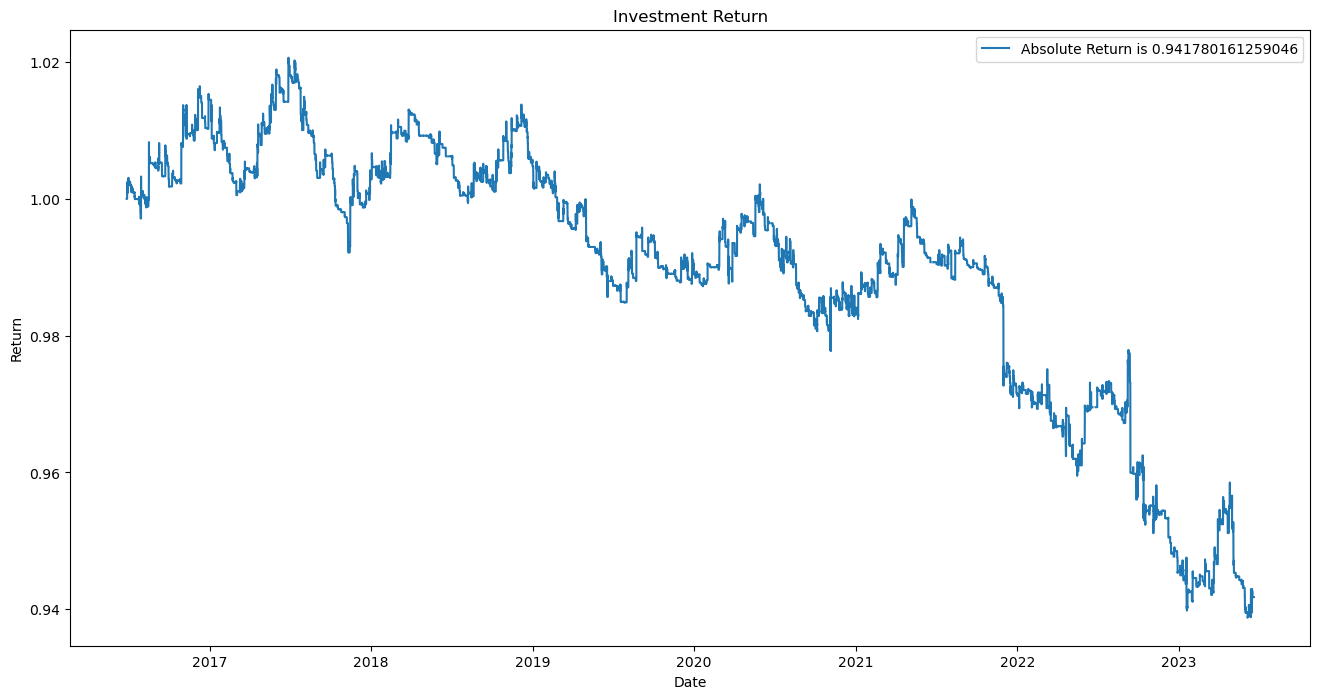

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361            1.00000
2016-06-27 00:00:00+00:00       0.999846            1.00000
2016-06-27 01:00:00+00:00       0.998702            1.00000
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767            0.94178
2023-06-19 20:00:00+00:00       0.992003            0.94178
2023-06-19 21:00:00+00:00       0.992030            0.94178
2023-06-19 22:00:00+00:00       0.992030            0.94178
2023-06-19 23:00:00+00:00       0.992094            0.94178

[61179 rows x 2 columns]

In [173]:
trade_candle_4225('1h')

#### 4h

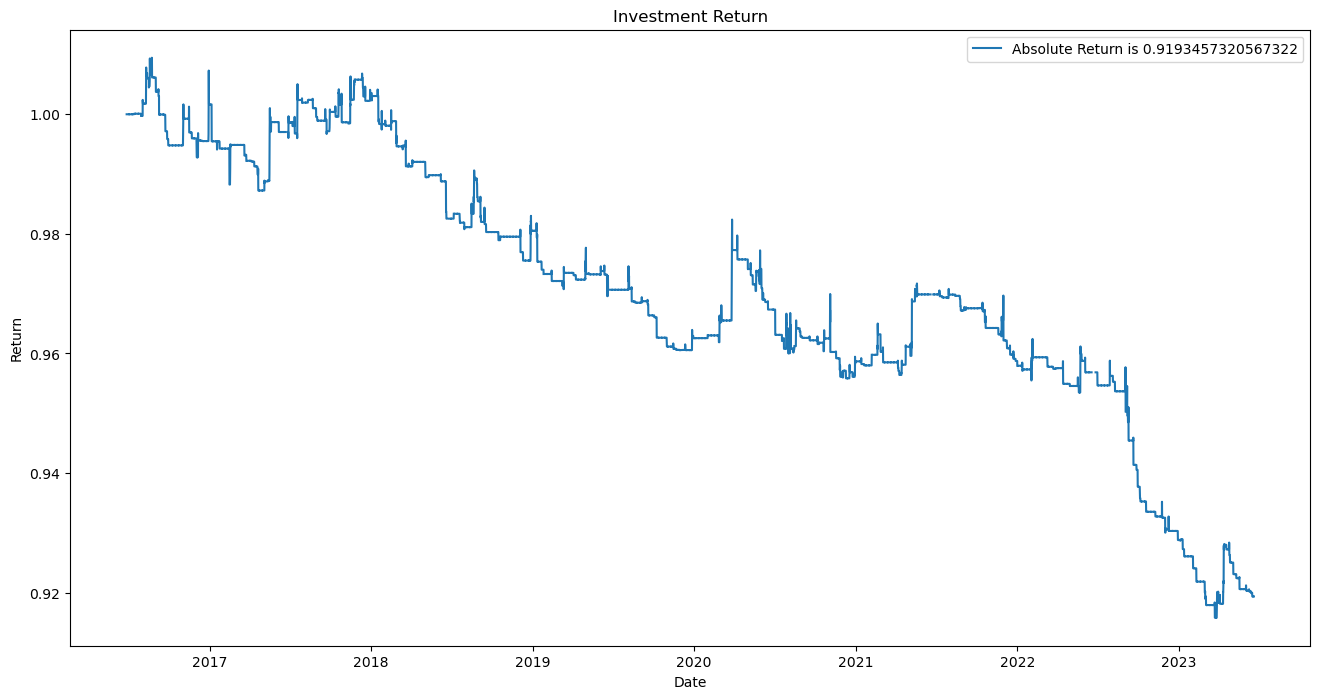

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713           1.000000
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.919346
2023-06-19 08:00:00+00:00       0.980494           0.919346
2023-06-19 12:00:00+00:00       0.980530           0.919346
2023-06-19 16:00:00+00:00       0.980206           0.919346
2023-06-19 20:00:00+00:00       0.980673           0.919346

[15295 rows x 2 columns]

In [177]:
trade_candle_4225('4h')

#### 1d

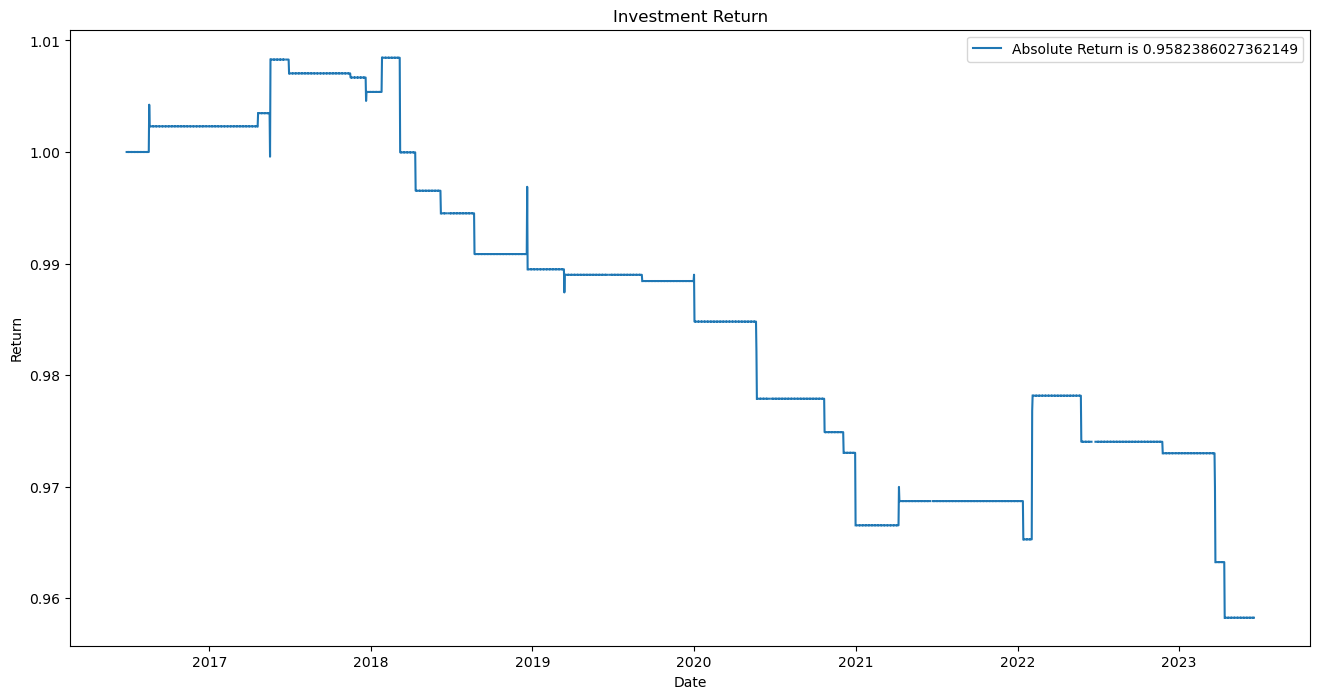

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748           1.000000
2016-06-29 00:00:00+00:00       1.009943           1.000000
2016-06-30 00:00:00+00:00       1.008173           1.000000
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           0.958239
2023-06-16 00:00:00+00:00       0.975706           0.958239
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           0.958239
2023-06-19 00:00:00+00:00       0.974047           0.958239

[2550 rows x 2 columns]

In [178]:
trade_candle_4225('1d')

#### 3d

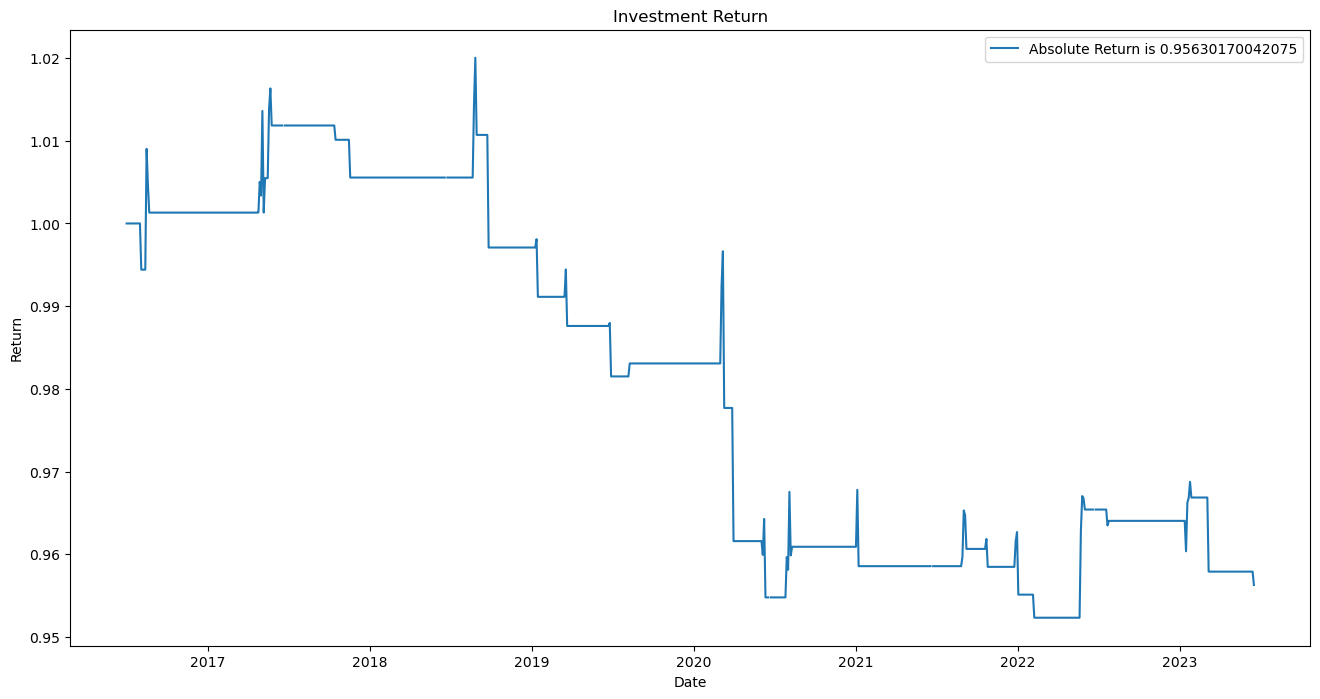

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677           1.000000
2016-07-05 00:00:00+00:00       1.005290           1.000000
2016-07-08 00:00:00+00:00       1.003545           1.000000
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           0.957914
2023-06-08 00:00:00+00:00       0.937022           0.957914
2023-06-11 00:00:00+00:00       0.940544           0.957914
2023-06-14 00:00:00+00:00       0.953776           0.957914
2023-06-17 00:00:00+00:00       0.952155           0.956302

[850 rows x 2 columns]

In [179]:
trade_candle_4225('3d')

### - 4.2.2.6 Strategy 6
- We enter when there is two no wick
- We exist if the close is smaller than the previous close

In [180]:
def trade_candle_4226(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_candle_green_no_wick_before'] = df['ha_candle_green_no_wick'].shift(1)

    df['entry'] = (df['ha_candle_green_no_wick_before'] * df['ha_candle_green_no_wick']).shift(1)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)

    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_close_smaller_than_previous'].shift(1) == 1, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]

#### 1h

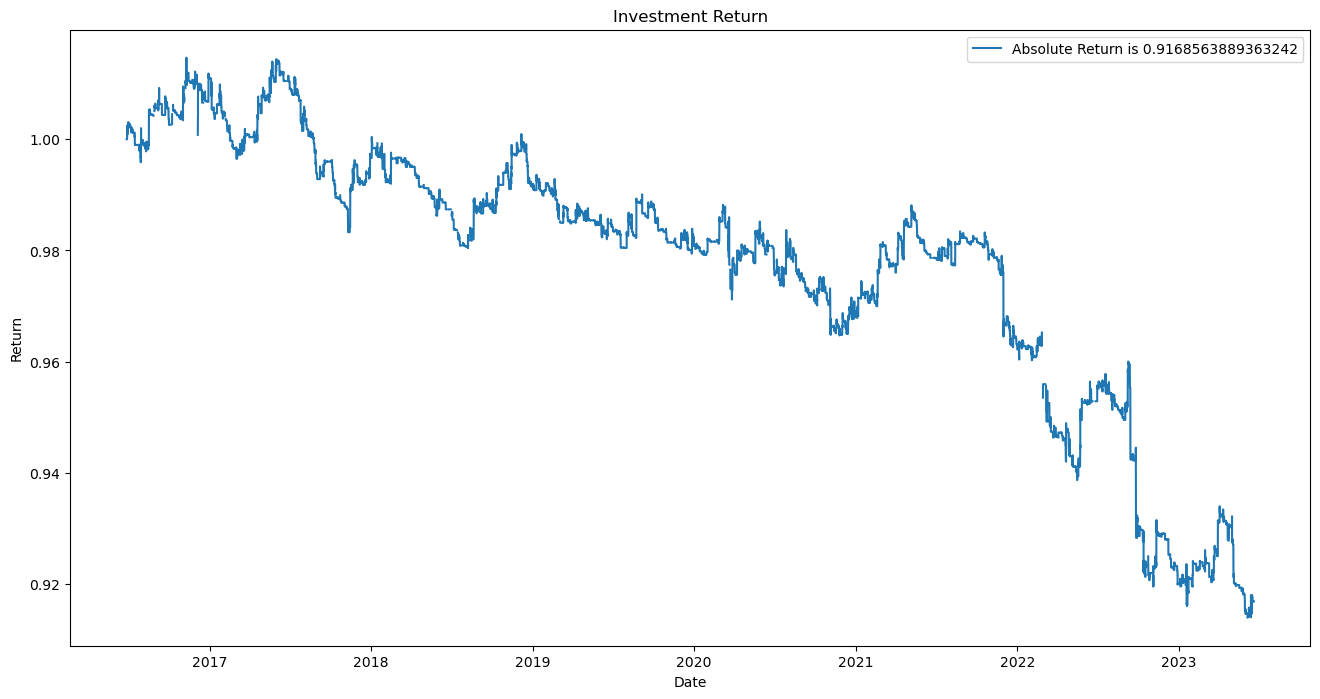

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361                NaN
2016-06-27 00:00:00+00:00       0.999846                NaN
2016-06-27 01:00:00+00:00       0.998702           1.000000
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           0.916856
2023-06-19 20:00:00+00:00       0.992003           0.916856
2023-06-19 21:00:00+00:00       0.992030           0.916856
2023-06-19 22:00:00+00:00       0.992030           0.916856
2023-06-19 23:00:00+00:00       0.992094           0.916856

[61179 rows x 2 columns]

In [181]:
trade_candle_4226('1h')

#### 4h

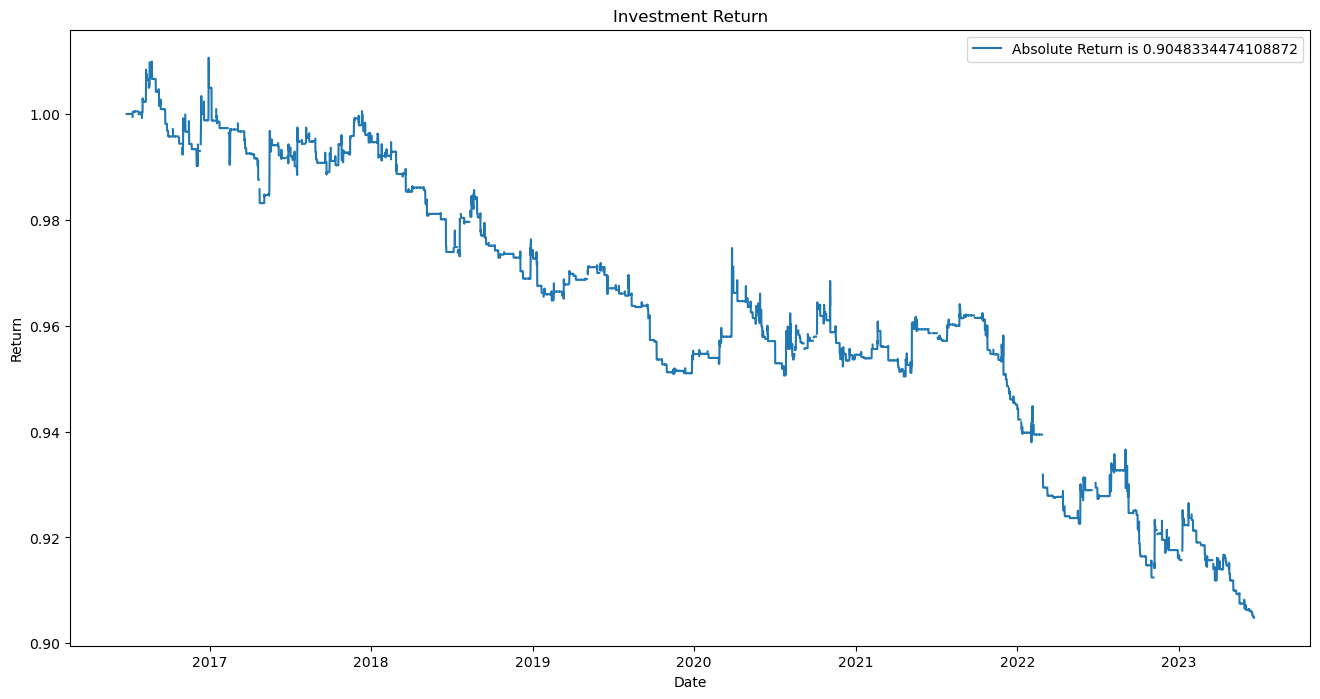

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713                NaN
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.904833
2023-06-19 08:00:00+00:00       0.980494           0.904833
2023-06-19 12:00:00+00:00       0.980530           0.904833
2023-06-19 16:00:00+00:00       0.980206           0.904833
2023-06-19 20:00:00+00:00       0.980673           0.904833

[15295 rows x 2 columns]

In [182]:
trade_candle_4226('4h')

#### 1d

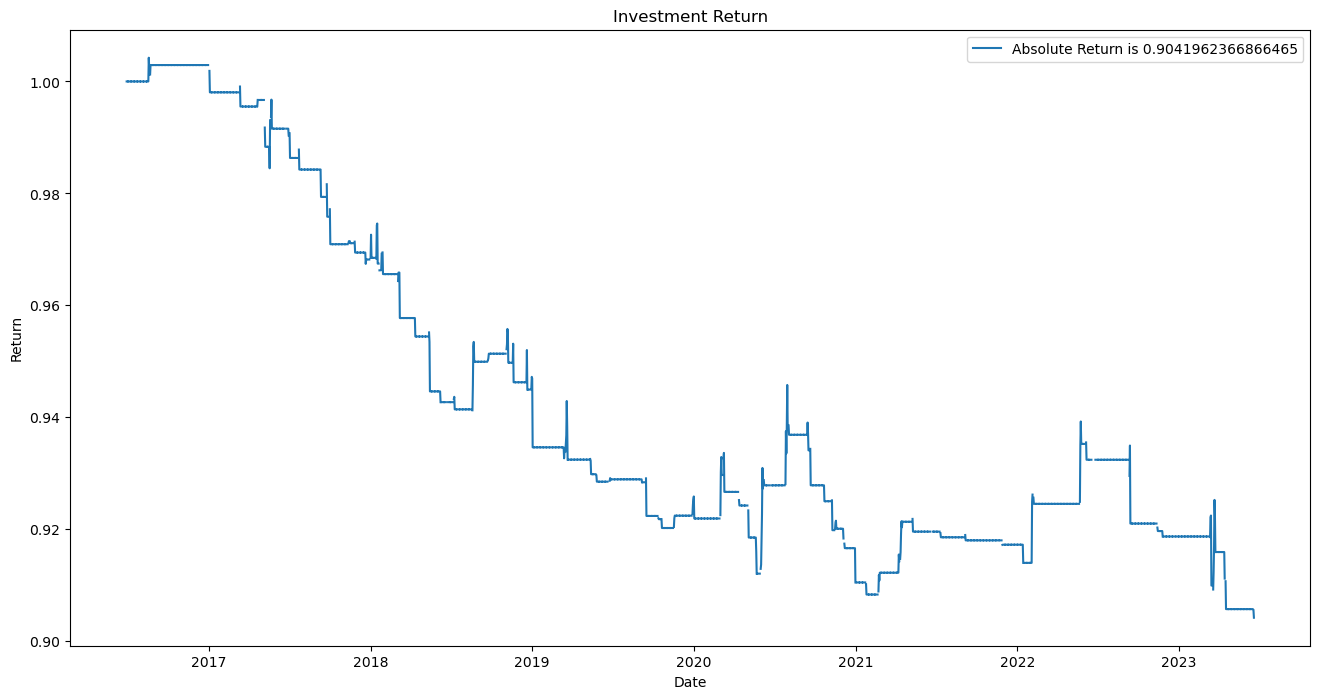

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748                NaN
2016-06-29 00:00:00+00:00       1.009943           1.000000
2016-06-30 00:00:00+00:00       1.008173           1.000000
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063           0.905734
2023-06-16 00:00:00+00:00       0.975706           0.905734
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492           0.905537
2023-06-19 00:00:00+00:00       0.974047           0.904196

[2550 rows x 2 columns]

In [183]:
trade_candle_4226('1d')

#### 3d

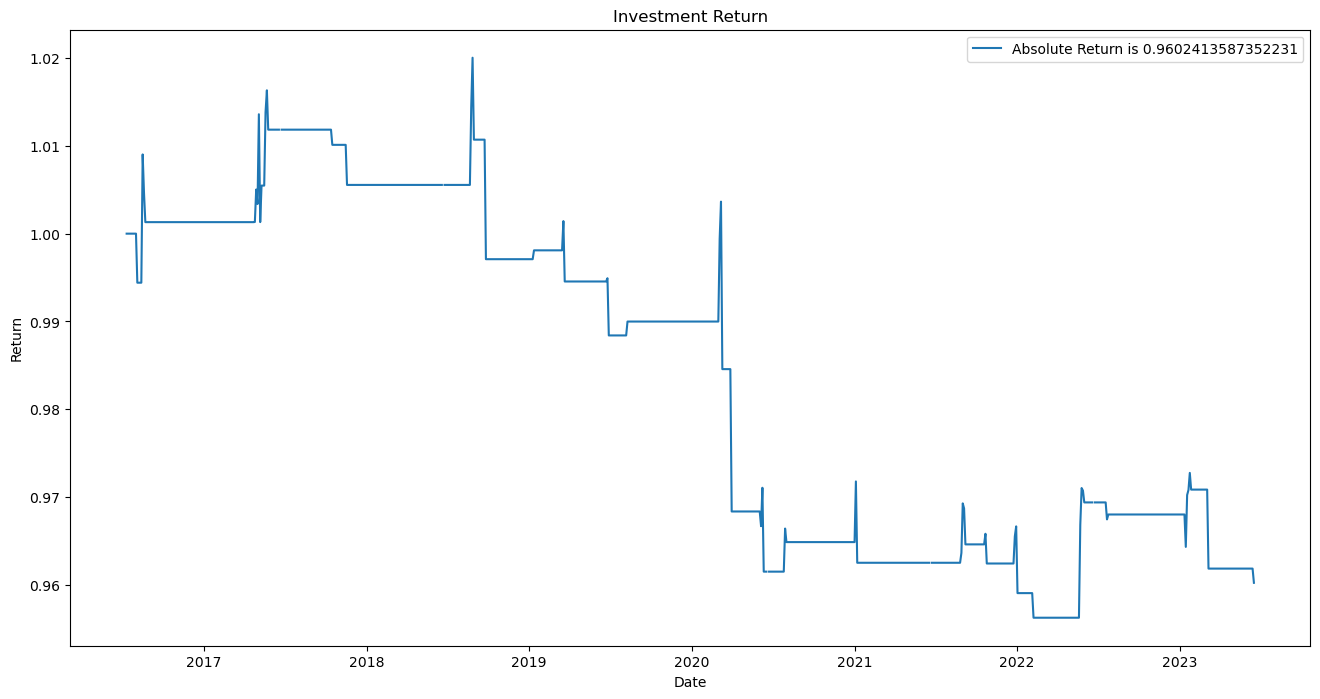

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677                NaN
2016-07-05 00:00:00+00:00       1.005290                NaN
2016-07-08 00:00:00+00:00       1.003545                NaN
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           0.961860
2023-06-08 00:00:00+00:00       0.937022           0.961860
2023-06-11 00:00:00+00:00       0.940544           0.961860
2023-06-14 00:00:00+00:00       0.953776           0.961860
2023-06-17 00:00:00+00:00       0.952155           0.960241

[850 rows x 2 columns]

In [185]:
trade_candle_4226('3d')

### 4.2.3 Heikin Ashi and Stochastic<a id='4_2_3'></a>

- The intuition of this trading strategy is from video (https://youtu.be/2G78zkuQSc0)
- We buy when the heikin ashi candle is different from the previous candle or when there is no last wick or both. We only enter if the %k line of the stochastic is higher than the %d line.

--Frank

In [186]:
def compute_stochastic_oscillator(data, high_col='high', low_col='low', close_col='close', k_period=14, d_period=3):
    df = data.copy()
    # Calculate the highest high and lowest low for the %K line period
    df['high_max'] = df[high_col].rolling(window=k_period).max()
    df['low_min'] = df[low_col].rolling(window=k_period).min()

    # Compute the %K line
    df['%K'] = 100 * ((df[close_col] - df['low_min']) / (df['high_max'] - df['low_min']))

    # Compute the %D line
    df['%D'] = df['%K'].rolling(window=d_period).mean()
    df.drop(columns=['high_max', 'low_min'], inplace=True)
    
    return df

### Strategy 1 <a id='strategy_1_'></a>
- We enter when the bar is different from the previous bar and %K > %D
- We exit if the close is smaller than the previous close

In [196]:
def trade_candle_4231(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df = compute_stochastic_oscillator(df)
    df['stochastic_above'] = np.where(df['%K'] > df['%D'], 1, 0)
    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)
    df['ha_candle_green_difference'] = np.where(df['ha_candle_green'] - df['ha_candle_green'].shift(1) == 1, 1, 0)

    df['entry'] = (df['ha_candle_green_difference'] * df['stochastic_above']).shift(1)
    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_close_smaller_than_previous'].shift(1) == 1, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]

#### 1h

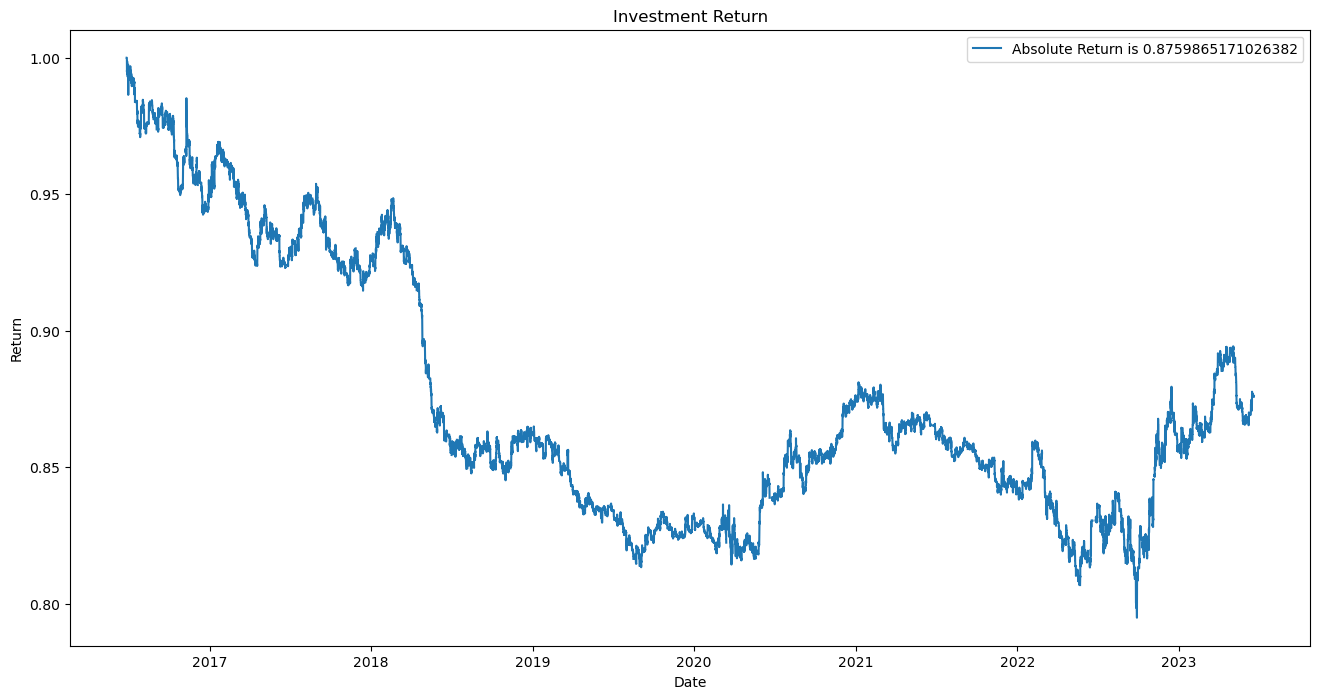

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361                NaN
2016-06-27 00:00:00+00:00       0.999846                NaN
2016-06-27 01:00:00+00:00       0.998702           1.000000
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           0.875698
2023-06-19 20:00:00+00:00       0.992003           0.875906
2023-06-19 21:00:00+00:00       0.992030           0.875930
2023-06-19 22:00:00+00:00       0.992030           0.875930
2023-06-19 23:00:00+00:00       0.992094           0.875987

[61179 rows x 2 columns]

In [192]:
trade_candle_4231('1h')

#### 4h

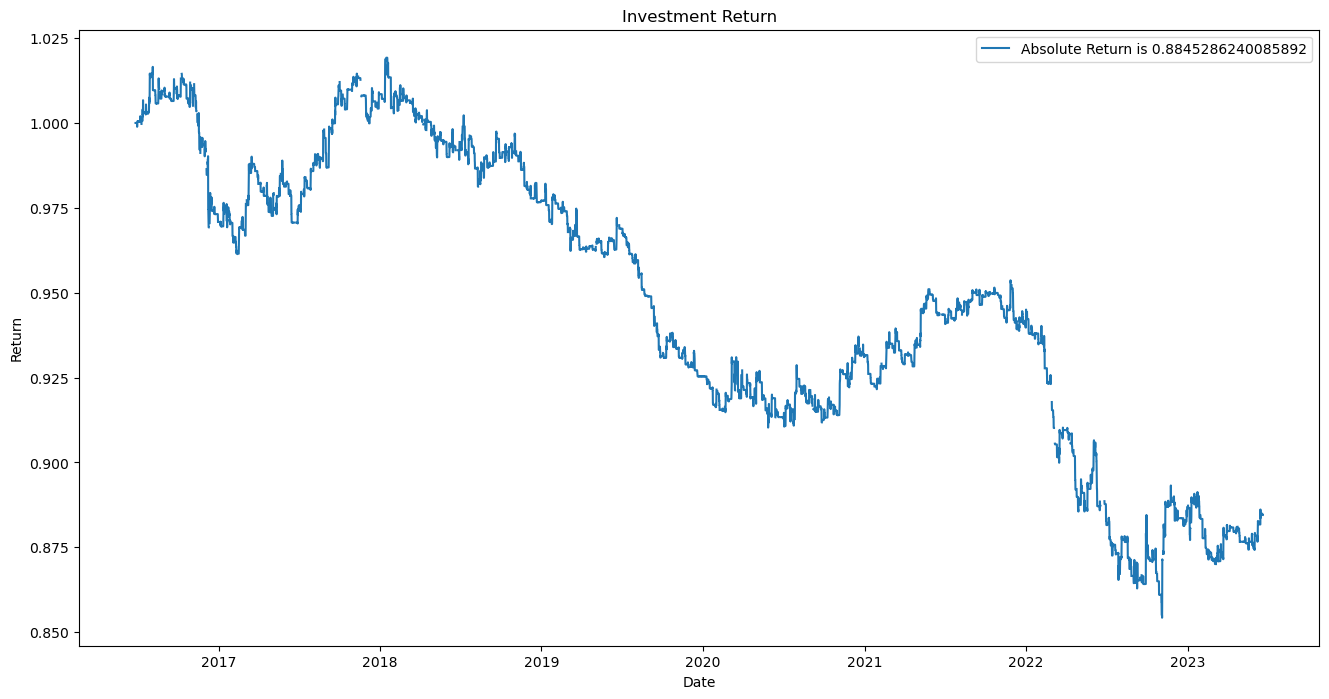

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713                NaN
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.884529
2023-06-19 08:00:00+00:00       0.980494           0.884529
2023-06-19 12:00:00+00:00       0.980530           0.884529
2023-06-19 16:00:00+00:00       0.980206           0.884529
2023-06-19 20:00:00+00:00       0.980673           0.884529

[15295 rows x 2 columns]

In [193]:
trade_candle_4231('4h')

#### 1d

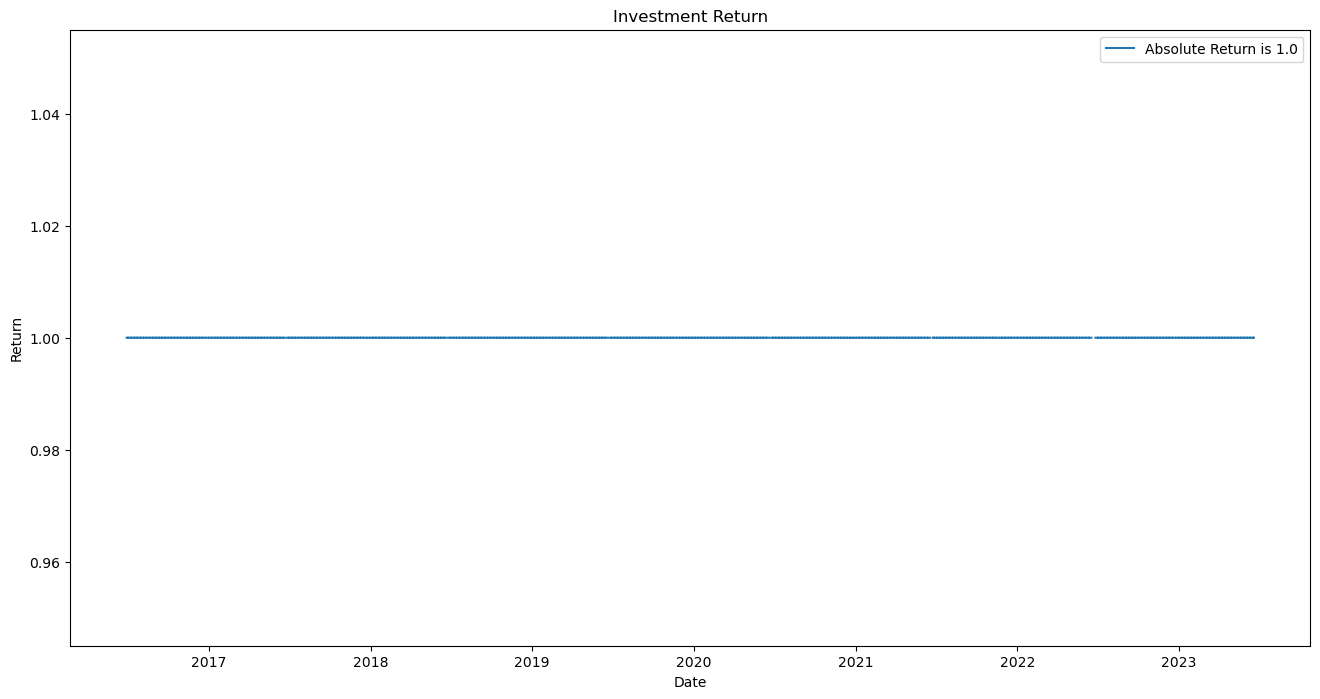

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748                NaN
2016-06-29 00:00:00+00:00       1.009943                1.0
2016-06-30 00:00:00+00:00       1.008173                1.0
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063                1.0
2023-06-16 00:00:00+00:00       0.975706                1.0
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492                1.0
2023-06-19 00:00:00+00:00       0.974047                1.0

[2550 rows x 2 columns]

In [194]:
trade_candle_4231('1d')

#### 3d

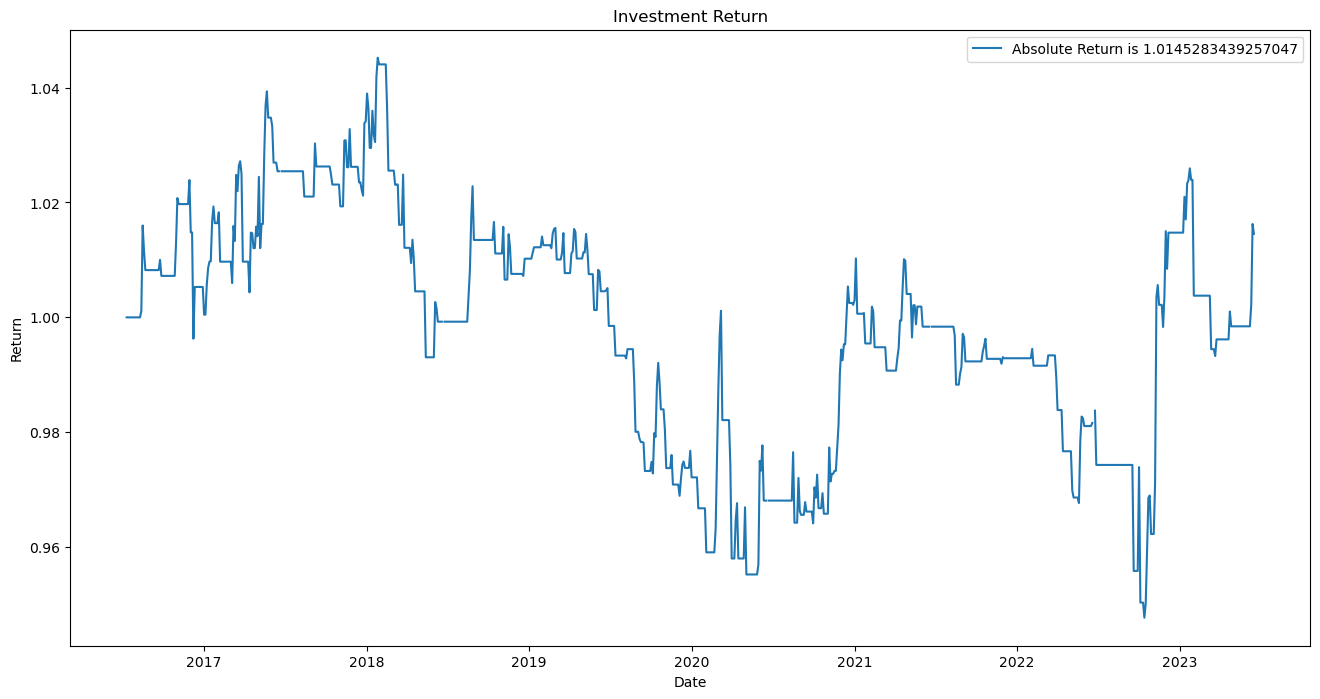

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677                NaN
2016-07-05 00:00:00+00:00       1.005290                NaN
2016-07-08 00:00:00+00:00       1.003545                NaN
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           0.998442
2023-06-08 00:00:00+00:00       0.937022           0.998442
2023-06-11 00:00:00+00:00       0.940544           1.002157
2023-06-14 00:00:00+00:00       0.953776           1.016256
2023-06-17 00:00:00+00:00       0.952155           1.014528

[850 rows x 2 columns]

In [231]:
trade_candle_4231('3d')

### Strategy 2 <a id='strategy_2_'></a>
- We enter when the bar is different from the previous bar and %K > %D
- We exit if bar is red

In [232]:
def trade_candle_4232(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df = compute_stochastic_oscillator(df)
    df['stochastic_above'] = np.where(df['%K'] > df['%D'], 1, 0)
    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)
    df['ha_candle_green_difference'] = np.where(df['ha_candle_green'] - df['ha_candle_green'].shift(1) == 1, 1, 0)

    df['entry'] = (df['ha_candle_green_difference'] * df['stochastic_above']).shift(1)
    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_candle_green'].shift(1) == 0, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    return df[['EurUSD_return', 'investment_return']]


#### 1h

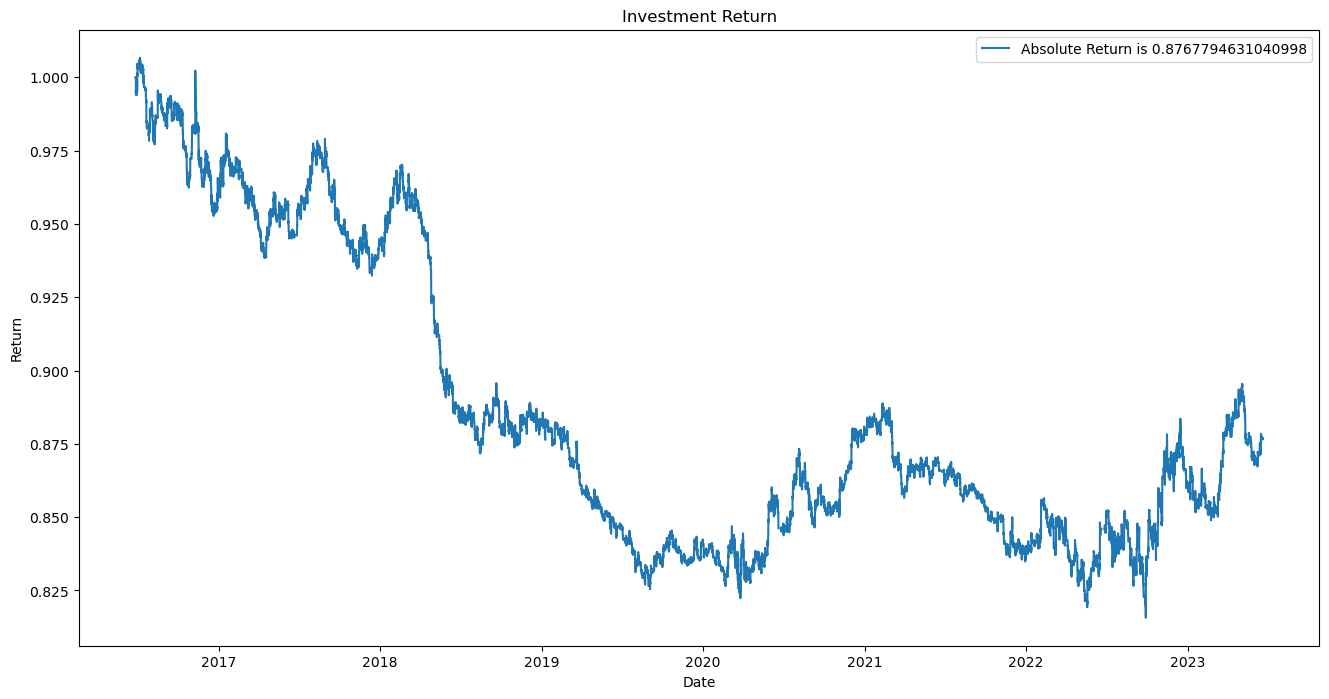

EurUSD_return  investment_return
time                                                       
2016-06-26 21:00:00+00:00       1.002679                NaN
2016-06-26 22:00:00+00:00       1.005339                NaN
2016-06-26 23:00:00+00:00       1.002361           1.000000
2016-06-27 00:00:00+00:00       0.999846           1.000000
2016-06-27 01:00:00+00:00       0.998702           1.000000
...                                  ...                ...
2023-06-19 19:00:00+00:00       0.991767           0.876490
2023-06-19 20:00:00+00:00       0.992003           0.876699
2023-06-19 21:00:00+00:00       0.992030           0.876723
2023-06-19 22:00:00+00:00       0.992030           0.876723
2023-06-19 23:00:00+00:00       0.992094           0.876779

[61179 rows x 2 columns]

In [233]:
trade_candle_4232('1h')

#### 4h

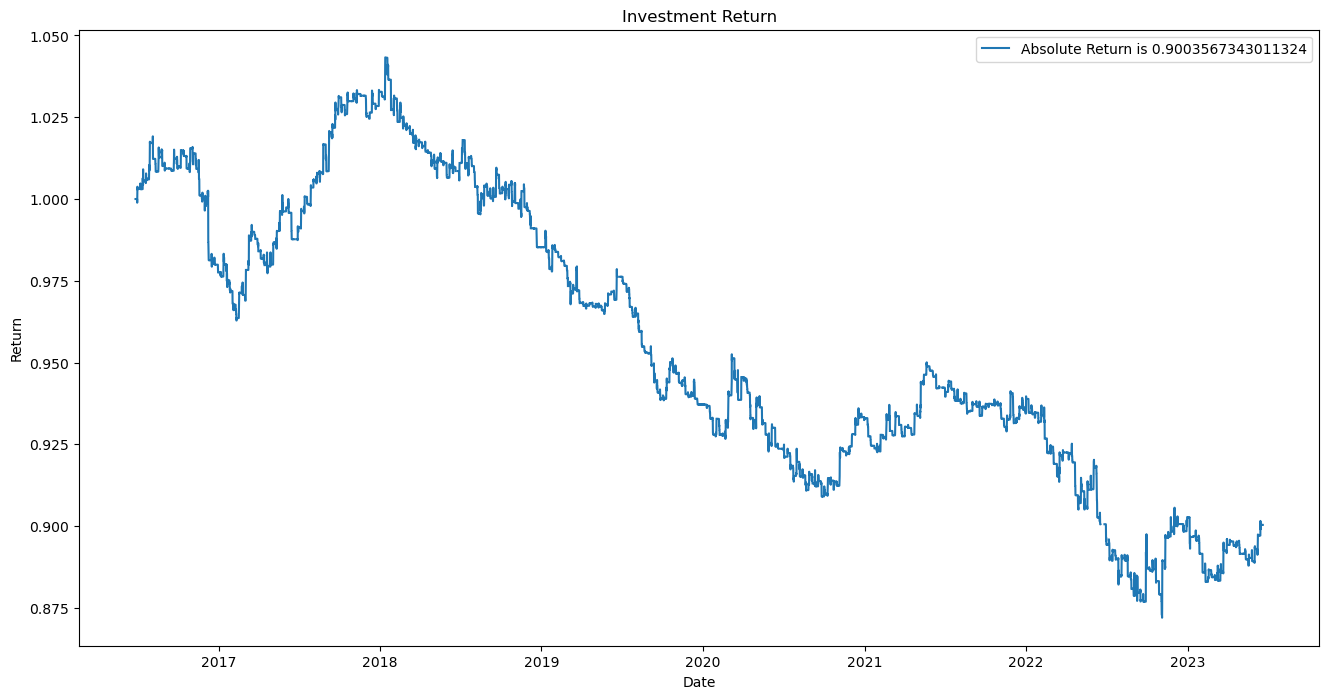

EurUSD_return  investment_return
time                                                       
2016-06-26 20:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.001480                NaN
2016-06-27 04:00:00+00:00       1.004713           1.000000
2016-06-27 08:00:00+00:00       0.998211           1.000000
2016-06-27 12:00:00+00:00       1.000845           1.000000
...                                  ...                ...
2023-06-19 04:00:00+00:00       0.981212           0.900357
2023-06-19 08:00:00+00:00       0.980494           0.900357
2023-06-19 12:00:00+00:00       0.980530           0.900357
2023-06-19 16:00:00+00:00       0.980206           0.900357
2023-06-19 20:00:00+00:00       0.980673           0.900357

[15295 rows x 2 columns]

In [234]:
trade_candle_4232('4h')

#### 1d

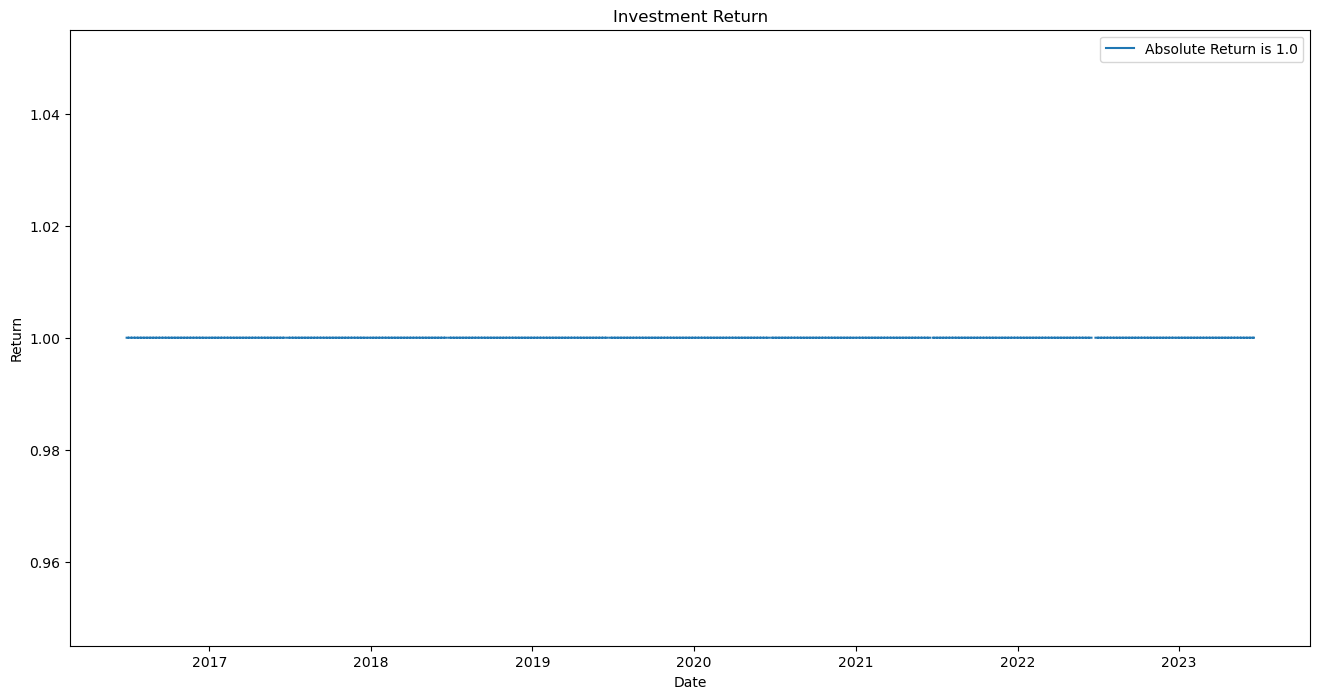

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.002497                NaN
2016-06-27 00:00:00+00:00       1.000109                NaN
2016-06-28 00:00:00+00:00       1.005748                1.0
2016-06-29 00:00:00+00:00       1.009943                1.0
2016-06-30 00:00:00+00:00       1.008173                1.0
...                                  ...                ...
2023-06-15 00:00:00+00:00       0.976063                1.0
2023-06-16 00:00:00+00:00       0.975706                1.0
2023-06-17 00:00:00+00:00            NaN                NaN
2023-06-18 00:00:00+00:00       0.975492                1.0
2023-06-19 00:00:00+00:00       0.974047                1.0

[2550 rows x 2 columns]

In [235]:
trade_candle_4232('1d')

#### 3d

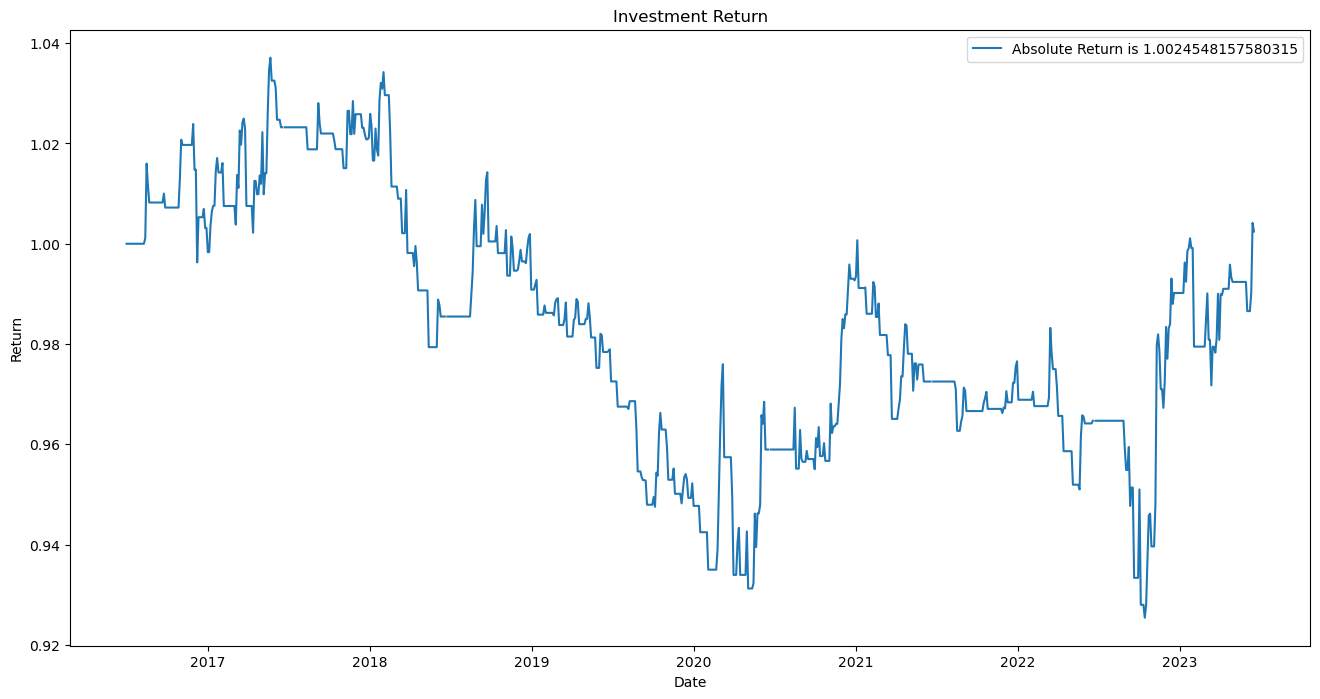

EurUSD_return  investment_return
time                                                       
2016-06-26 00:00:00+00:00       1.005739                NaN
2016-06-29 00:00:00+00:00       1.011405                NaN
2016-07-02 00:00:00+00:00       1.012677           1.000000
2016-07-05 00:00:00+00:00       1.005290           1.000000
2016-07-08 00:00:00+00:00       1.003545           1.000000
...                                  ...                ...
2023-06-05 00:00:00+00:00       0.933326           0.986560
2023-06-08 00:00:00+00:00       0.937022           0.986560
2023-06-11 00:00:00+00:00       0.940544           0.990230
2023-06-14 00:00:00+00:00       0.953776           1.004162
2023-06-17 00:00:00+00:00       0.952155           1.002455

[850 rows x 2 columns]

In [236]:
trade_candle_4232('3d')

### Strategy 3 <a id='strategy_3_'></a>
- We buy when the bar has no wick and %K > %D
- We exit if the close is smaller than the previous close

In [237]:
def trade_candle_4233(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df = compute_stochastic_oscillator(df)
    df['stochastic_above'] = np.where(df['%K'] > df['%D'], 1, 0)
    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)
    df['ha_candle_green_difference'] = np.where(df['ha_candle_green'] - df['ha_candle_green'].shift(1) == 1, 1, 0)

    df['entry'] = (df['ha_candle_green_no_wick'] * df['stochastic_above']).shift(1)
    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_close_smaller_than_previous'].shift(1) == 1, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    investment_return = df['investment_return']
    peak = investment_return.cummax()
    drawdown = (investment_return - peak) / peak
    max_drawdown = drawdown.min()

    print("Maximum Drawdown:", max_drawdown)

    return df[['EurUSD_return', 'investment_return']].describe()


#### 1h

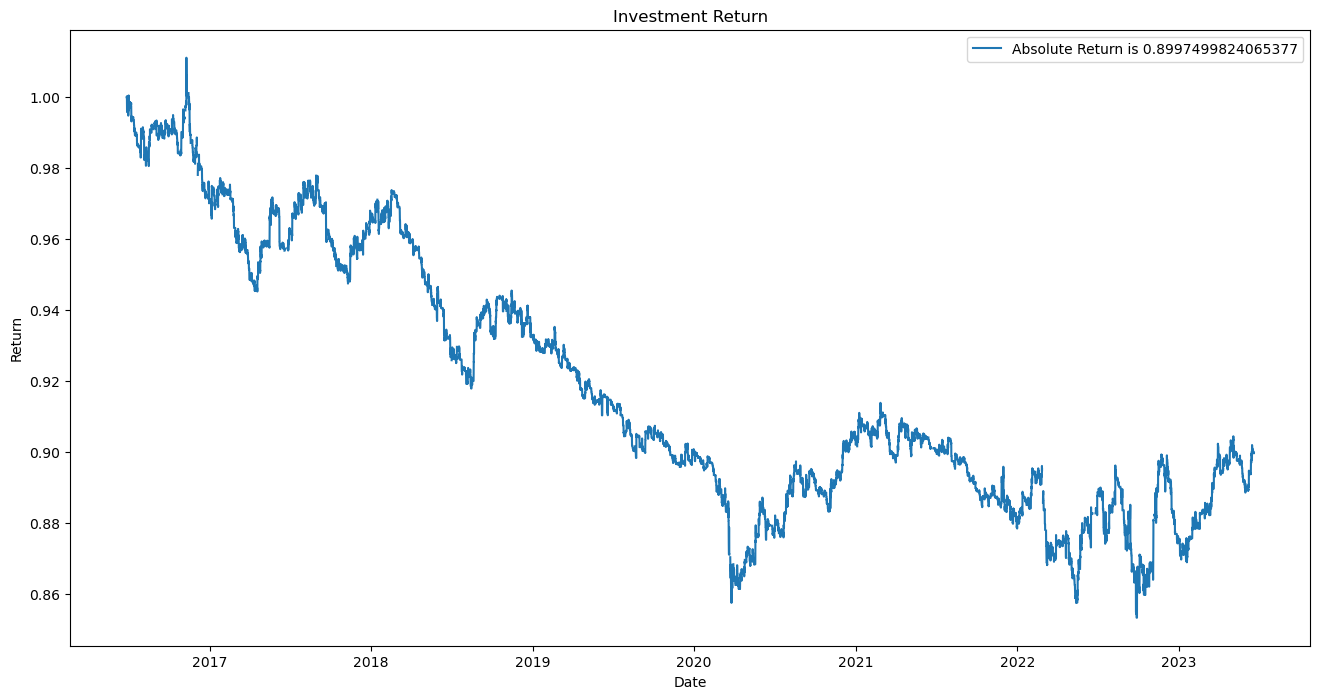

Maximum Drawdown: -0.1559758539872757


EurUSD_return  investment_return
count   42930.000000       42926.000000
mean        1.035284           0.917835
std         0.053783           0.036705
min         0.867599           0.853403
25%         1.000082           0.888869
50%         1.034960           0.904474
75%         1.075276           0.951263
max         1.161048           1.011112

In [238]:
trade_candle_4233('1h')

#### 4h

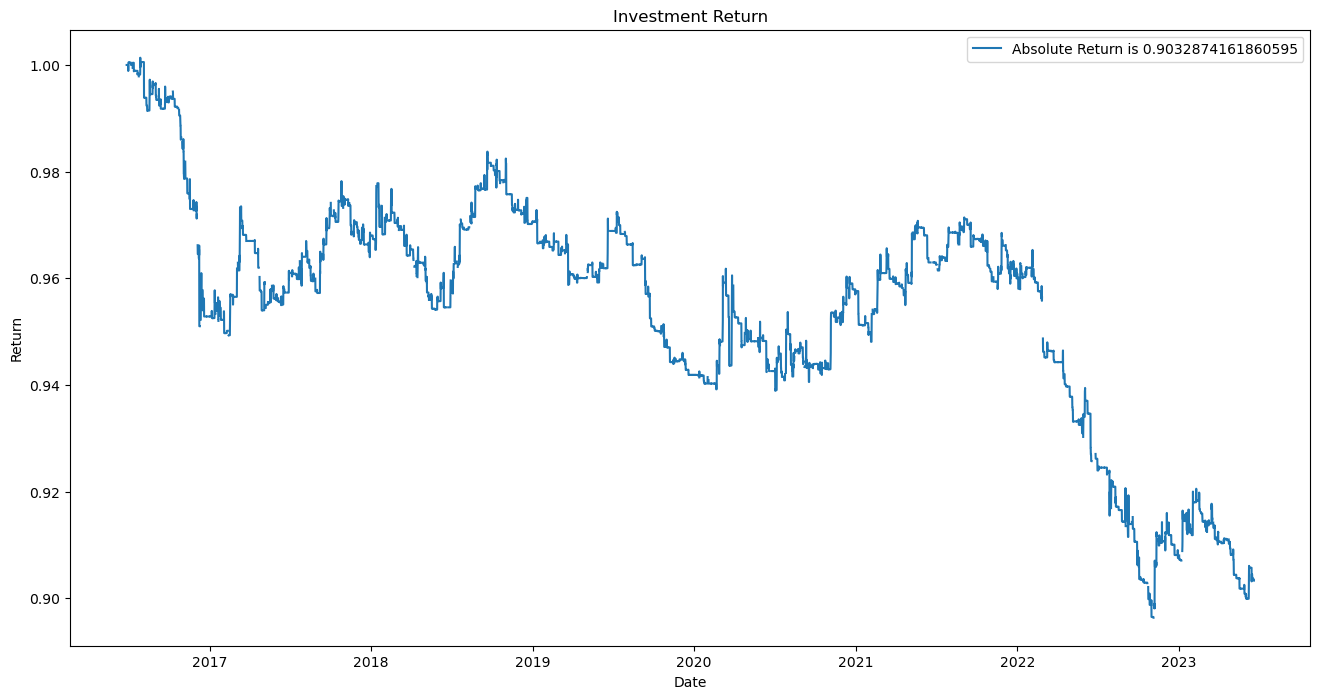

Maximum Drawdown: -0.104890697257256


EurUSD_return  investment_return
count   11102.000000       11099.000000
mean        1.024757           0.954136
std         0.053628           0.021587
min         0.858780           0.896326
25%         0.992366           0.944284
50%         1.022894           0.959203
75%         1.064307           0.967333
max         1.152738           1.001359

In [239]:
trade_candle_4233('4h')

#### 1d

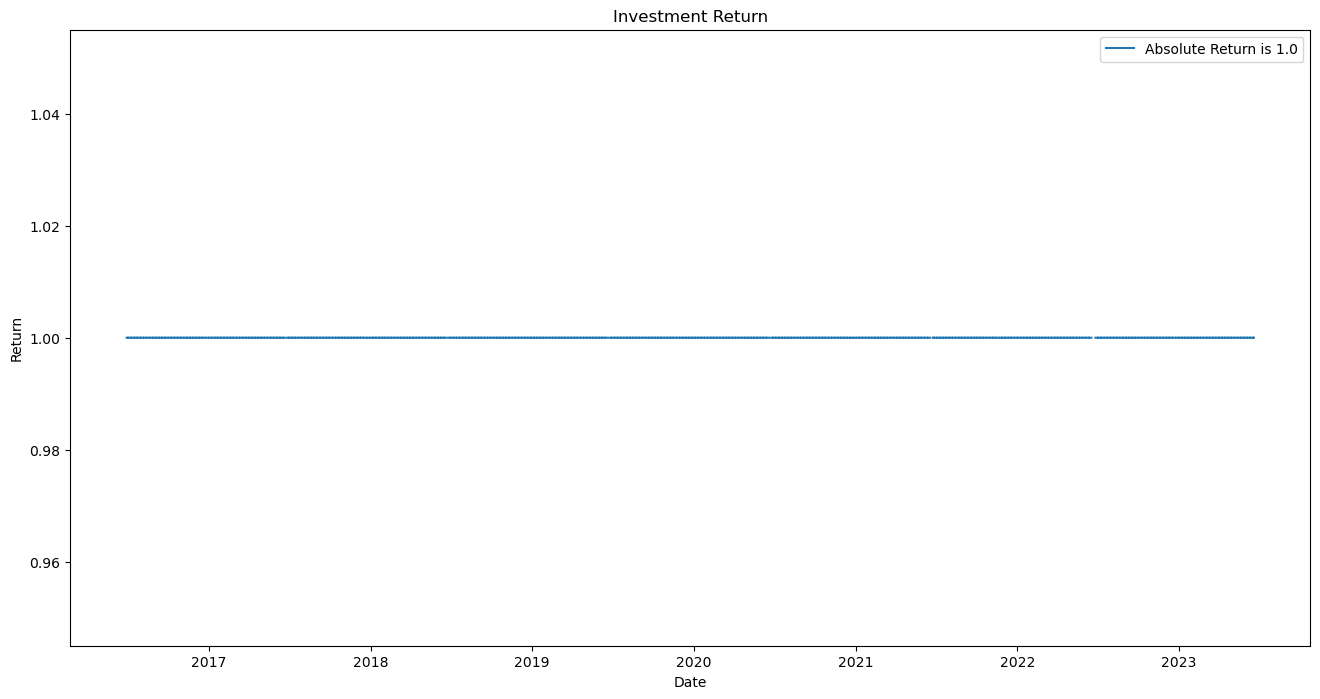

Maximum Drawdown: 0.0


EurUSD_return  investment_return
count    2157.000000             2154.0
mean        1.023700                1.0
std         0.055259                0.0
min         0.855628                1.0
25%         0.992214                1.0
50%         1.023119                1.0
75%         1.064254                1.0
max         1.150059                1.0

In [240]:
trade_candle_4233('1d')

#### 3d

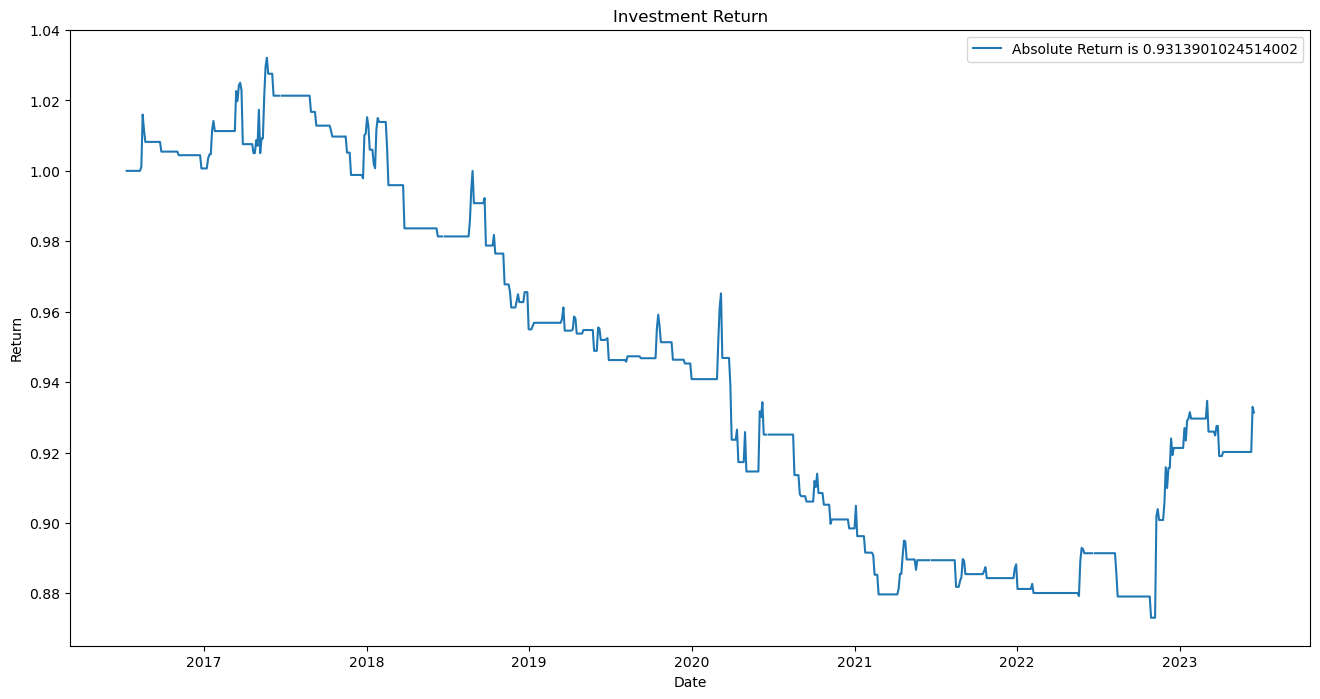

Maximum Drawdown: -0.1540937473191832


EurUSD_return  investment_return
count     845.000000         840.000000
mean        1.004901           0.944124
std         0.054634           0.048272
min         0.846010           0.873086
25%         0.977094           0.891568
50%         1.006944           0.946263
75%         1.041412           0.991184
max         1.131860           1.032131

In [241]:
trade_candle_4233('3d')

### Strategy 4<a id='strategy_4_'></a>
- We buy when the bar has no wick and %K > %D
- We exit if bar is red

In [242]:
def trade_candle_4234(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    df = compute_stochastic_oscillator(df)
    df['stochastic_above'] = np.where(df['%K'] > df['%D'], 1, 0)
    df['ha_candle_green'] = np.where(df['ha_close'] > df['ha_open'], 1, 0)
    df['ha_candle_green_no_wick'] = np.where(df['ha_open'] == df['ha_low'], 1, 0)
    df['ha_close_smaller_than_previous'] = np.where(df['ha_close'] < df['ha_close'].shift(1), 1, 0)
    df['ha_candle_green_difference'] = np.where(df['ha_candle_green'] - df['ha_candle_green'].shift(1) == 1, 1, 0)

    df['entry'] = (df['ha_candle_green_no_wick'] * df['stochastic_above']).shift(1)
    df['position'] = np.where(df['entry'] == 1, 1, np.nan)
    df['position'] = np.where(df['ha_candle_green'].shift(1) == 0, 0, df['position'])
    df['position'] = df['position'].ffill()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    investment_return = df['investment_return']
    peak = investment_return.cummax()
    drawdown = (investment_return - peak) / peak
    max_drawdown = drawdown.min()

    print("Maximum Drawdown:", max_drawdown)

    return df[['EurUSD_return', 'investment_return']].describe()

#### 1h

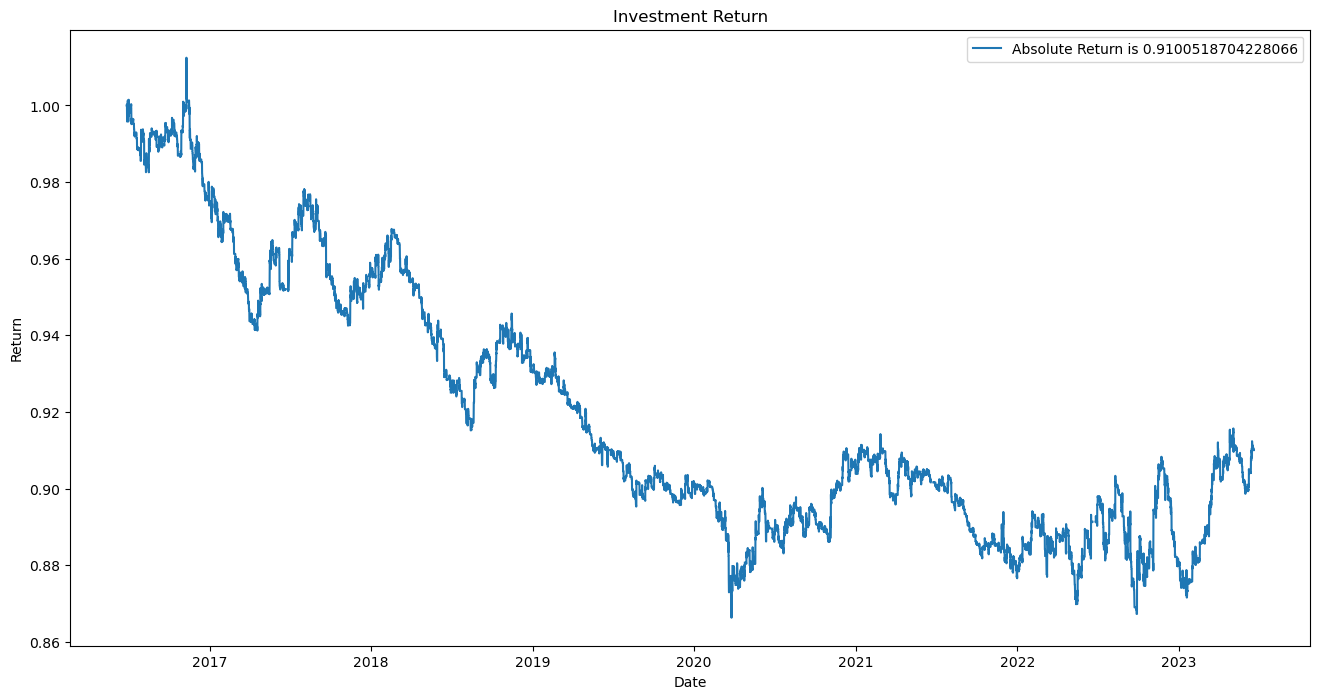

Maximum Drawdown: -0.1443607049133873


EurUSD_return  investment_return
count   42930.000000       42928.000000
mean        1.035284           0.918917
std         0.053783           0.033822
min         0.867599           0.866293
25%         1.000082           0.891389
50%         1.034960           0.905972
75%         1.075276           0.946009
max         1.161048           1.012451

In [243]:
trade_candle_4234('1h')

#### 4h

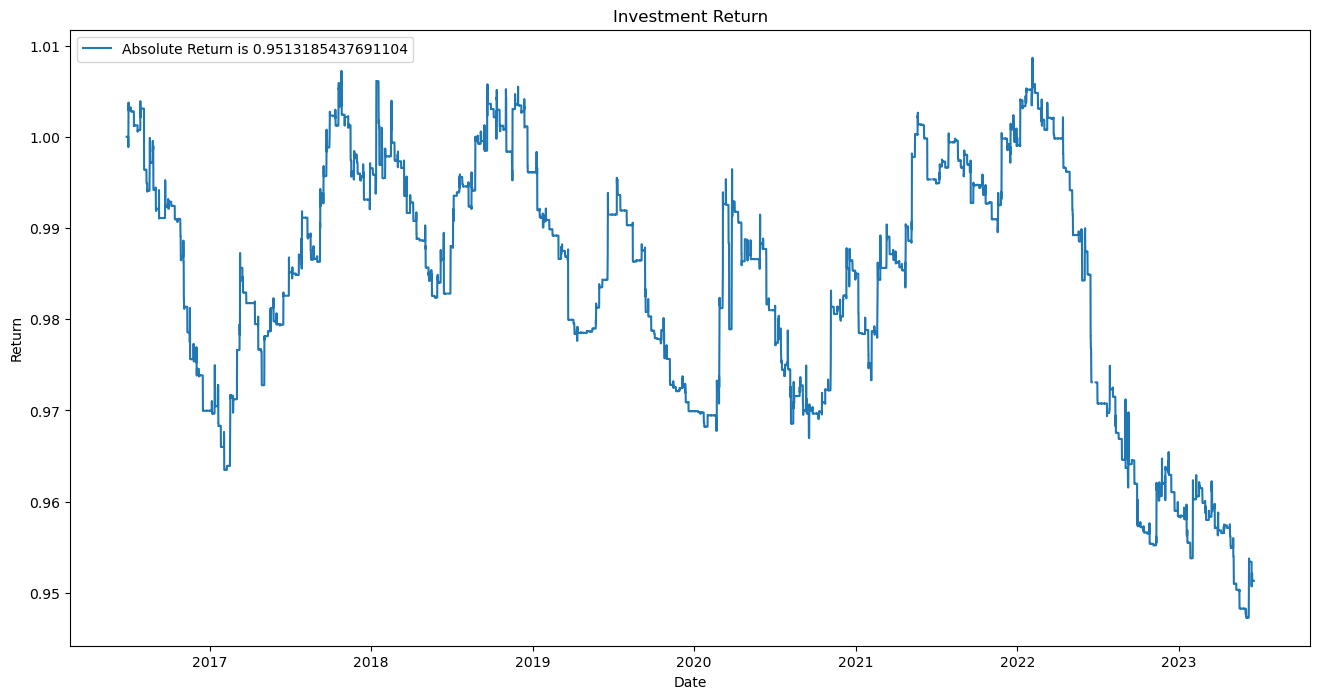

Maximum Drawdown: -0.06087322138644327


EurUSD_return  investment_return
count   11102.000000       11100.000000
mean        1.024757           0.983892
std         0.053628           0.013926
min         0.858780           0.947272
25%         0.992366           0.972810
50%         1.022894           0.986445
75%         1.064307           0.995329
max         1.152738           1.008673

In [244]:
trade_candle_4234('4h')

#### 1d

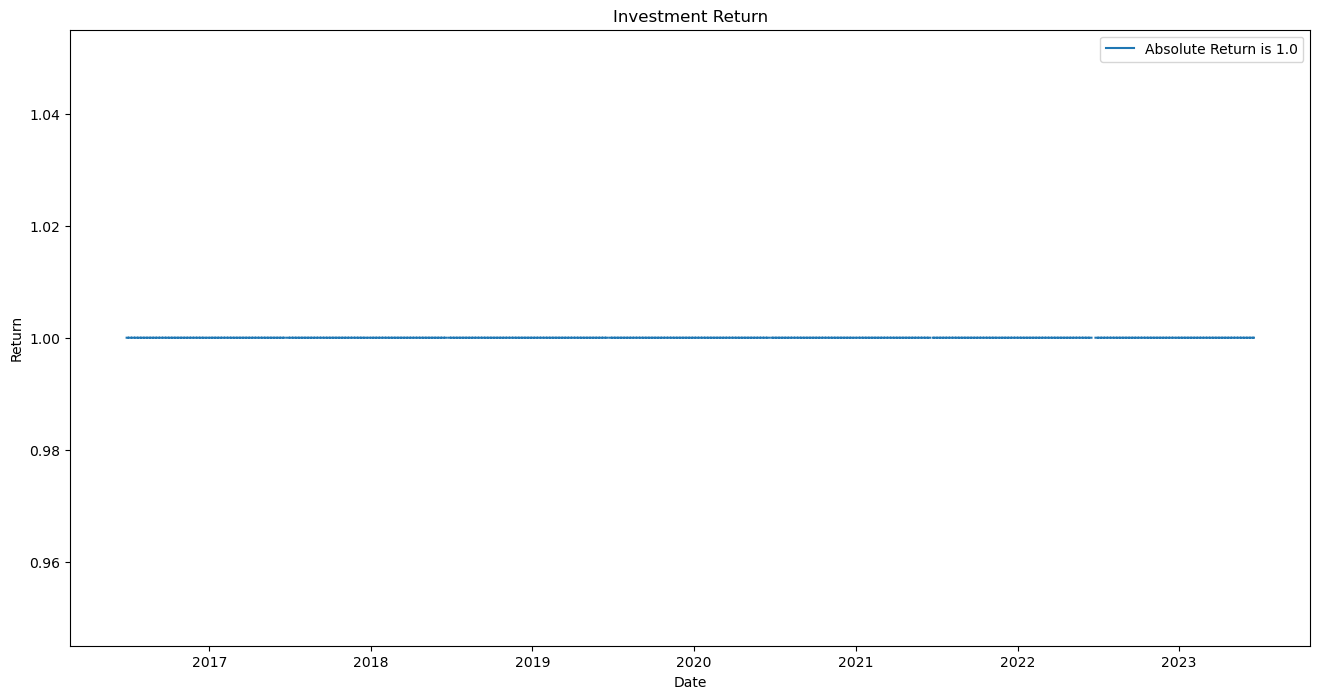

Maximum Drawdown: 0.0


EurUSD_return  investment_return
count    2157.000000             2155.0
mean        1.023700                1.0
std         0.055259                0.0
min         0.855628                1.0
25%         0.992214                1.0
50%         1.023119                1.0
75%         1.064254                1.0
max         1.150059                1.0

In [245]:
trade_candle_4234('1d')

#### 3d

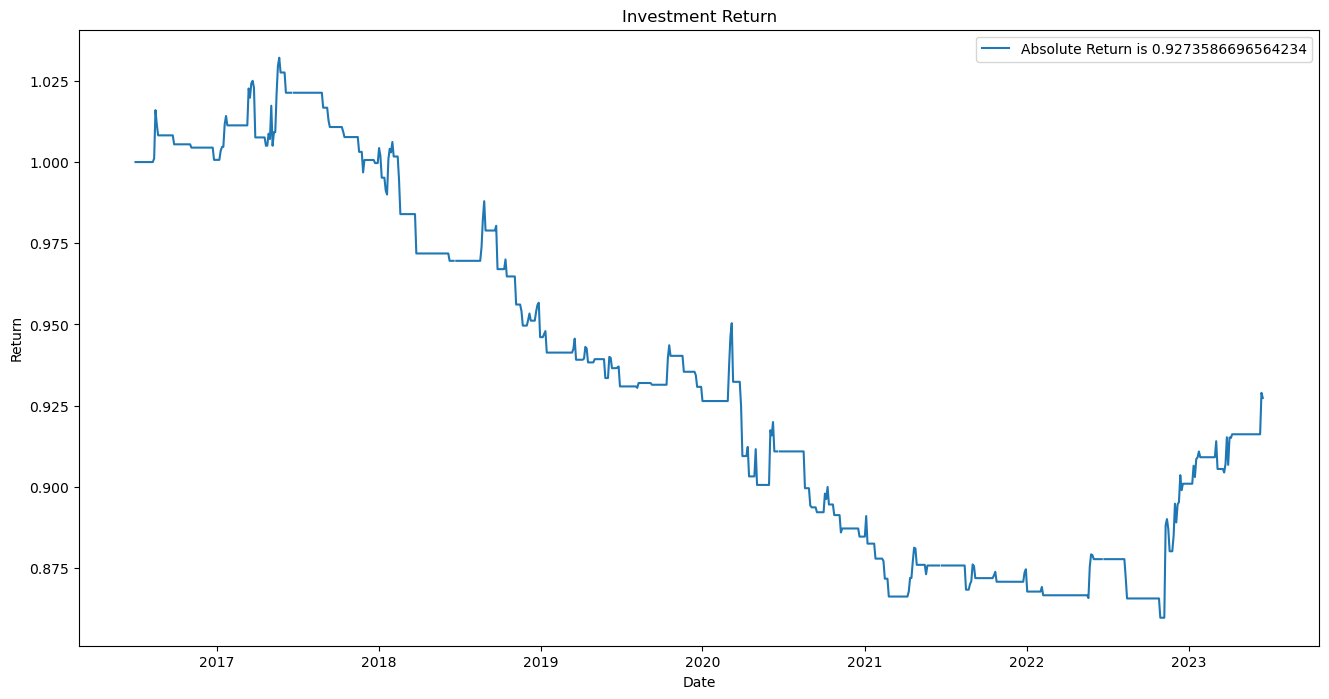

Maximum Drawdown: -0.16707491875591526


EurUSD_return  investment_return
count     845.000000         843.000000
mean        1.004901           0.933619
std         0.054634           0.052642
min         0.846010           0.859688
25%         0.977094           0.877886
50%         1.006944           0.930913
75%         1.041412           0.983257
max         1.131860           1.032131

In [246]:
trade_candle_4234('3d')

### 4.3 Divergence<a id='4_3'></a>
### 4.3.1 MACD Convergence and Divergence<a id='4_3_1_macd_convergence_and_divergence'></a>
- We want to use the convergence divergence method (when price is making a higher high but MACD is making a lower high or vice versa).
- We will set a period that we use to find the two peaks.
- We use the SMA on EMA and get the first derivative of that curve. When the MACD value is lower when its derivative hits 0 we have ourselves a convergence.
- We will try RSI later

-- Frank

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.signal import argrelextrema
from collections import deque

In [269]:
def local_max_min(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()

    indicators = ['close']  # change this line
    for indicator in indicators:
        df[f'{indicator}_local_max'] = df[indicator][
            (df[indicator].shift(1) < df[indicator]) &
            (df[indicator].shift(-1) < df[indicator]) &
            (df[indicator].shift(2) < df[indicator]) &
            (df[indicator].shift(-2) < df[indicator])
        ]

        df[f'{indicator}_local_min'] = df[indicator][
            (df[indicator].shift(1) > df[indicator]) &
            (df[indicator].shift(-1) > df[indicator]) &
            (df[indicator].shift(2) > df[indicator]) &
            (df[indicator].shift(-2) > df[indicator])
        ]
        
    # Plotting the data
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    #set the timeframe for data
    temp = df.loc[: ]
    
    plt.figure(figsize=(15, 8))
    plt.plot(temp['close'], zorder=0)  # change this line
    plt.scatter(temp.index, temp['close_local_max'], s=100,
                label='Maxima', marker='^', c=colors[1])
    plt.scatter(temp.index, temp['close_local_min'], s=100,
                label='Minima', marker='v', c=colors[2])
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'Local Maxima and Minima for EurUSD')
    plt.legend()
    plt.show()

    return df


In [270]:
## debugging
print(EurUSD_1d_414.columns)

Index(['open', 'high', 'low', 'close', 'ha_close', 'ha_open', 'ha_high',
       'ha_low', 'MACD', 'Signal Line', 'log_return', 'pct_return',
       'close_local_max', 'close_local_min'],
      dtype='object')


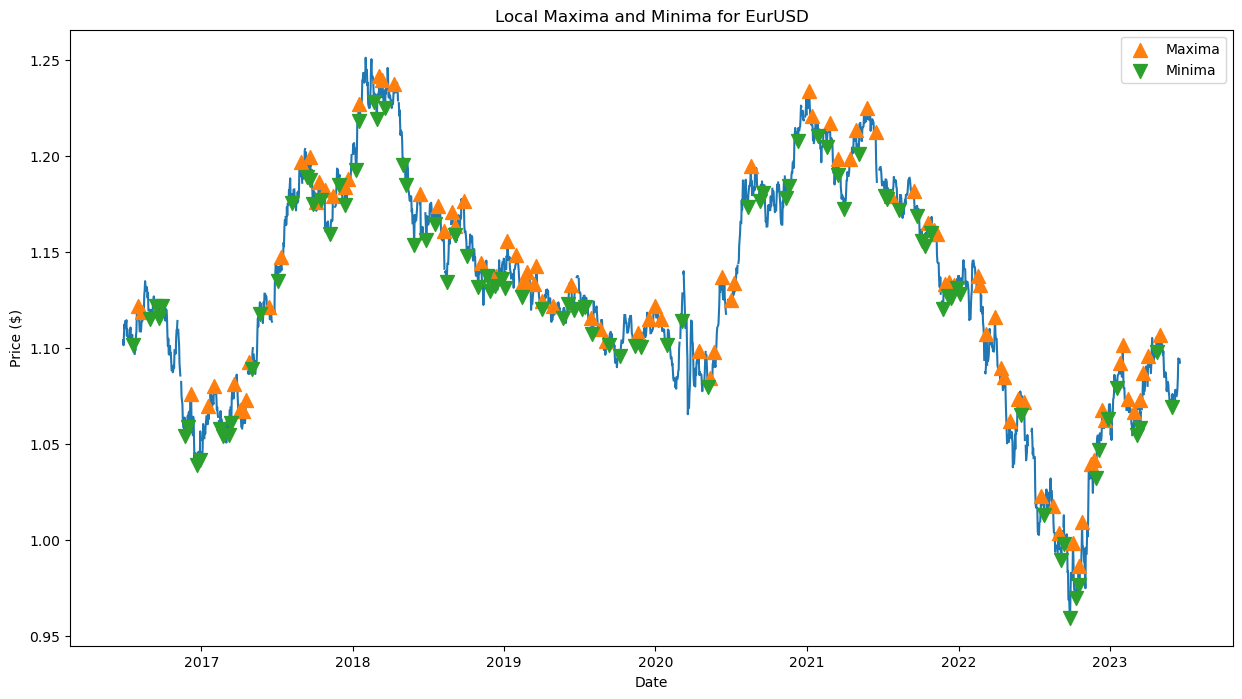

open     high      low    close  ha_close  \
time                                                                      
2016-06-26 00:00:00+00:00  1.10125  1.10748  1.10084  1.10400  1.103392   
2016-06-27 00:00:00+00:00  1.10402  1.10838  1.09710  1.10139  1.102723   
2016-06-28 00:00:00+00:00  1.10136  1.11122  1.10130  1.10757  1.105363   
2016-06-29 00:00:00+00:00  1.10760  1.11306  1.10494  1.11222  1.109455   
2016-06-30 00:00:00+00:00  1.11224  1.11546  1.10244  1.11029  1.110107   
...                            ...      ...      ...      ...       ...   
2023-06-15 00:00:00+00:00  1.08429  1.09527  1.08038  1.09455  1.088623   
2023-06-16 00:00:00+00:00  1.09456  1.09708  1.09178  1.09416  1.094395   
2023-06-17 00:00:00+00:00      NaN      NaN      NaN      NaN       NaN   
2023-06-18 00:00:00+00:00  1.09422  1.09435  1.09334  1.09398  1.093973   
2023-06-19 00:00:00+00:00  1.09398  1.09463  1.09072  1.09236  1.092923   

                            ha_open  ha_high    ha_low      MACD  Signal Line  \
time                                                                            
2016-06-26 00:00:00+00:00       NaN  1.10748  1.100840  0.000000     0.000000   
2016-06-27 00:00:00+00:00  1.102625  1.10838  1.097100 -0.000208    -0.000042   
2016-06-28 00:00:00+00:00  1.102705  1.11122  1.101300  0.000124    -0.000009   
2016-06-29 00:00:00+00:00  1.104465  1.11306  1.104465  0.000754     0.000144   
2016-06-30 00:00:00+00:00  1.109910  1.11546  1.102440  0.001085     0.000332   
...                             ...      ...       ...       ...          ...   
2023-06-15 00:00:00+00:00  1.081630  1.09527  1.080380 -0.000007    -0.002760   
2023-06-16 00:00:00+00:00  1.089420  1.09708  1.089420  0.001185    -0.001971   
2023-06-17 00:00:00+00:00  1.094360  1.09436  1.094360  0.001185    -0.001340   
2023-06-18 00:00:00+00:00       NaN  1.09435  1.093340  0.002303    -0.000611   
2023-06-19 00:00:00+00:00  1.094100  1.09463  1.090720  0.002821     0.000075   

                           log_return  pct_return  close_local_max  \
time                                                                 
2016-06-26 00:00:00+00:00    0.002494    0.002497              NaN   
2016-06-27 00:00:00+00:00   -0.002385   -0.002382              NaN   
2016-06-28 00:00:00+00:00    0.005623    0.005638              NaN   
2016-06-29 00:00:00+00:00    0.004163    0.004171              NaN   
2016-06-30 00:00:00+00:00   -0.001755   -0.001753              NaN   
...                               ...         ...              ...   
2023-06-15 00:00:00+00:00    0.009418    0.009462              NaN   
2023-06-16 00:00:00+00:00   -0.000366   -0.000365              NaN   
2023-06-17 00:00:00+00:00         NaN         NaN              NaN   
2023-06-18 00:00:00+00:00   -0.000219   -0.000219              NaN   
2023-06-19 00:00:00+00:00   -0.001482   -0.001481              NaN   

                           close_local_min  
time                                        
2016-06-26 00:00:00+00:00              NaN  
2016-06-27 00:00:00+00:00              NaN  
2016-06-28 00:00:00+00:00              NaN  
2016-06-29 00:00:00+00:00              NaN  
2016-06-30 00:00:00+00:00              NaN  
...                                    ...  
2023-06-15 00:00:00+00:00              NaN  
2023-06-16 00:00:00+00:00              NaN  
2023-06-17 00:00:00+00:00              NaN  
2023-06-18 00:00:00+00:00              NaN  
2023-06-19 00:00:00+00:00              NaN  

[2550 rows x 14 columns]

In [271]:
EurUSD_1d_414 = local_max_min('1d')
EurUSD_1d_414

In [ ]:
### Derivative section


## 4.4 Hull Moving Average <a id='4_4'></a>
- Faster at catching trends

### 4.4.1 HMA Simple Momentum <a id='4_4_1'></a>
- Buy when the HMA 14 is above the EMA 200.
- This is a testing. We are just trying to get a simple momentum method with HMA

--Frank

In [84]:
def trade_hma_441(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy()
    df = add_exponential_moving_average(add_hull_moving_average(df, 'close', 14), 'close', 100)

    hma_name = 'close_hma_14'
    ema_name = 'close_ema_100'
    df['hma_over_ema'] = np.where(df[hma_name] > df[ema_name], 1, 0)
    df['position'] = df['hma_over_ema'].shift()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.plot(df['EurUSD_return'], label="EurUSD Return is " + str(df['EurUSD_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    investment_return = df['investment_return']
    peak = investment_return.cummax()
    drawdown = (investment_return - peak) / peak
    max_drawdown = drawdown.min()

    print("Maximum Drawdown:", max_drawdown)

    return df[['EurUSD_return', 'investment_return']].describe()


### 1h

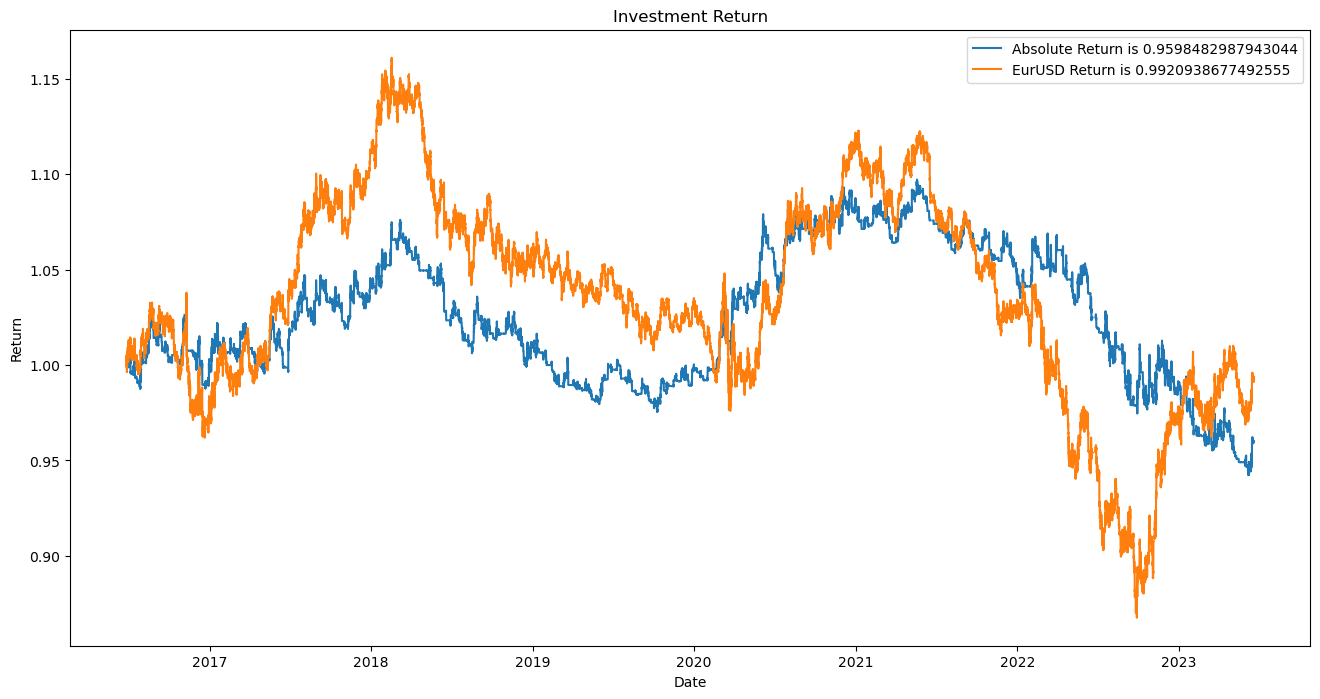

Maximum Drawdown: -0.1411857388641883


EurUSD_return  investment_return
count   42930.000000       42928.000000
mean        1.035284           1.024626
std         0.053783           0.034590
min         0.867599           0.942292
25%         1.000082           0.997593
50%         1.034960           1.019739
75%         1.075276           1.055118
max         1.161048           1.097201

In [85]:
trade_hma_strategy_441('1h')

### 4h

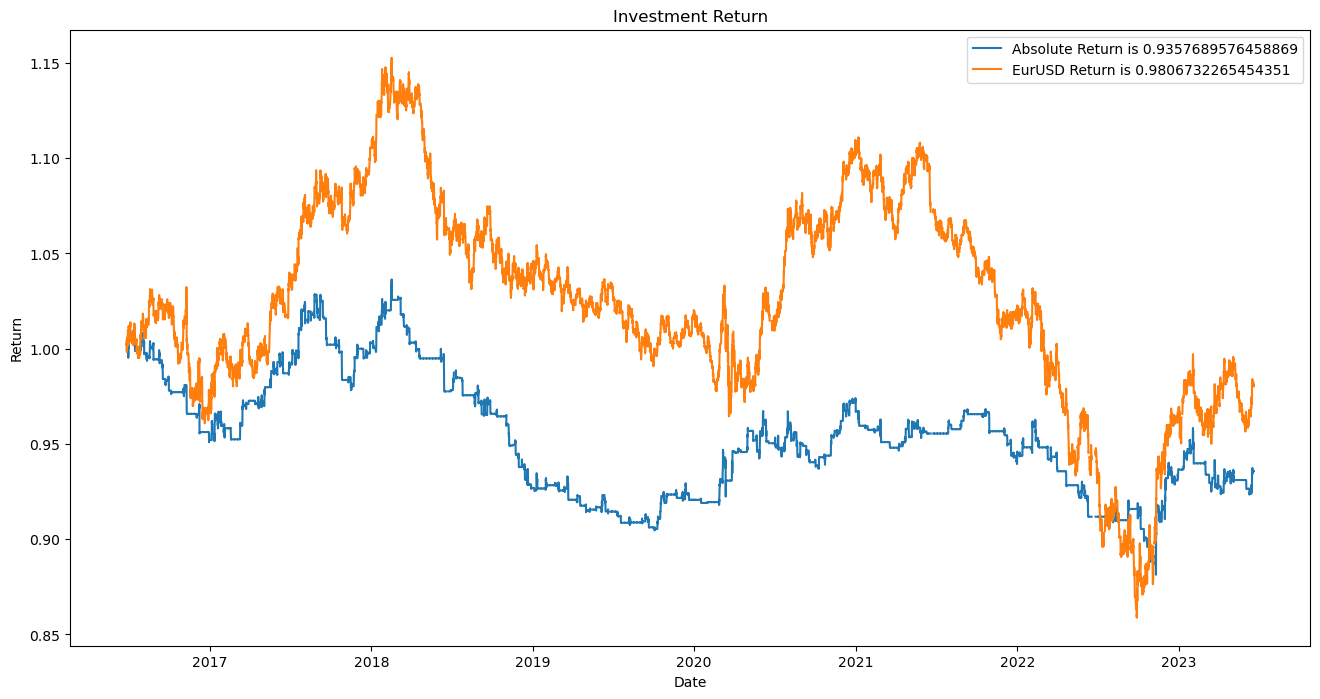

Maximum Drawdown: -0.14957175387070865


EurUSD_return  investment_return
count   11102.000000       11100.000000
mean        1.024757           0.953784
std         0.053628           0.030834
min         0.858780           0.881350
25%         0.992366           0.928346
50%         1.022894           0.952091
75%         1.064307           0.972660
max         1.152738           1.036360

In [89]:
trade_hma_strategy_441('4h')

### 1d

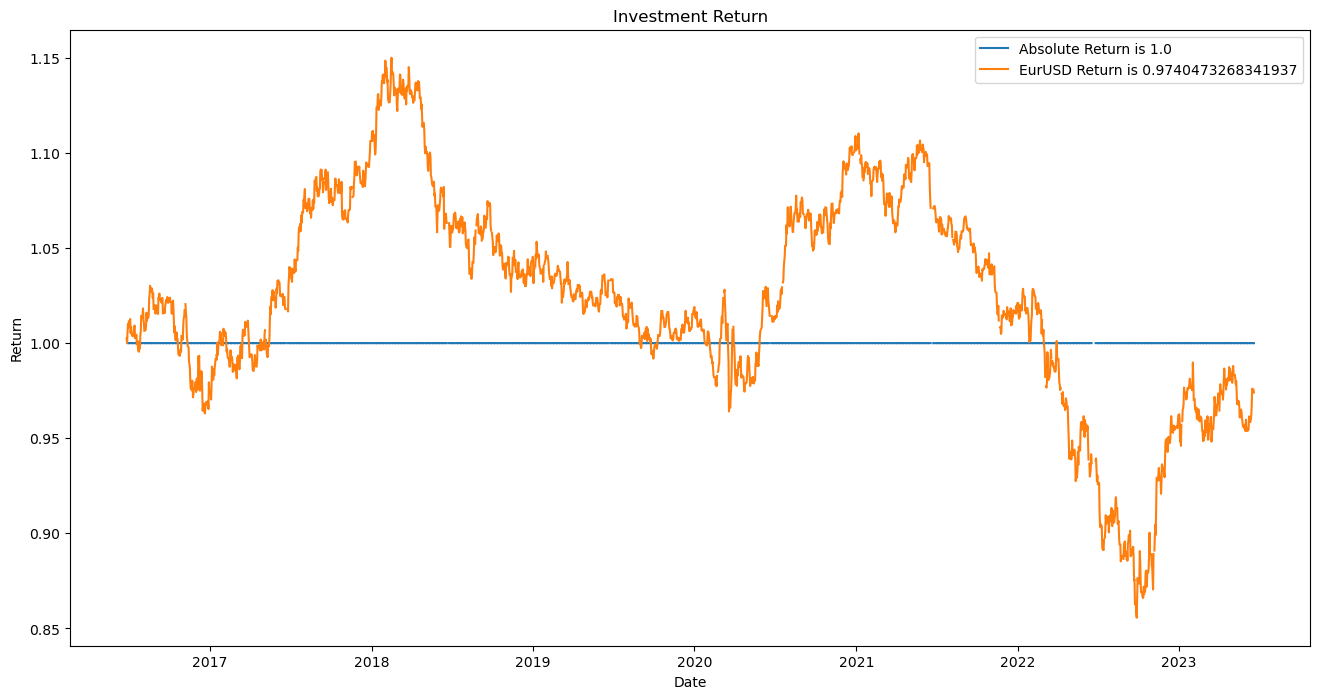

Maximum Drawdown: 0.0


EurUSD_return  investment_return
count    2157.000000             2155.0
mean        1.023700                1.0
std         0.055259                0.0
min         0.855628                1.0
25%         0.992214                1.0
50%         1.023119                1.0
75%         1.064254                1.0
max         1.150059                1.0

In [87]:
trade_hma_strategy_441('1d')    #why is the absolute returns flatlining???

### 3d

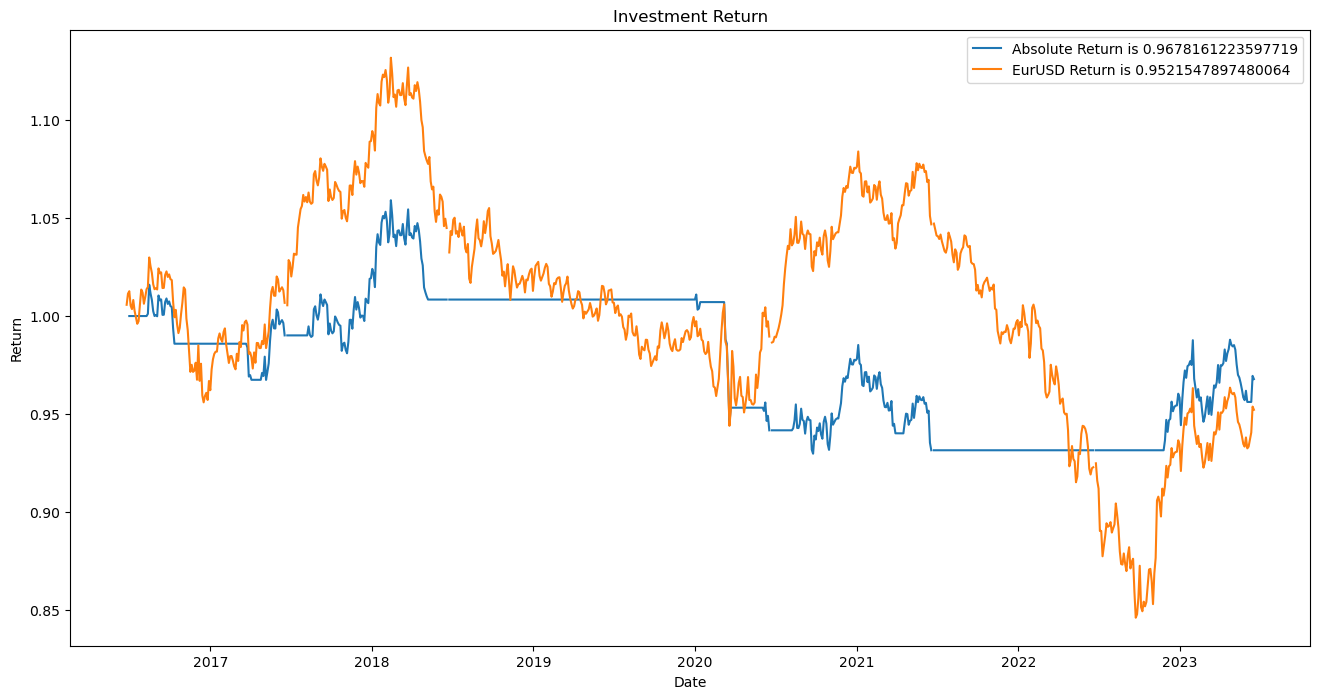

Maximum Drawdown: -0.12216788309913243


EurUSD_return  investment_return
count     845.000000         843.000000
mean        1.004901           0.976720
std         0.054634           0.033457
min         0.846010           0.929729
25%         0.977094           0.941673
50%         1.006944           0.985878
75%         1.041412           1.008415
max         1.131860           1.059119

In [88]:
trade_hma_strategy_441('3d')

### 4.4.2 HMA and EMA Momentum <a id='4_4_2'></a>
- We will buy when the closed price is above 100 HMA and 200 EMA

In [127]:
def trade_hma_442(timeframe):
    df_name = f'EurUSD_{timeframe}'
    df = globals()[df_name].copy() 
    df = add_exponential_moving_average(add_hull_moving_average(df, 'close', 100), 'close', 200)

    hma_name = 'close_hma_100'
    ema_name = 'close_ema_200'
    df['close_over_hma'] = np.where(df['close'] > df[hma_name], 1, 0)
    df['close_over_ema'] = np.where(df['close'] > df[ema_name], 1, 0)

    df['position'] = (df['close_over_hma'] * df['close_over_ema']).shift()

    df['trade'] = np.abs(df.loc[:, 'position'] - df.loc[:, 'position'].shift(1))
    df['EurUSD_return'] = df.loc[:, 'log_return'].cumsum().apply(np.exp)

    df['strategy'] = df.loc[:, 'position'] * df.loc[:, 'log_return'] * ((df.loc[:, 'trade'] * 0.99).apply(lambda x: 1 if x == 0 else x))
    df['investment_return'] = df.loc[:, 'strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(16,8))
    plt.plot(df['investment_return'], label="Absolute Return is " + str(df['investment_return'][-1]))
    plt.ylabel("Return")
    plt.xlabel('Date')
    plt.title("Investment Return")
    plt.legend()
    plt.show()

    investment_return = df['investment_return']
    peak = investment_return.cummax()
    drawdown = (investment_return - peak) / peak
    max_drawdown = drawdown.min()

    print("Maximum Drawdown:", max_drawdown)

    return df[['EurUSD_return', 'investment_return']].describe()


### 1h

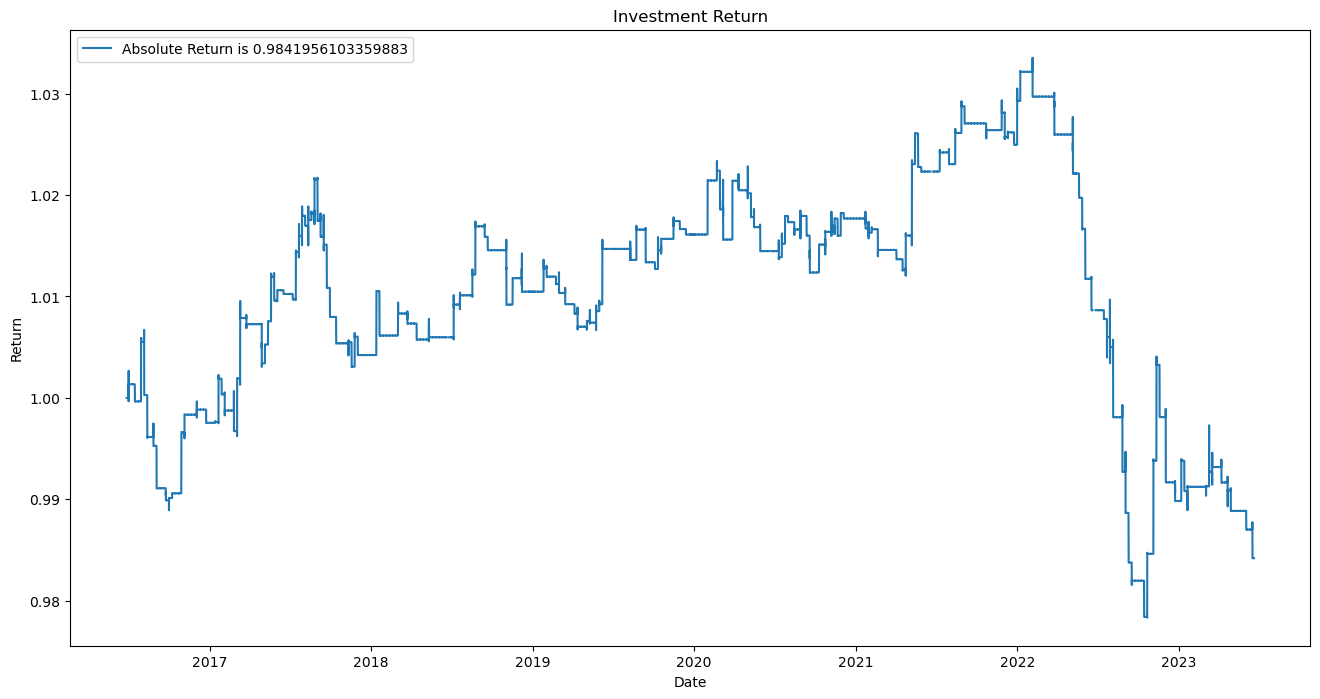

Maximum Drawdown: -0.05343433323877206


EurUSD_return  investment_return
count   42930.000000       42928.000000
mean        1.035284           1.010203
std         0.053783           0.011337
min         0.867599           0.978314
25%         1.000082           1.005243
50%         1.034960           1.011943
75%         1.075276           1.016911
max         1.161048           1.033541

In [128]:
trade_hma_442('1h')

### 4h

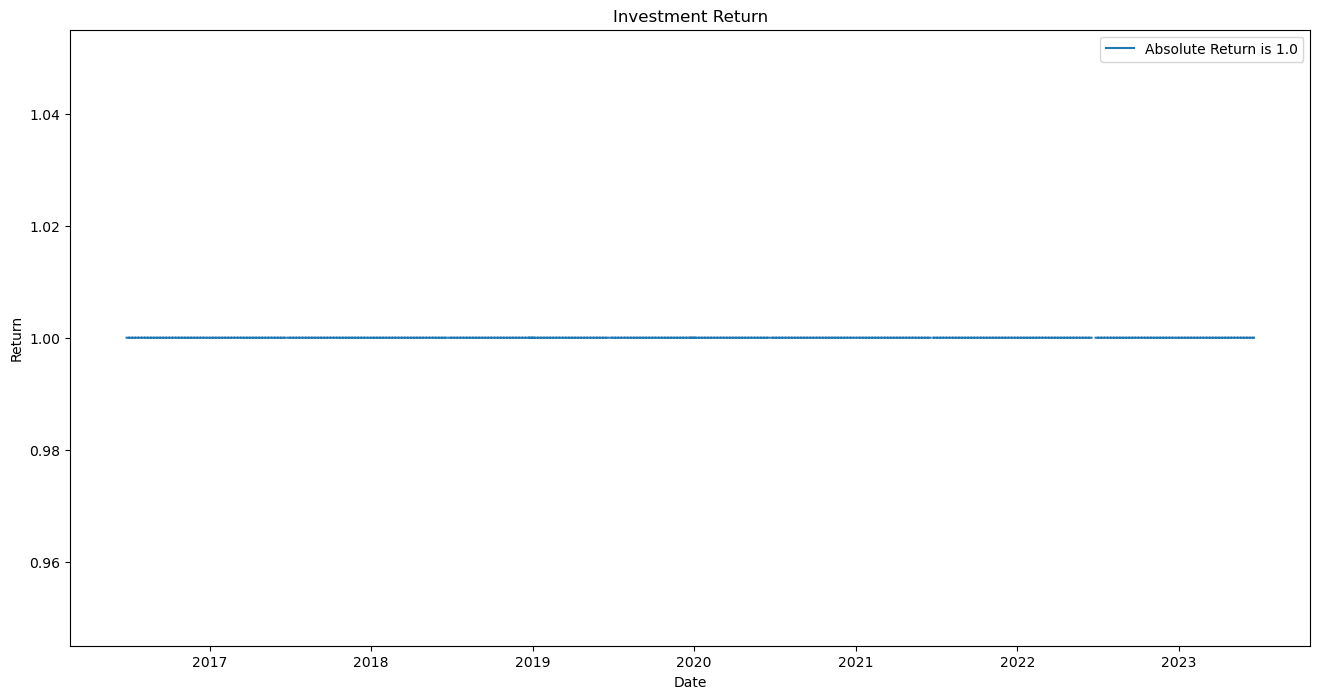

Maximum Drawdown: 0.0


EurUSD_return  investment_return
count   11102.000000            11100.0
mean        1.024757                1.0
std         0.053628                0.0
min         0.858780                1.0
25%         0.992366                1.0
50%         1.022894                1.0
75%         1.064307                1.0
max         1.152738                1.0

In [129]:
trade_hma_442('4h')

### 1d

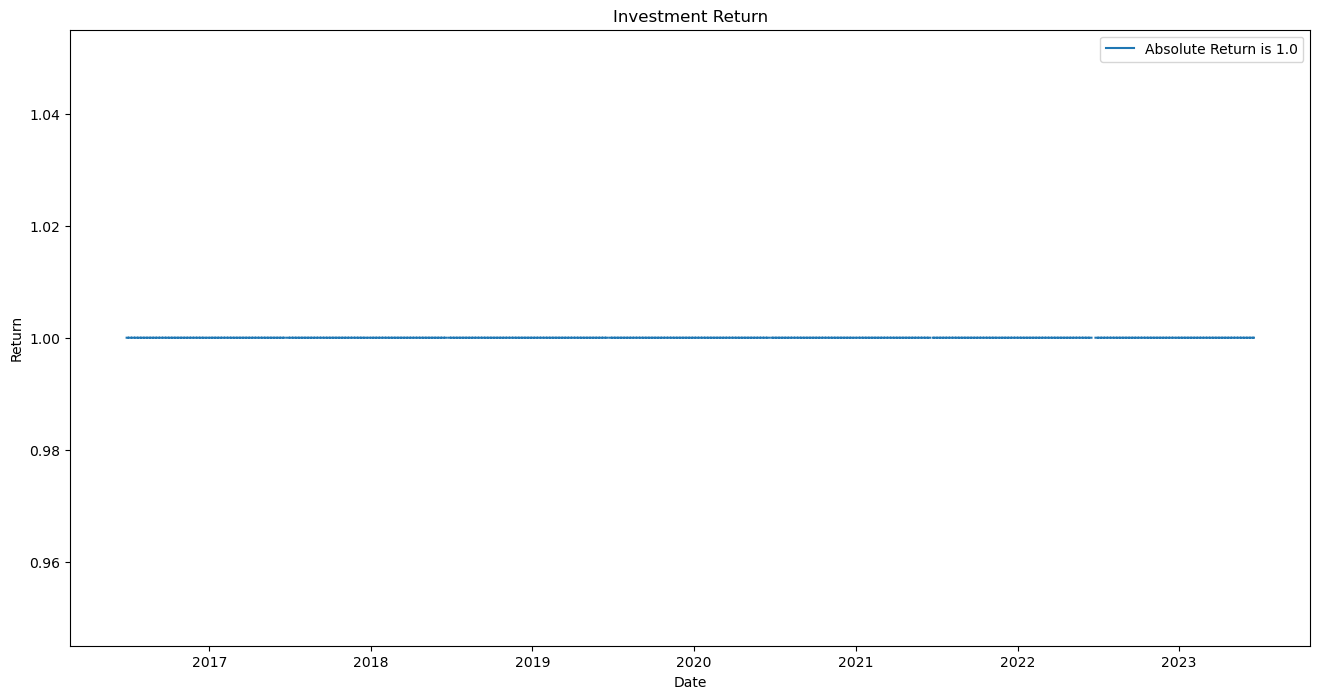

Maximum Drawdown: 0.0


EurUSD_return  investment_return
count    2157.000000             2155.0
mean        1.023700                1.0
std         0.055259                0.0
min         0.855628                1.0
25%         0.992214                1.0
50%         1.023119                1.0
75%         1.064254                1.0
max         1.150059                1.0

In [130]:
trade_hma_442('1d')

### 3d

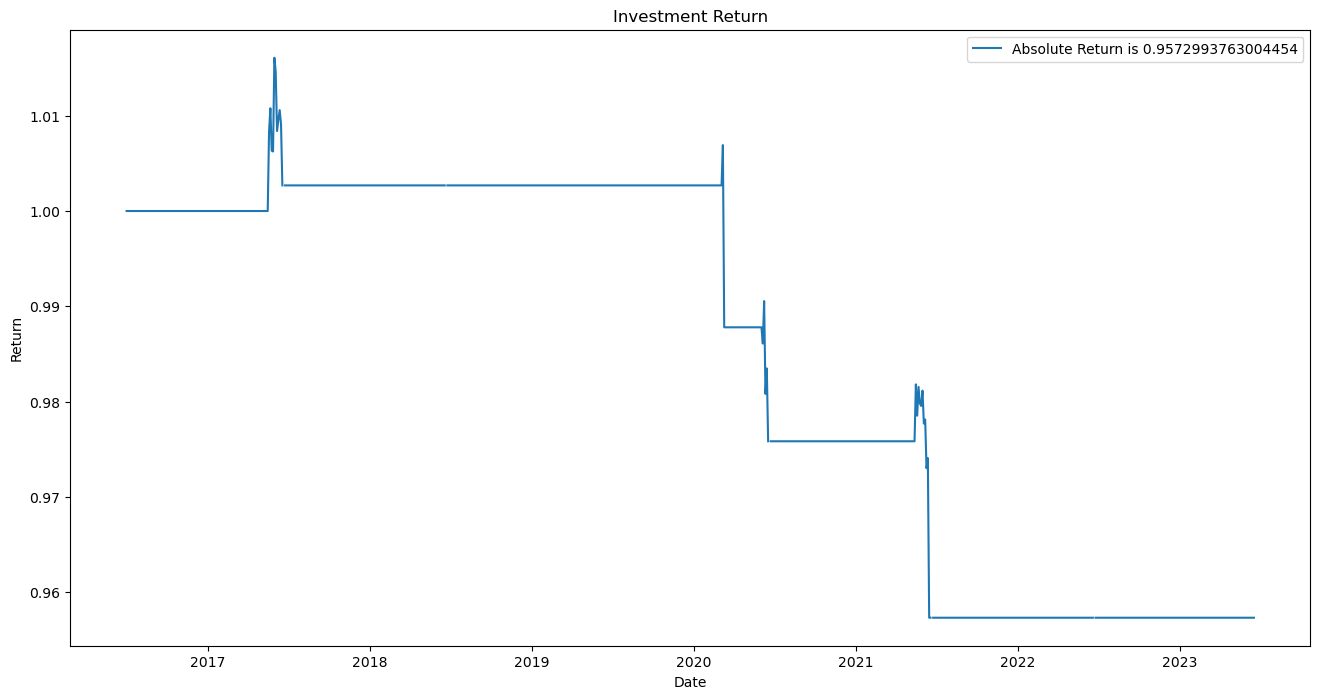

Maximum Drawdown: -0.0578651122359232


EurUSD_return  investment_return
count     845.000000         843.000000
mean        1.004901           0.984969
std         0.054634           0.019808
min         0.846010           0.957299
25%         0.977094           0.957299
50%         1.006944           1.000000
75%         1.041412           1.002691
max         1.131860           1.016096

In [247]:
trade_hma_442('3d')

#### Bitcoin 0.2 also has a for both buy| and short strategy, but this strategy obviously needs adjustment lol

#### Also something about Sharpe Ratio and Sortino Ratio, Will look into later...

### 4.4.3 HMA and EMA Between<a id='4_4_3'></a>
- We want to buy when the close price is above the HMA but below the EMA, and we sett if otherwise.

### 4.4.4 HMA and RSI <a id='4_4_4'></a>
- This is my own custom developed, combining both hma and RSI indicators as a strategy.
- Based off of this strategy https://youtu.be/ASCu_7EnBCI
- General rule is if these conditions are met we entry:
    - 
    - 
- We exit when conditions are unmet